In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv(
    "base-de-datos---interanual-2008---2024-csv.csv",
    sep=";",
    quotechar='"',
    encoding="utf-8-sig",
    engine="python"   # <- mantener python
)


In [3]:
print(df1.columns)

Index(['Unnamed: 0', 'id_unico', 'idr', 'region', 'region16', 'com102', 'edad',
       'sexo', 'pad', 'padb', 'ped', 'rvi', 'rps', 'rfv', 'hur', 'les',
       'prop_vehiculos', 'rdv', 'rddv', 'vh_dmcs', 'vh_dv',
       'fact_pers_2008_2019', 'fact_hog_2008_2019', 'fact_pers_2019_2024',
       'fact_hog_2019_2024', 'fact_pers_2023_2024', 'fact_hog_2023_2024',
       'varstrat', 'conglomerado', 'año'],
      dtype='object')


In [ ]:
# ============================================================
# BLOQUE 1 — DATAFRAMES ENUSC 2019–2024
# Percepción: SOLO PAD
# Victimización: VH_DMCS (agregado) + componentes (RVI, RPS, RFV, HUR, LES, RDV*, RDDV*)
# * RDV/RDDV filtrados a hogares con vehículo
# Comparabilidad: com102==1, factores 2019–2024
# Regional: region16 (nombres completos incluidos)
# ============================================================

# ---- 0) Ruta del CSV (ajusta si corresponde)
CSV_PATH = "base-de-datos---interanual-2008---2024-csv.csv"

# ---- 1) Lectura robusta
df = pd.read_csv(
    CSV_PATH,
    sep=";",
    encoding="utf-8-sig",
    engine="python",
    dtype=str
)
df.columns = [c.strip().strip('"') for c in df.columns]
# Alias si la base trae 'vh_dcms' en lugar de 'vh_dmcs'
if "vh_dcms" in df.columns and "vh_dmcs" not in df.columns:
    df = df.rename(columns={"vh_dcms": "vh_dmcs"})

# ---- 2) Utilidades
def _num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace('"','').str.replace(',', '.', regex=False).str.strip(),
        errors="coerce"
    )

def _wprop(df_sub: pd.DataFrame, var_binaria: str, peso: str) -> float:
    w = _num(df_sub[peso])
    x = _num(df_sub[var_binaria]).fillna(0)
    m = w.notna() & (w > 0) & x.notna()
    return (w[m] * (x[m] == 1)).sum() / w[m].sum() if m.any() else np.nan

def _factor(unit: str) -> str:
    return f"fact_{unit}_2019_2024"  # personas/hogares

# ---- 3) Subconjunto 2019–2024 (comparabilidad)
years_1924 = [str(y) for y in range(2019, 2025)]
df_1924 = df[(df["año"].astype(str).isin(years_1924)) & (df["com102"] == "1")].copy()
if "region16" in df_1924.columns:
    df_1924["region16"] = _num(df_1924["region16"]).astype("Int64")

# ---- 4) Generadores (nacional / regional)
def serie_nacional(df_base: pd.DataFrame, var: str, unit: str, filtro_extra: str | None = None) -> pd.DataFrame:
    tmp = df_base if not filtro_extra else df_base.query(filtro_extra)
    peso = _factor(unit)
    out = (tmp.groupby("año", group_keys=False)
              .apply(lambda g: pd.Series({var: _wprop(g, var, peso)}))
              .reset_index())
    out["año"] = out["año"].astype(int)
    out[f"{var}_pct"] = (out[var] * 100).round(1)
    return out.sort_values("año", kind="stable").reset_index(drop=True)

def serie_regional(df_base: pd.DataFrame, var: str, unit: str, filtro_extra: str | None = None) -> pd.DataFrame:
    tmp = df_base[df_base["region16"].notna()].copy()
    if filtro_extra:
        tmp = tmp.query(filtro_extra)
    peso = _factor(unit)
    out = (tmp.groupby(["año","region16"], group_keys=False)
              .apply(lambda g: pd.Series({var: _wprop(g, var, peso)}))
              .reset_index())
    out["año"] = out["año"].astype(int)
    out["region16"] = out["region16"].astype("Int64")
    out[f"{var}_pct"] = (out[var] * 100).round(1)
    return out.sort_values(["año","region16"], kind="stable").reset_index(drop=True)

# ---- 5) Percepción (SOLO PAD)
nat_pad  = serie_nacional(df_1924, "pad",  unit="pers")
reg_pad  = serie_regional(df_1924, "pad",  unit="pers")

# ---- 6) Victimización (agregado + componentes)
nat_vh_dmcs = serie_nacional(df_1924, "vh_dmcs", unit="hog")
nat_rvi     = serie_nacional(df_1924, "rvi",     unit="hog")
nat_rps     = serie_nacional(df_1924, "rps",     unit="hog")
nat_rfv     = serie_nacional(df_1924, "rfv",     unit="hog")
nat_hur     = serie_nacional(df_1924, "hur",     unit="hog")
nat_les     = serie_nacional(df_1924, "les",     unit="hog")
nat_rdv     = serie_nacional(df_1924, "rdv",     unit="hog", filtro_extra='prop_vehiculos == "1"')
nat_rddv    = serie_nacional(df_1924, "rddv",    unit="hog", filtro_extra='prop_vehiculos == "1"')

reg_vh_dmcs = serie_regional(df_1924, "vh_dmcs", unit="hog")
reg_rvi     = serie_regional(df_1924, "rvi",     unit="hog")
reg_rps     = serie_regional(df_1924, "rps",     unit="hog")
reg_rfv     = serie_regional(df_1924, "rfv",     unit="hog")
reg_hur     = serie_regional(df_1924, "hur",     unit="hog")
reg_les     = serie_regional(df_1924, "les",     unit="hog")
reg_rdv     = serie_regional(df_1924, "rdv",     unit="hog", filtro_extra='prop_vehiculos == "1"')
reg_rddv    = serie_regional(df_1924, "rddv",    unit="hog", filtro_extra='prop_vehiculos == "1"')

# ---- 7) Victimización violenta (SOLO 2023–2024)
df_2324 = df[(df["año"].isin(["2023","2024"])) & (df["com102"] == "1")].copy()
if "region16" in df_2324.columns:
    df_2324["region16"] = _num(df_2324["region16"]).astype("Int64")
nat_vh_dv_2324 = serie_nacional(df_2324, "vh_dv", unit="hog")
reg_vh_dv_2324 = serie_regional(df_2324, "vh_dv", unit="hog")

# ---- 8) Empaques para graficar/exportar
nat_percepcion = nat_pad.rename(columns={"pad_pct":"PAD(%)"})[["año","PAD(%)"]].sort_values("año")

nat_victim = (
    nat_vh_dmcs[["año","vh_dmcs_pct"]].rename(columns={"vh_dmcs_pct":"VH_DCMS(%)"})
      .merge(nat_rvi[["año","rvi_pct"]].rename(columns={"rvi_pct":"RVI(%)"}), on="año", how="outer")
      .merge(nat_rps[["año","rps_pct"]].rename(columns={"rps_pct":"RPS(%)"}), on="año", how="outer")
      .merge(nat_rfv[["año","rfv_pct"]].rename(columns={"rfv_pct":"RFV(%)"}), on="año", how="outer")
      .merge(nat_hur[["año","hur_pct"]].rename(columns={"hur_pct":"HUR(%)"}), on="año", how="outer")
      .merge(nat_les[["año","les_pct"]].rename(columns={"les_pct":"LES(%)"}), on="año", how="outer")
      .merge(nat_rdv[["año","rdv_pct"]].rename(columns={"rdv_pct":"RDV(%)"}), on="año", how="outer")
      .merge(nat_rddv[["año","rddv_pct"]].rename(columns={"rddv_pct":"RDDV(%)"}), on="año", how="outer")
      .sort_values("año")
)

reg_percepcion = reg_pad.rename(columns={"pad_pct":"PAD(%)"})[["año","region16","PAD(%)"]].sort_values(["año","region16"])

reg_victim = (
    reg_vh_dmcs.rename(columns={"vh_dmcs_pct":"VH_DCMS(%)"})[["año","region16","VH_DCMS(%)"]]
      .merge(reg_rvi[["año","region16","rvi_pct"]].rename(columns={"rvi_pct":"RVI(%)"}), on=["año","region16"], how="outer")
      .merge(reg_rps[["año","region16","rps_pct"]].rename(columns={"rps_pct":"RPS(%)"}), on=["año","region16"], how="outer")
      .merge(reg_rfv[["año","region16","rfv_pct"]].rename(columns={"rfv_pct":"RFV(%)"}), on=["año","region16"], how="outer")
      .merge(reg_hur[["año","region16","hur_pct"]].rename(columns={"hur_pct":"HUR(%)"}), on=["año","region16"], how="outer")
      .merge(reg_les[["año","region16","les_pct"]].rename(columns={"les_pct":"LES(%)"}), on=["año","region16"], how="outer")
      .merge(reg_rdv[["año","region16","rdv_pct"]].rename(columns={"rdv_pct":"RDV(%)"}), on=["año","region16"], how="outer")
      .merge(reg_rddv[["año","region16","rddv_pct"]].rename(columns={"rddv_pct":"RDDV(%)"}), on=["año","region16"], how="outer")
      .sort_values(["año","region16"])
)

# Nombres completos de región (para títulos/etiquetas)
region16_labels_full = {
    1: "Región de Tarapacá",
    2: "Región de Antofagasta",
    3: "Región de Atacama",
    4: "Región de Coquimbo",
    5: "Región de Valparaíso",
    6: "Región del Libertador General Bernardo O’Higgins",
    7: "Región del Maule",
    8: "Región del Biobío",
    9: "Región de La Araucanía",
    10: "Región de Los Lagos",
    11: "Región de Aysén del General Carlos Ibáñez del Campo",
    12: "Región de Magallanes y de la Antártica Chilena",
    13: "Región Metropolitana de Santiago",
    14: "Región de Los Ríos",
    15: "Región de Arica y Parinacota",
    16: "Región del Ñuble"
}
reg_percepcion["region_nombre"] = reg_percepcion["region16"].map(region16_labels_full)
reg_victim["region_nombre"]     = reg_victim["region16"].map(region16_labels_full)
reg_vh_dv_2324["region_nombre"] = reg_vh_dv_2324["region16"].map(region16_labels_full)


C:\Users\DBIG\AppData\Local\Temp\ipykernel_41344\2203576973.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({var: _wprop(g, var, peso)}))
C:\Users\DBIG\AppData\Local\Temp\ipykernel_41344\2203576973.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({var: _wprop(g, var, peso)}))
C:\Users\DBIG\AppData\Local\Temp\ipykernel_41344\2203576973.py:56: FutureWarning

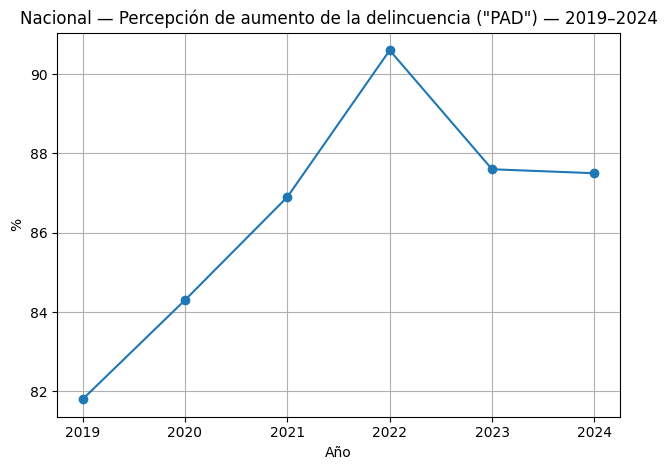

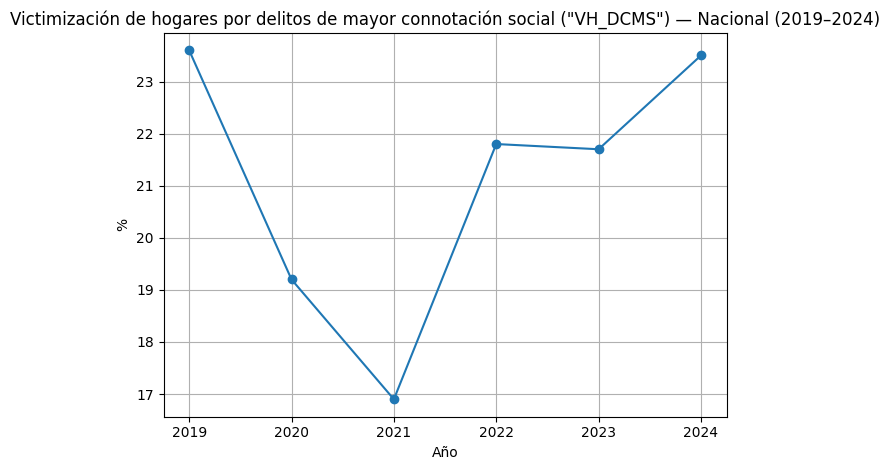

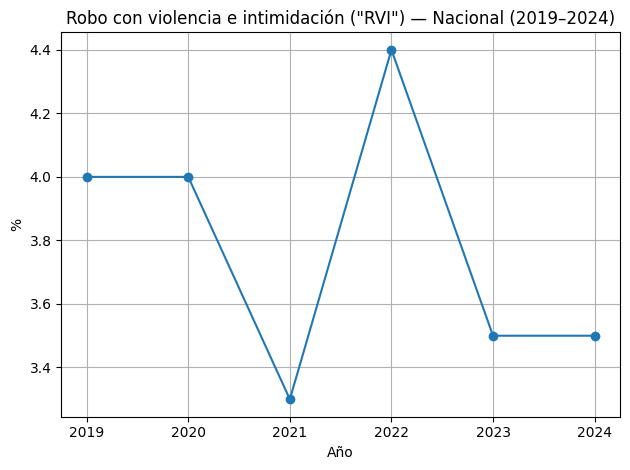

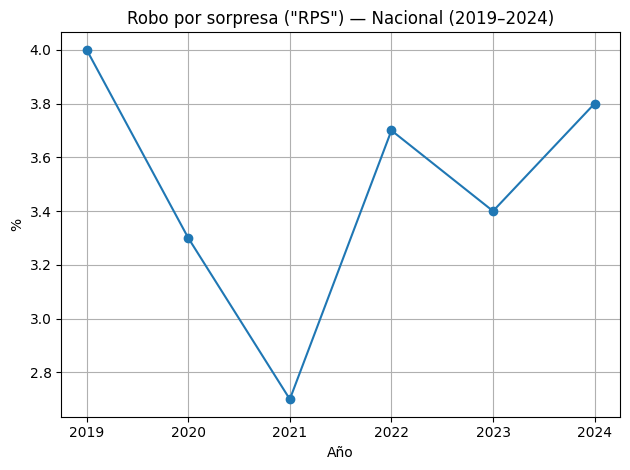

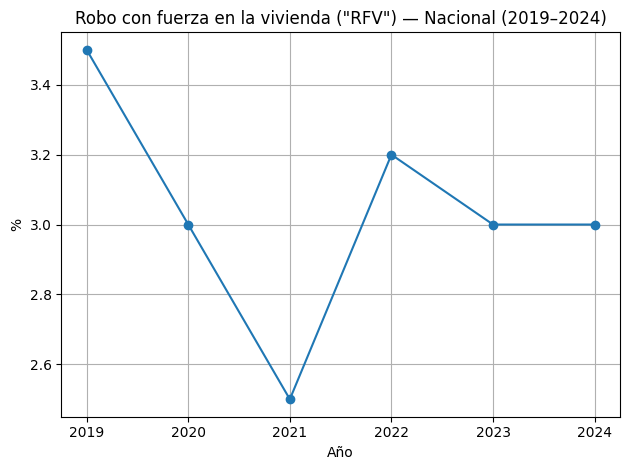

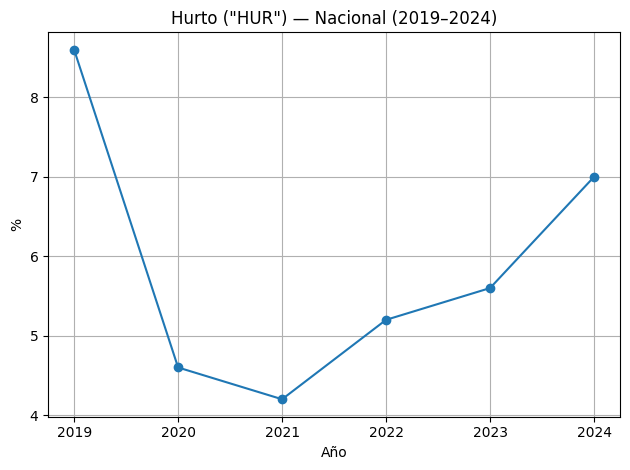

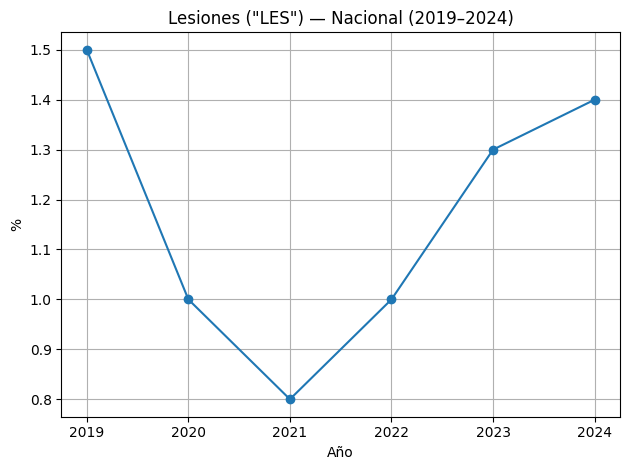

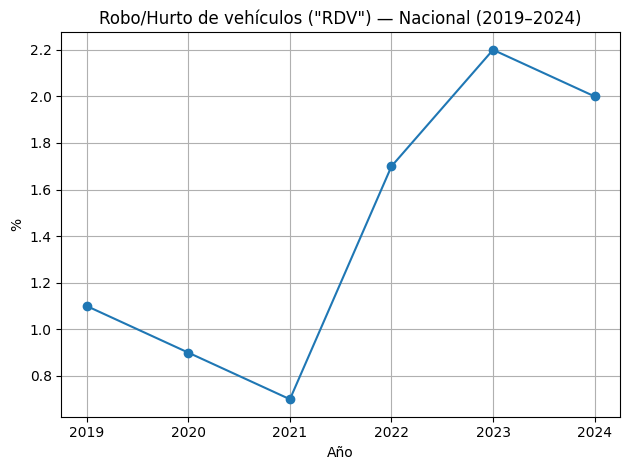

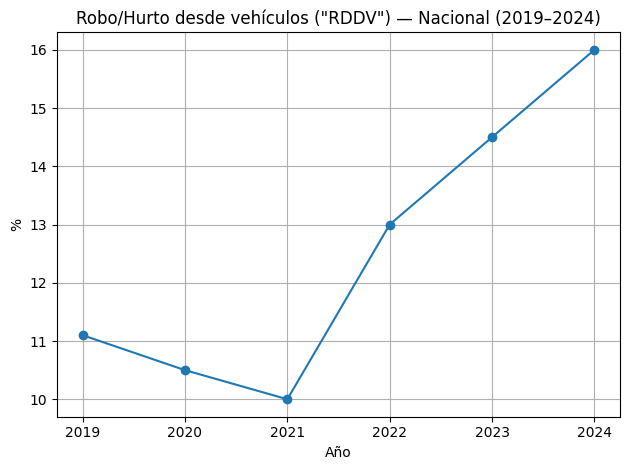

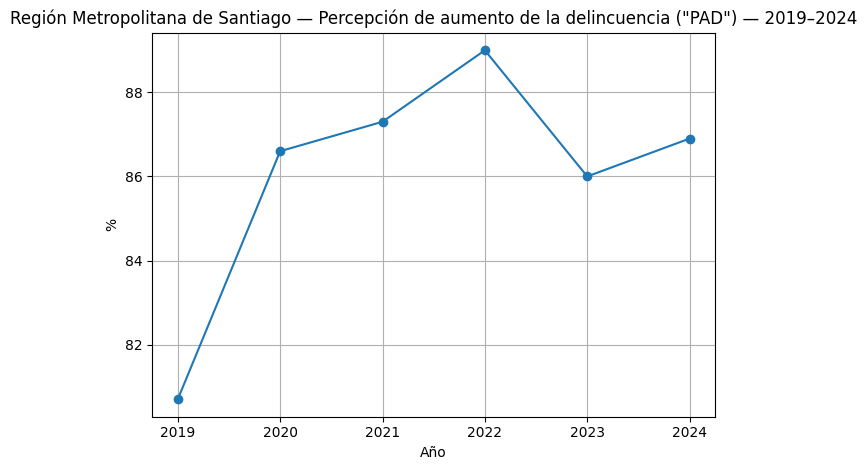

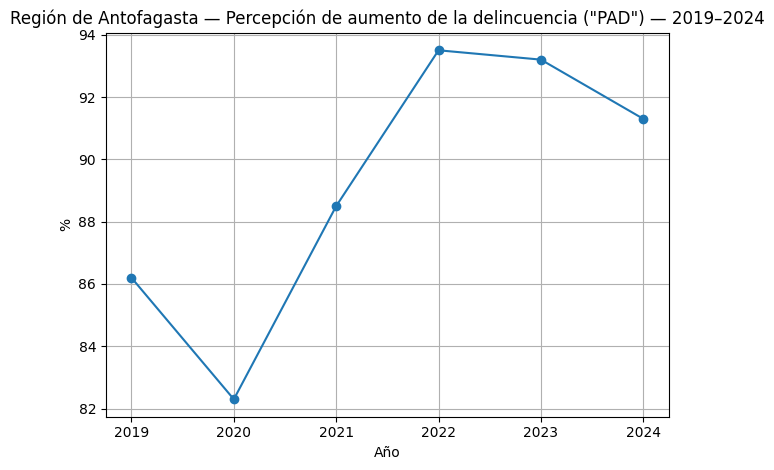

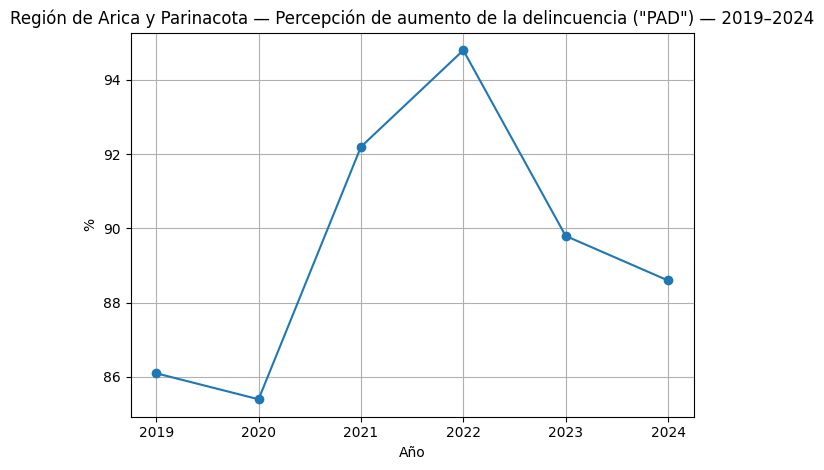

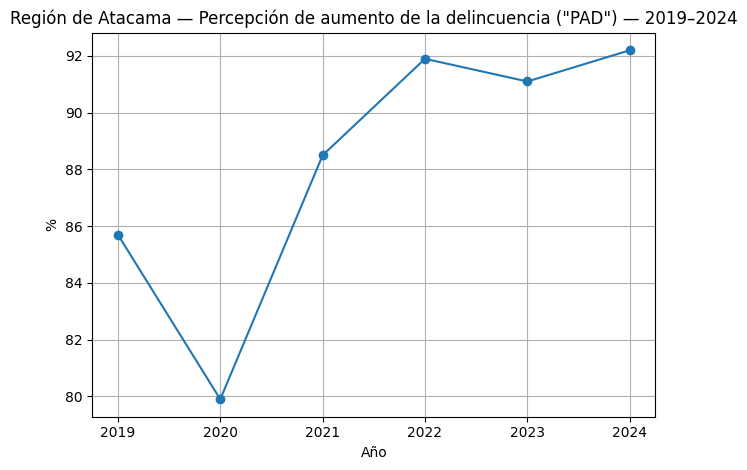

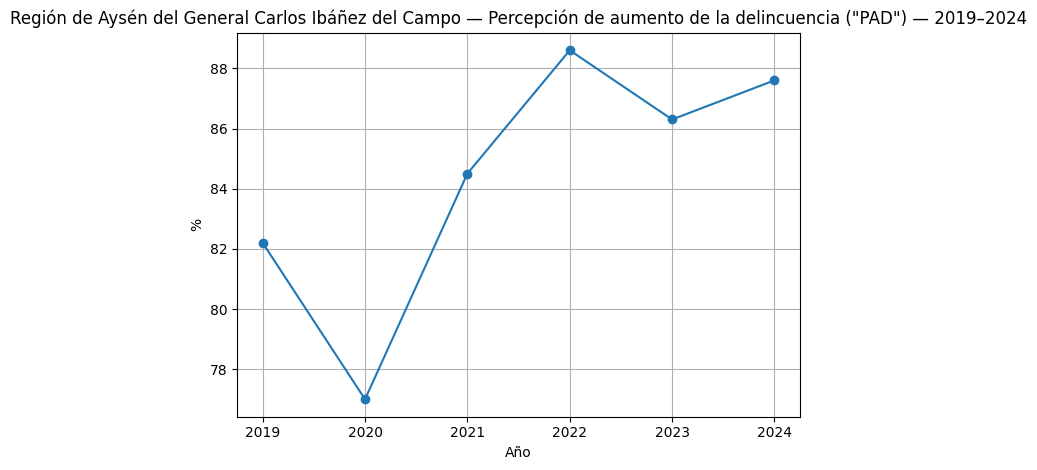

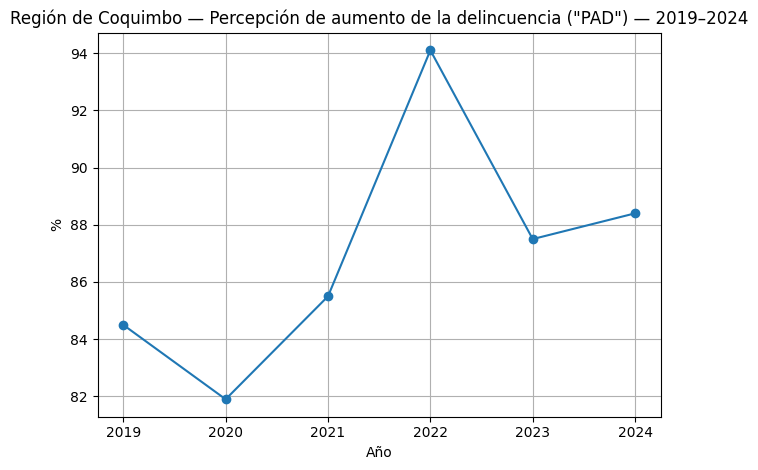

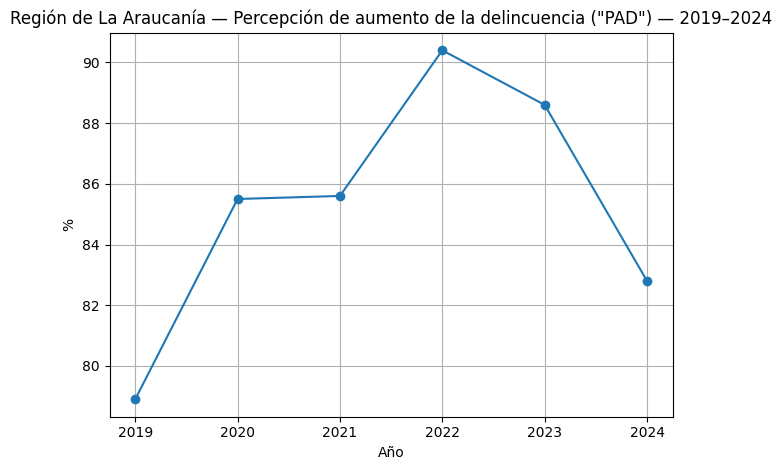

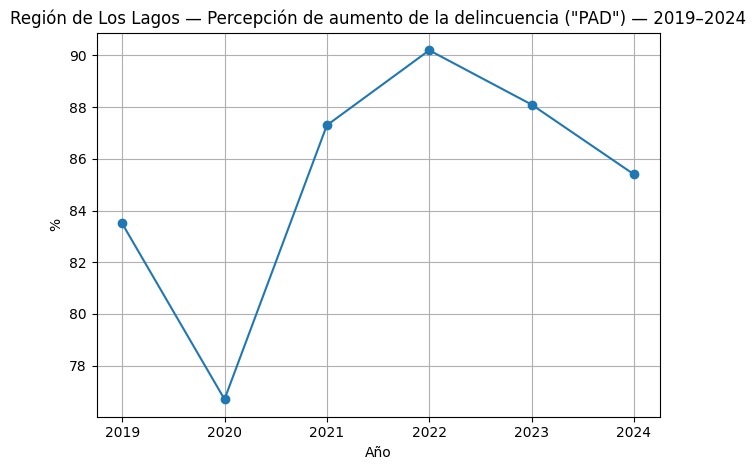

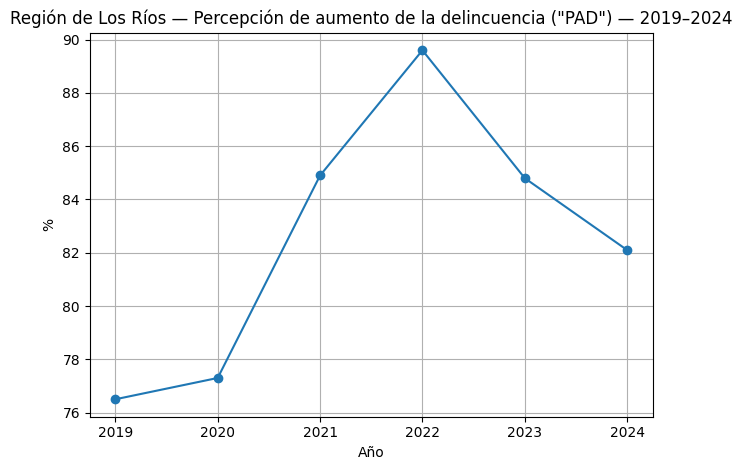

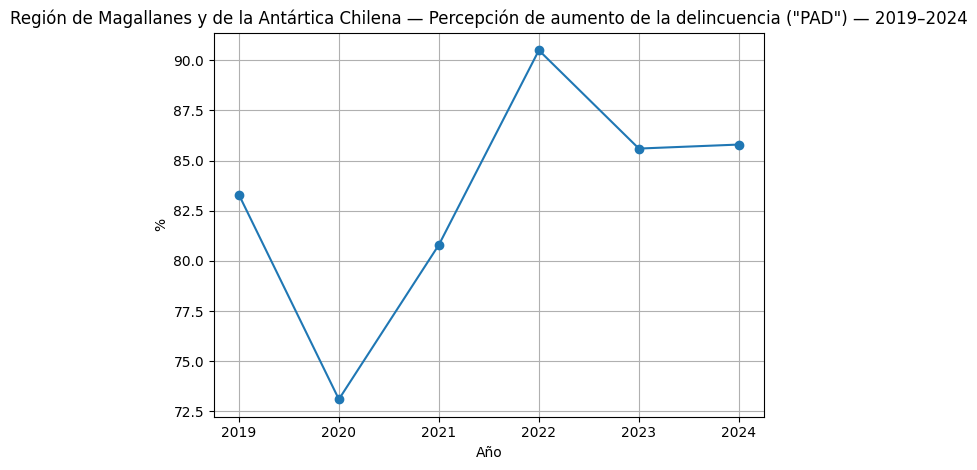

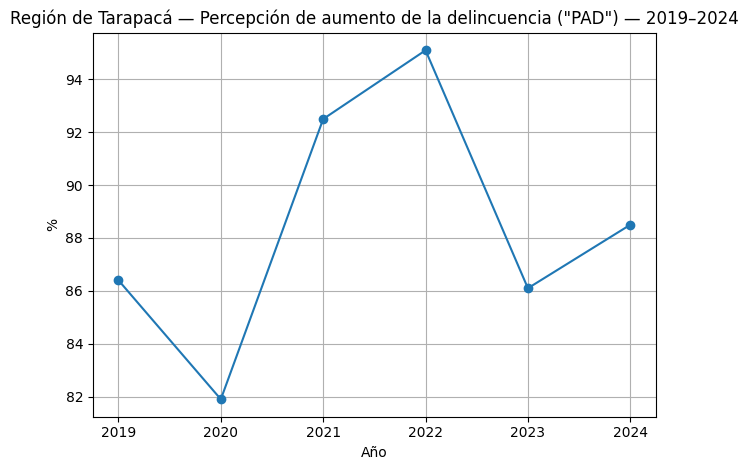

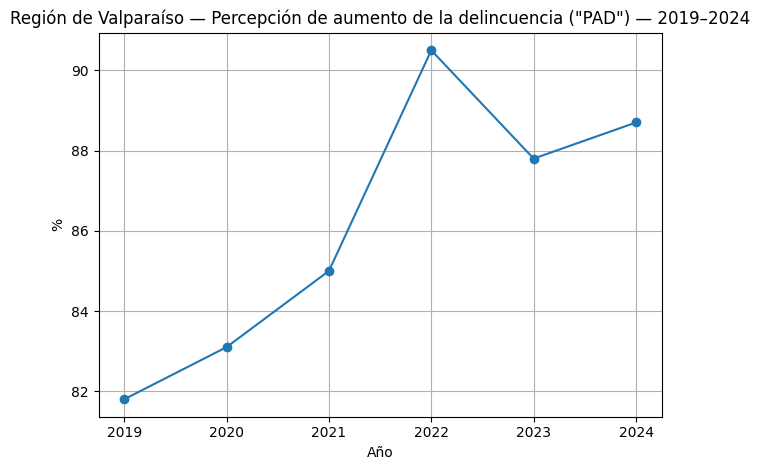

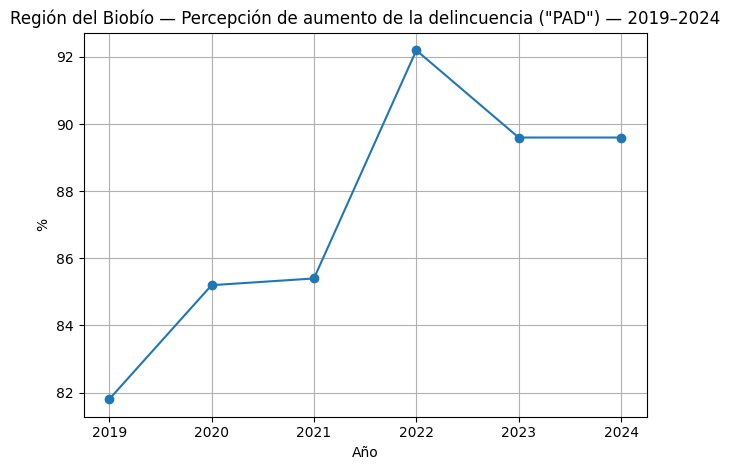

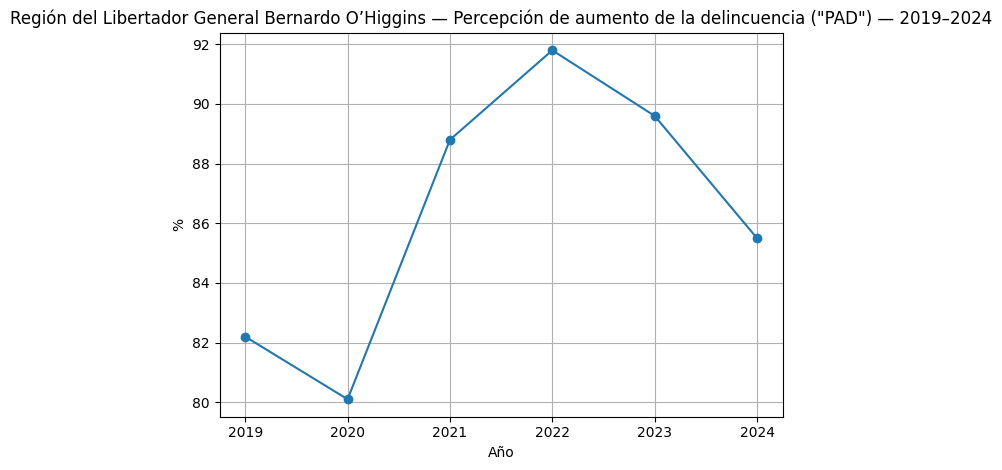

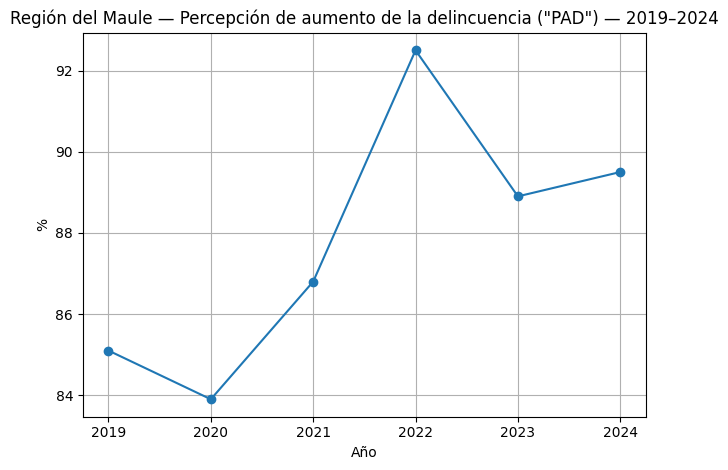

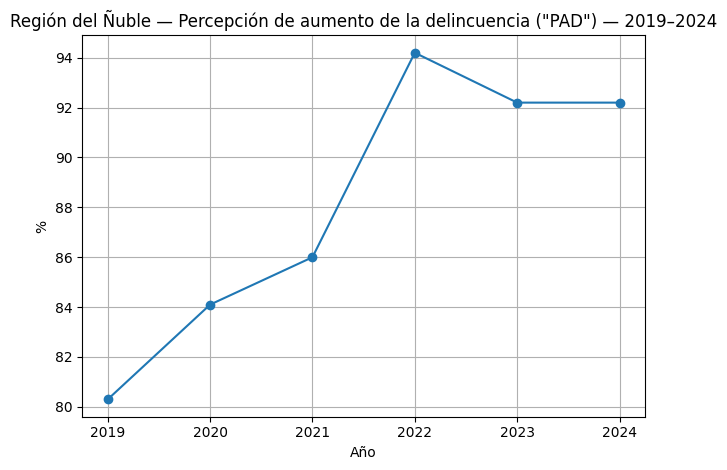

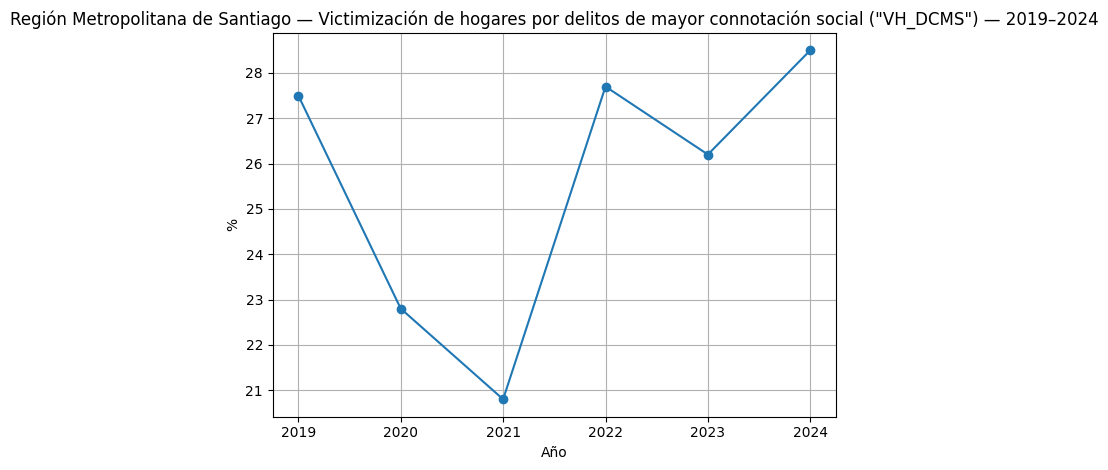

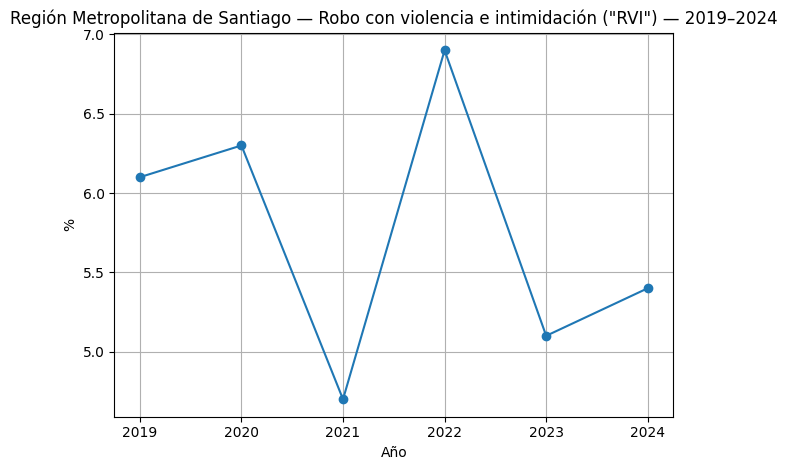

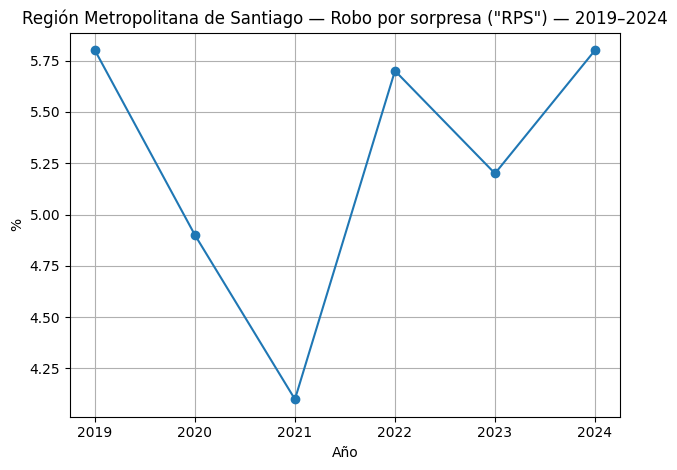

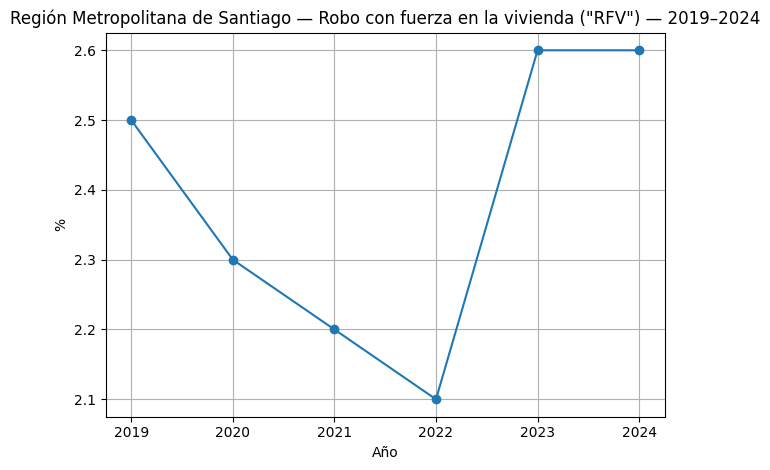

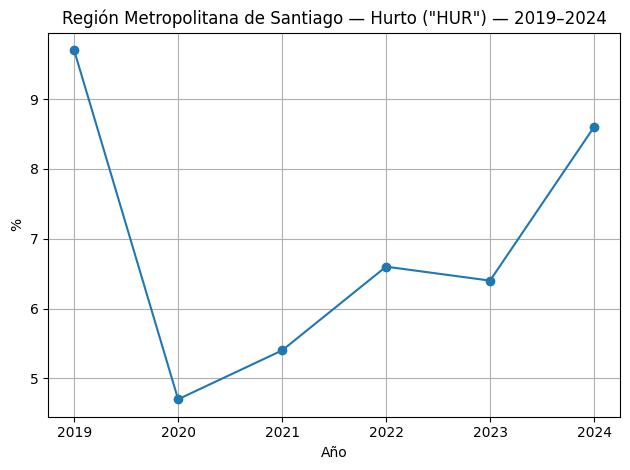

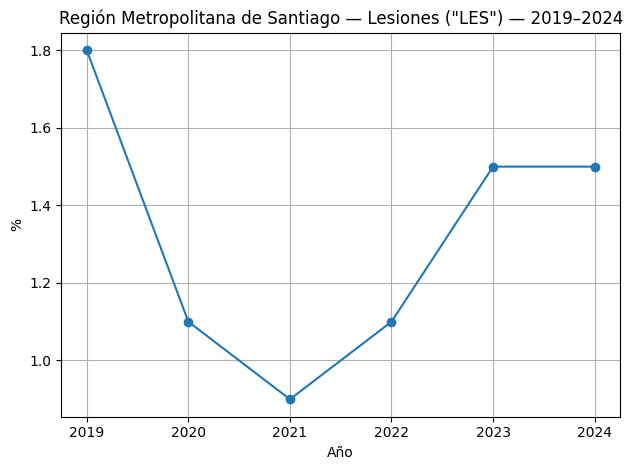

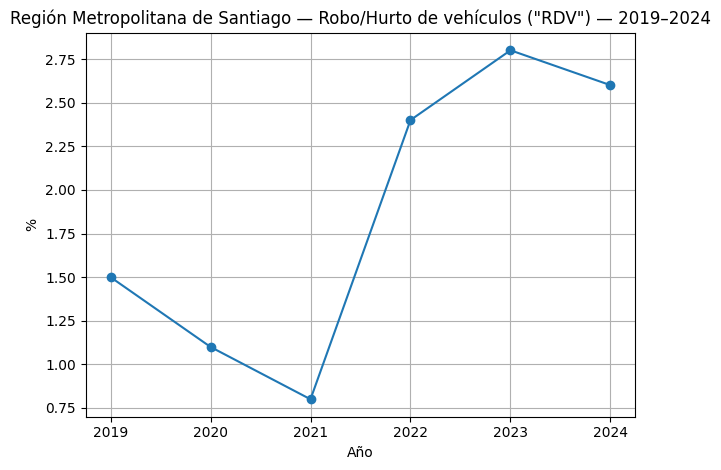

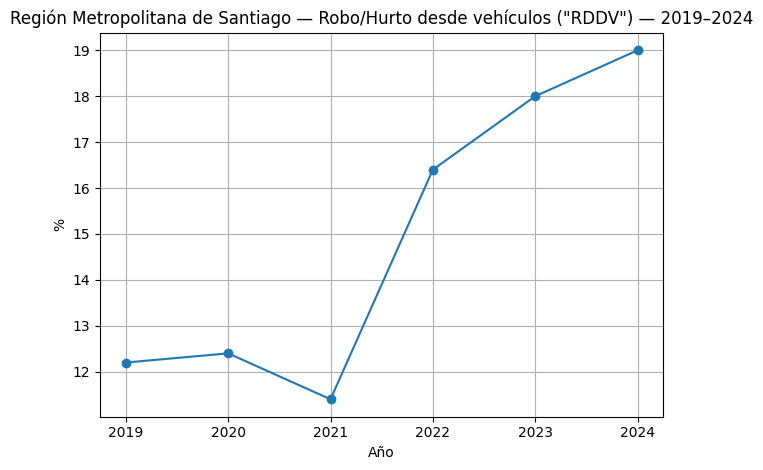

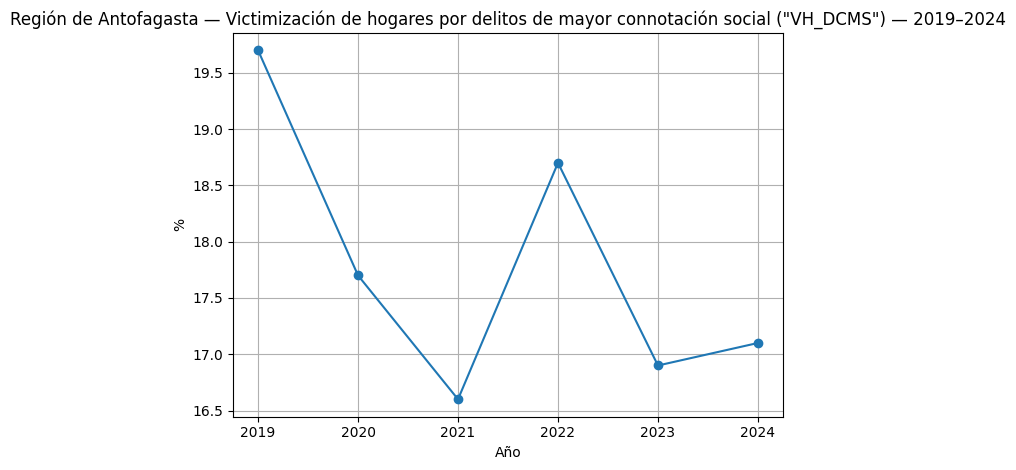

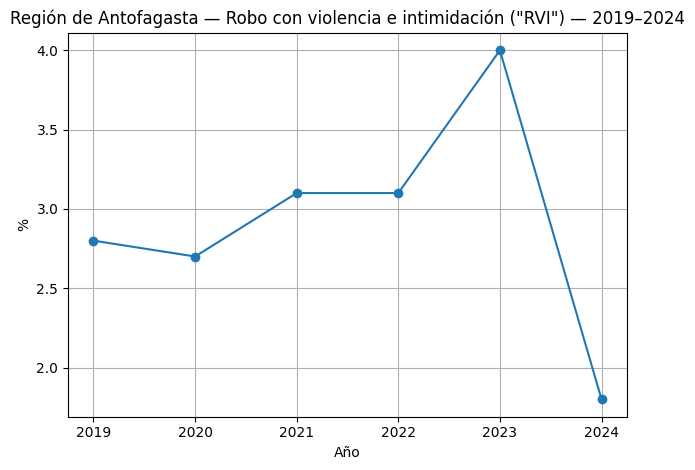

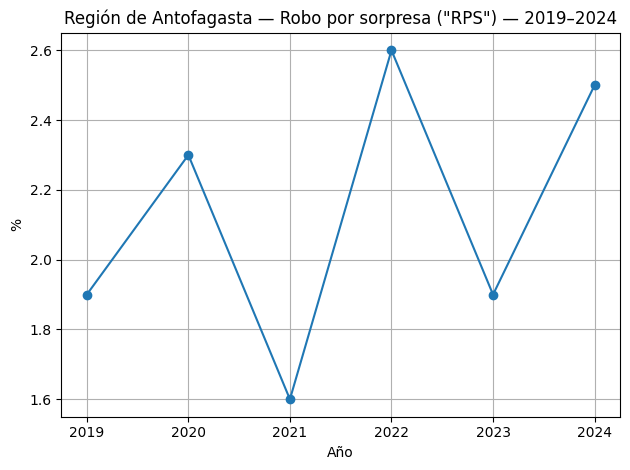

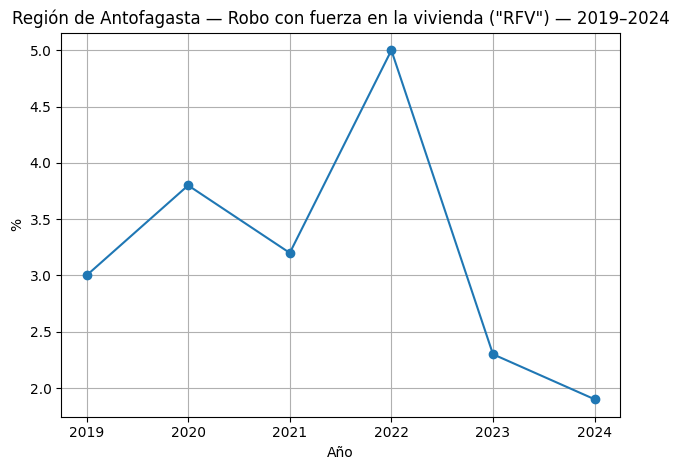

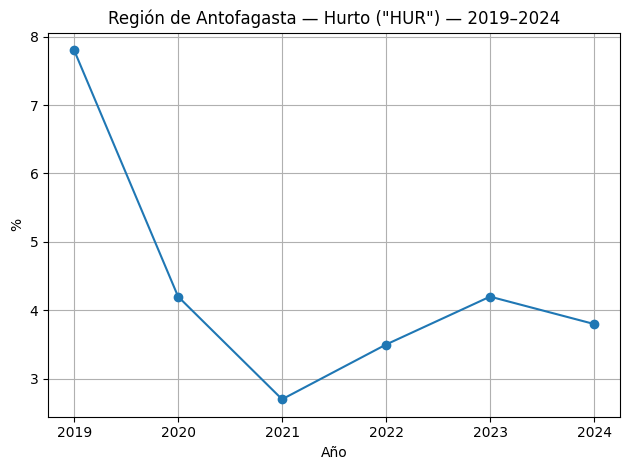

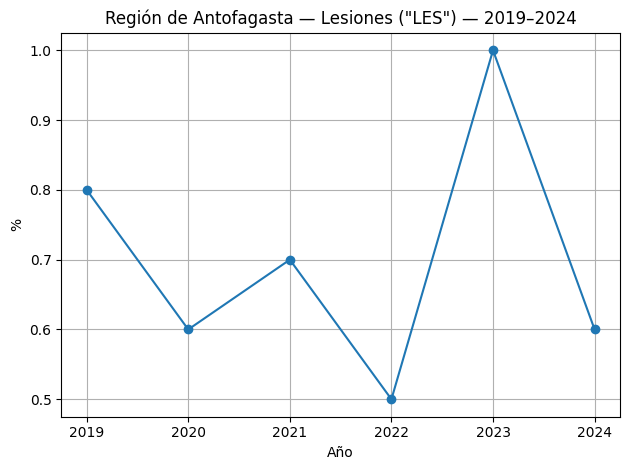

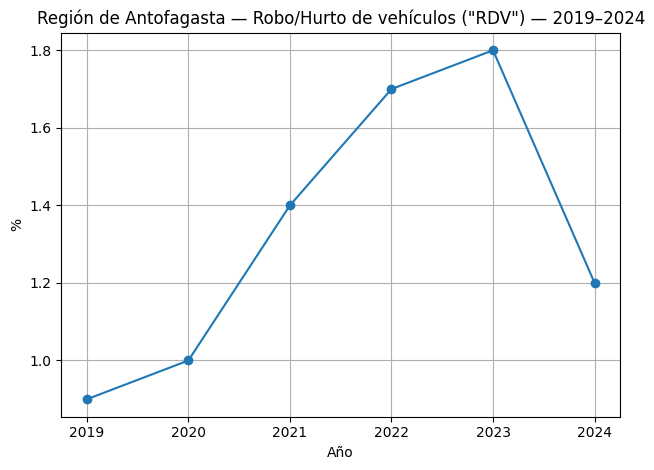

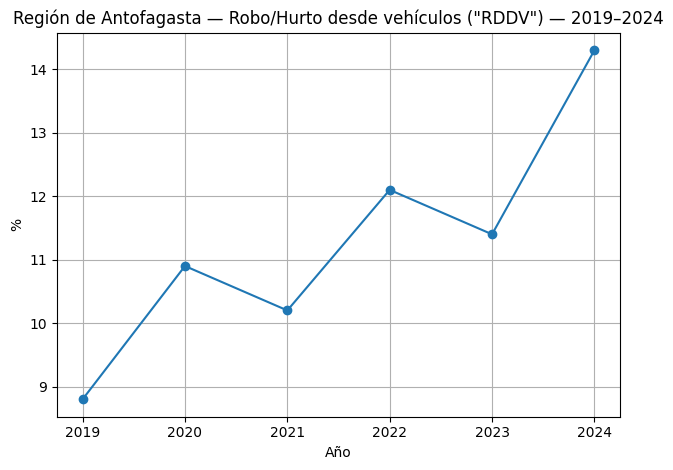

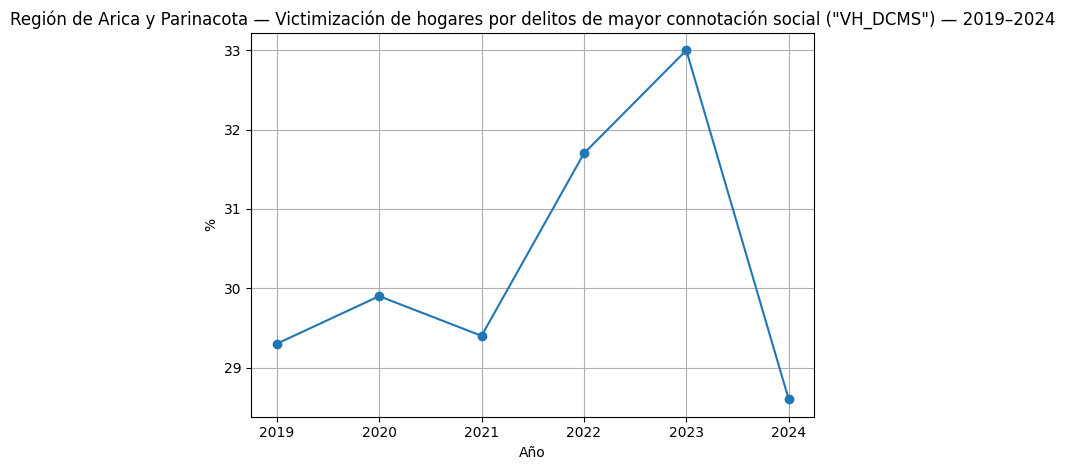

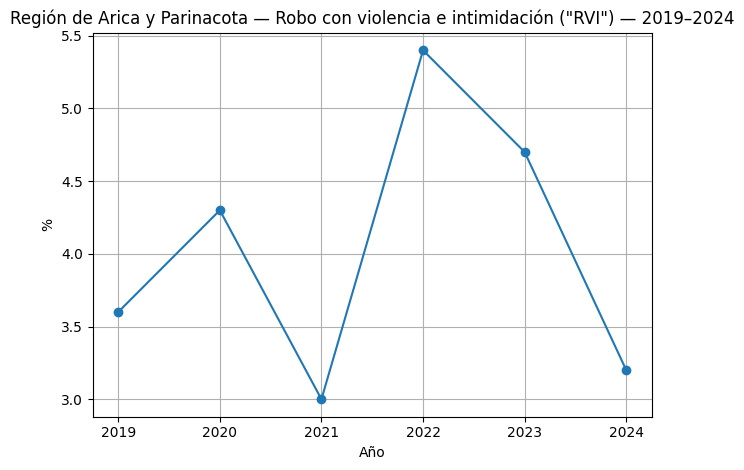

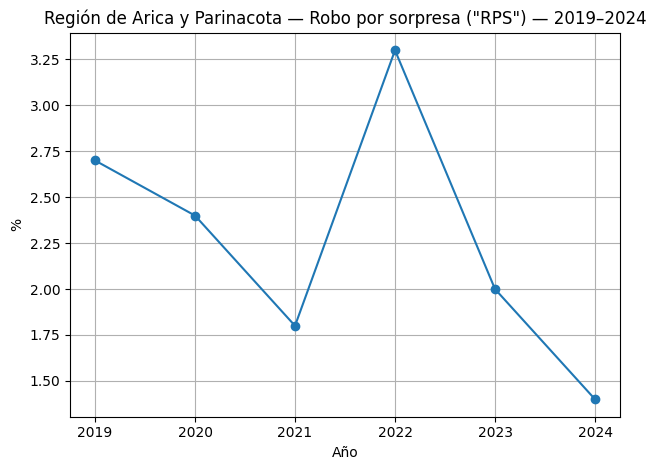

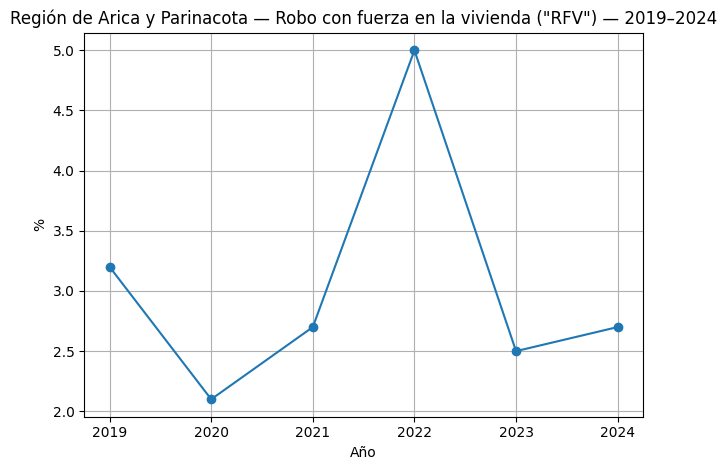

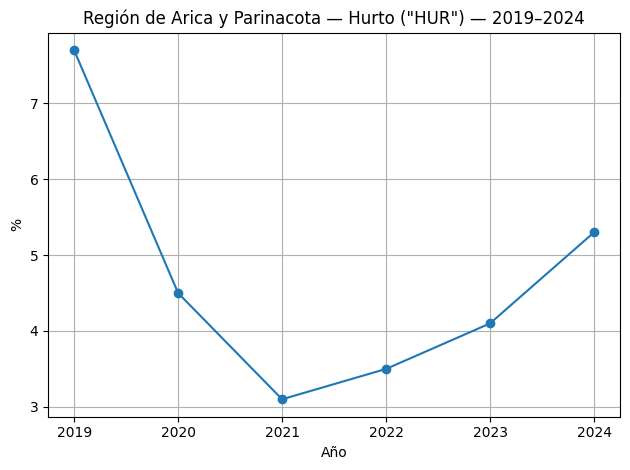

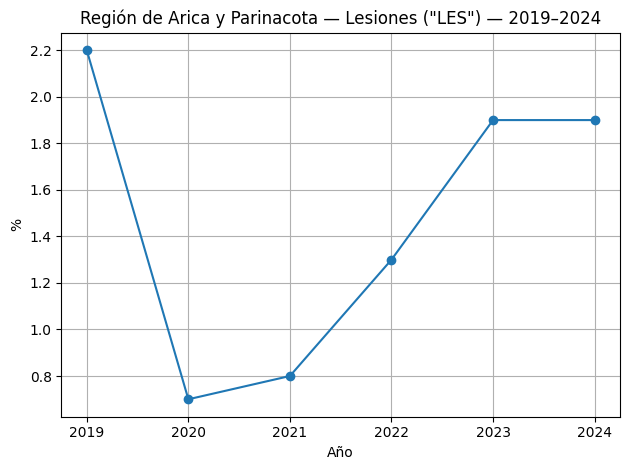

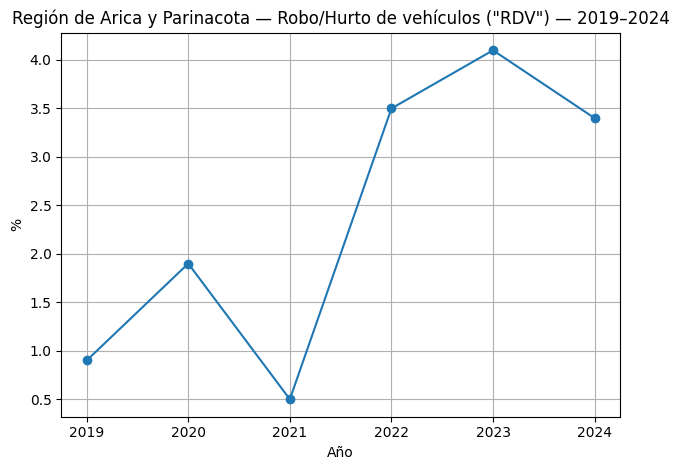

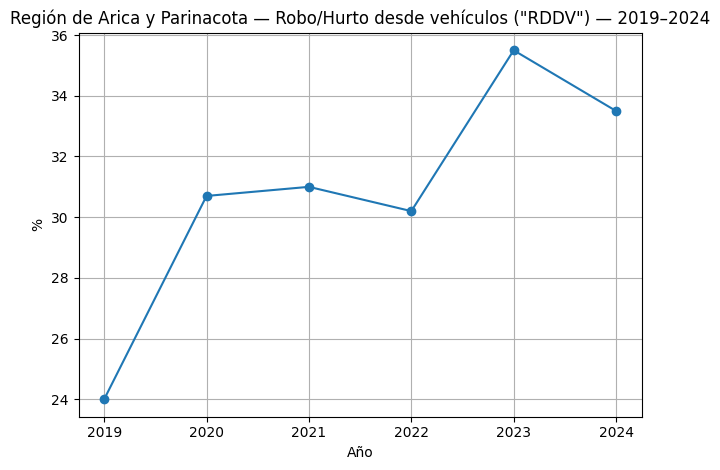

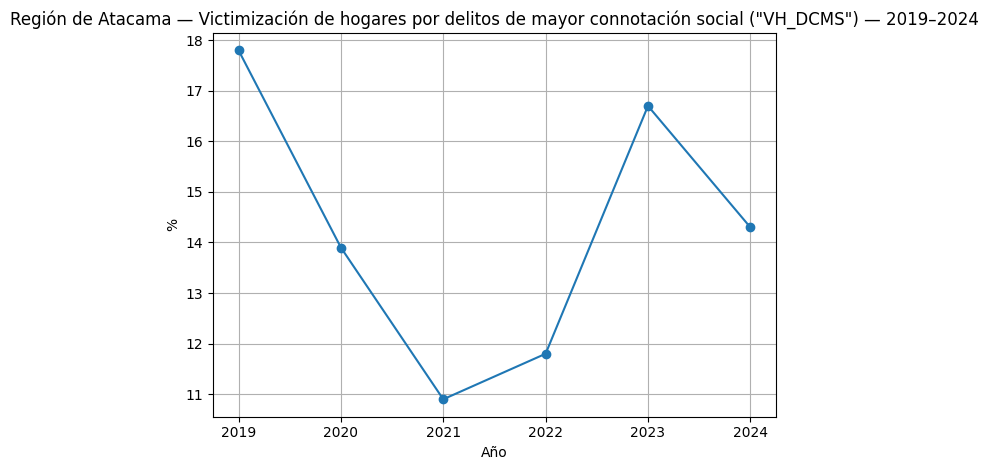

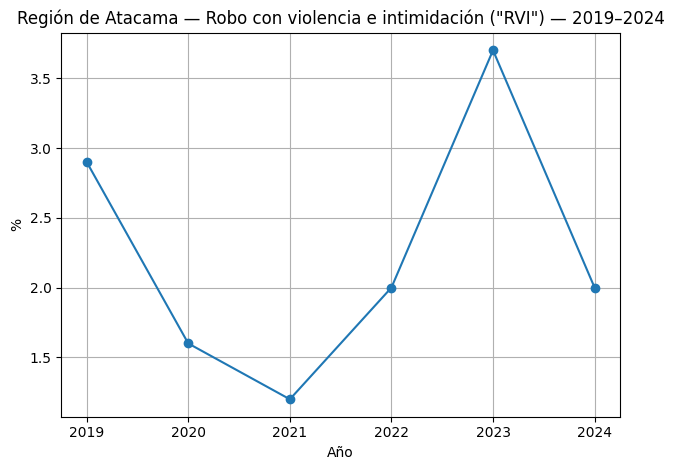

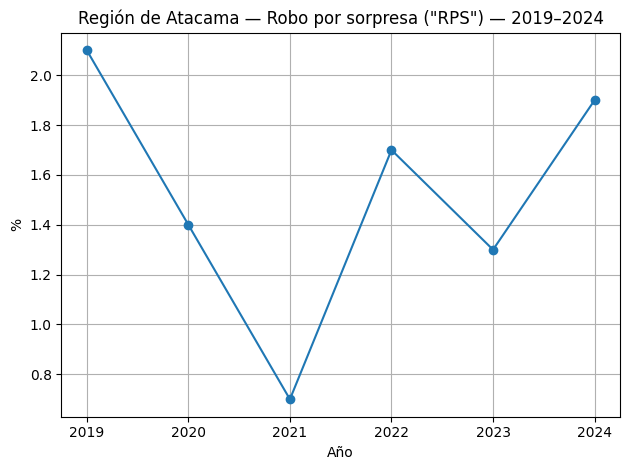

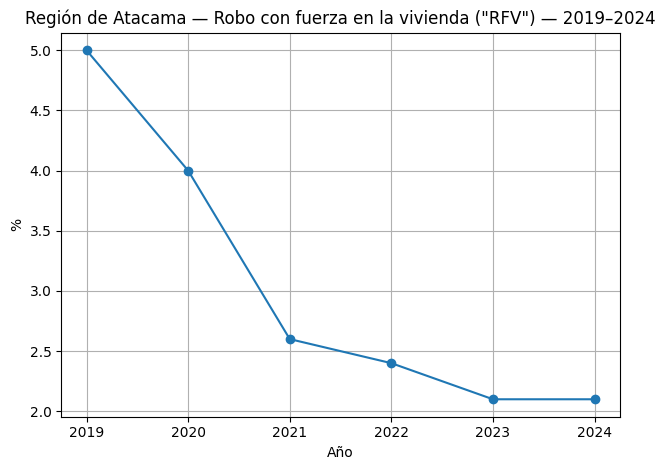

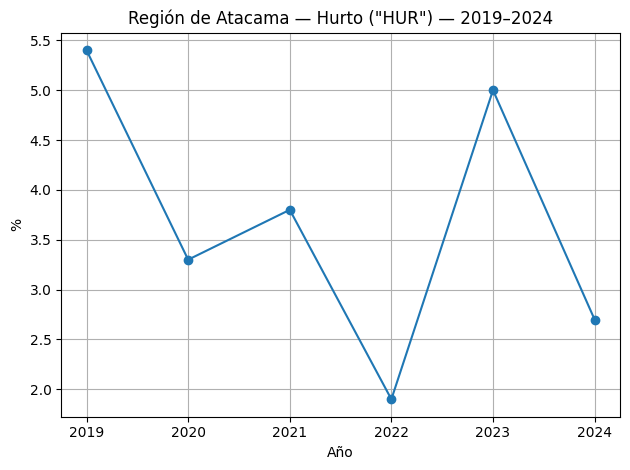

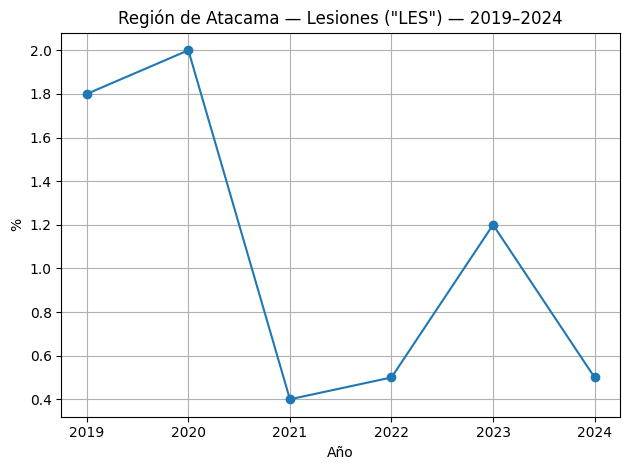

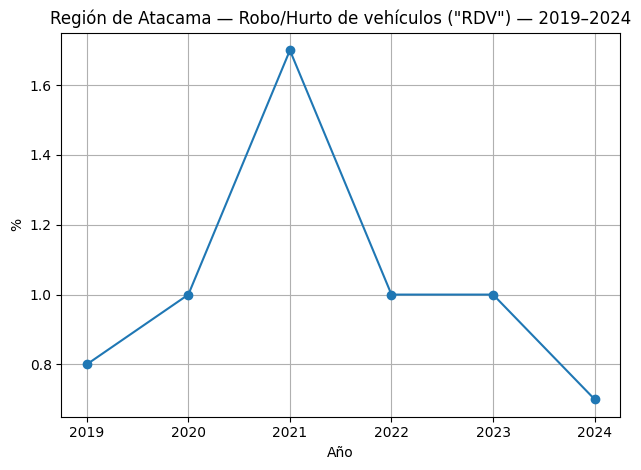

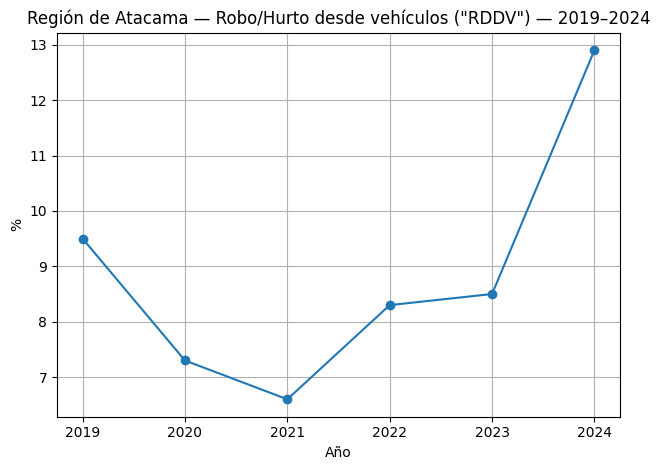

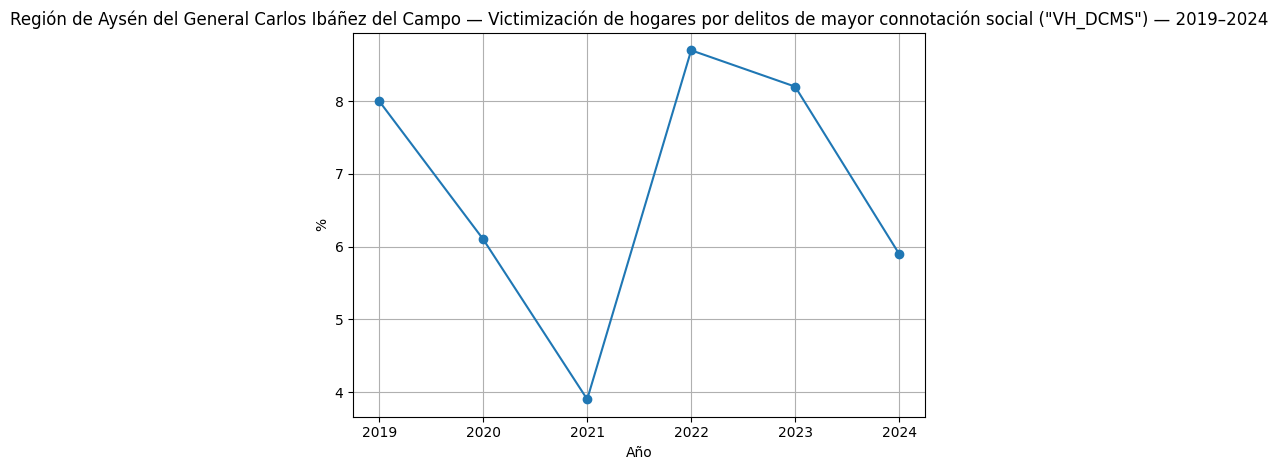

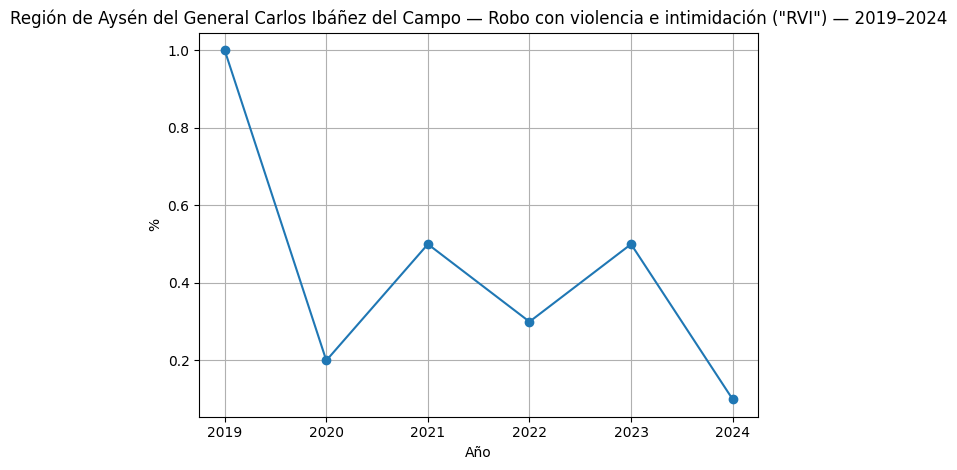

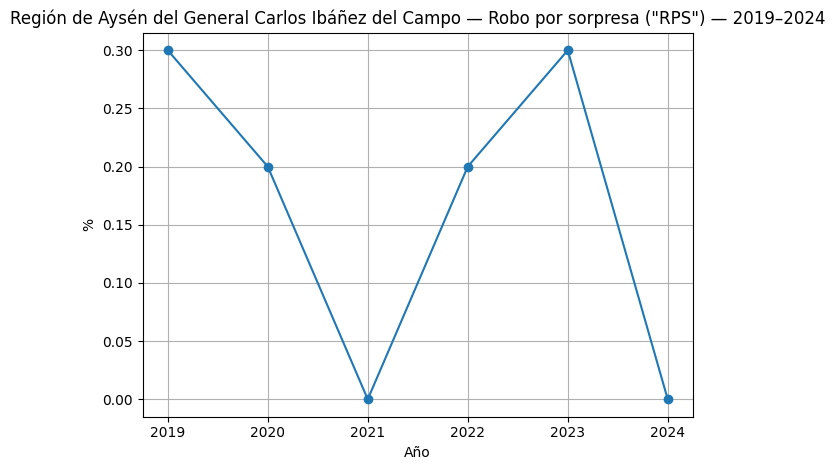

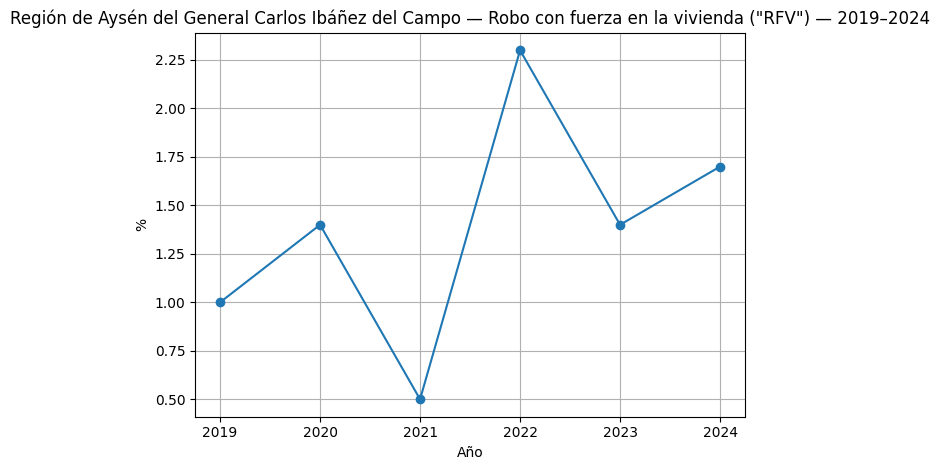

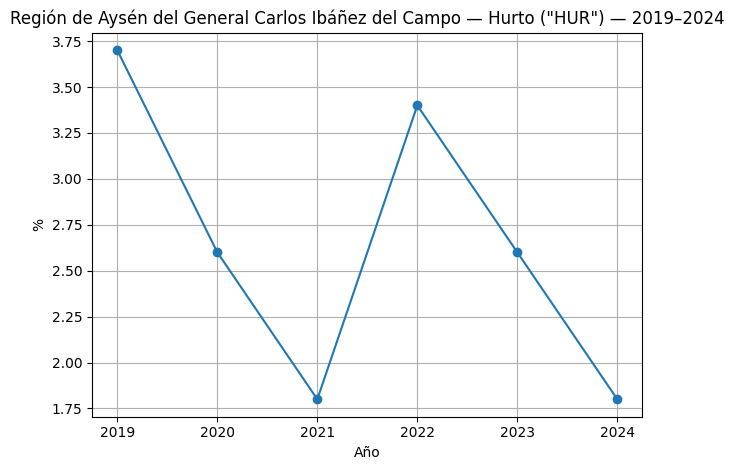

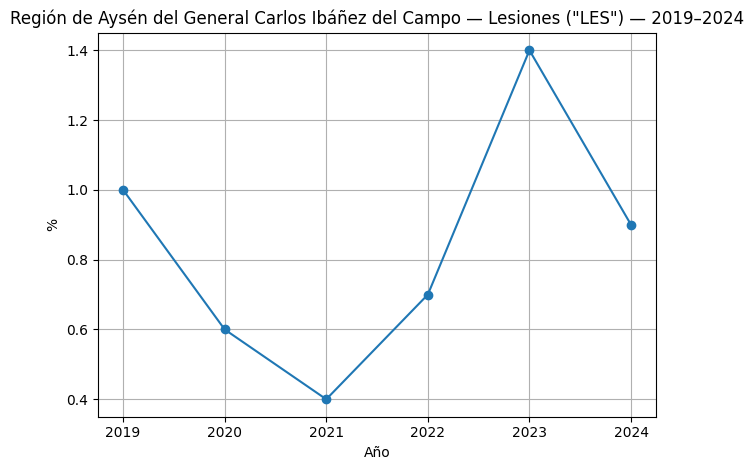

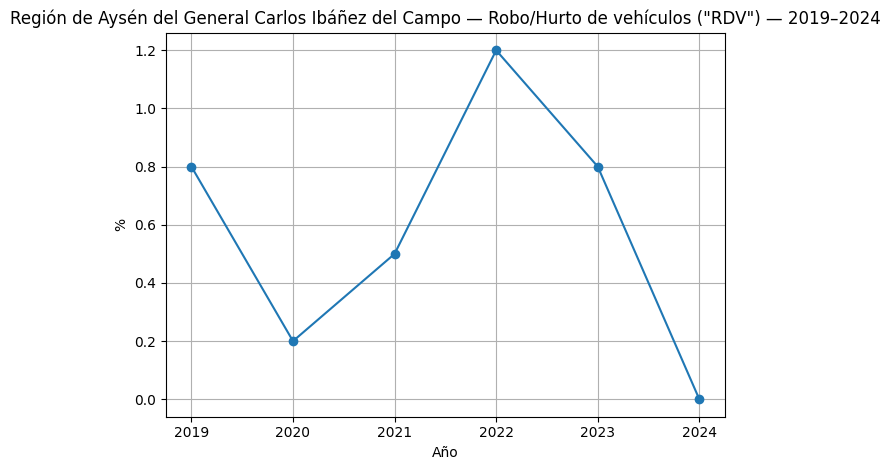

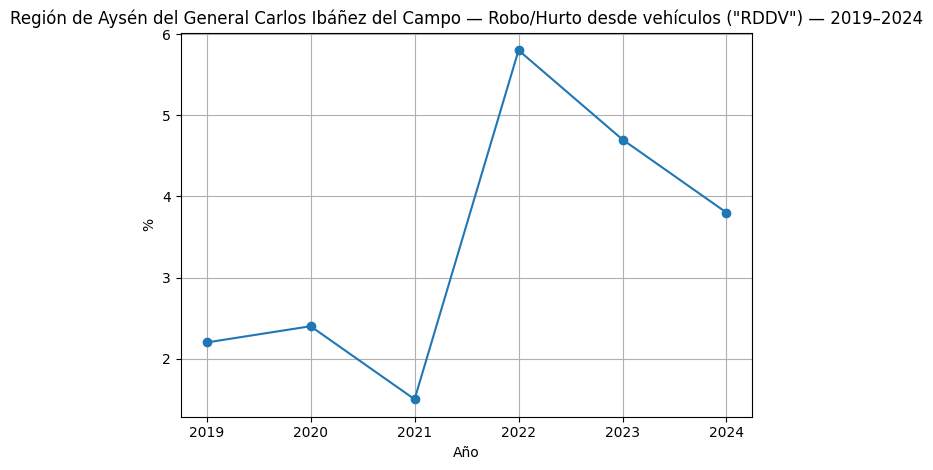

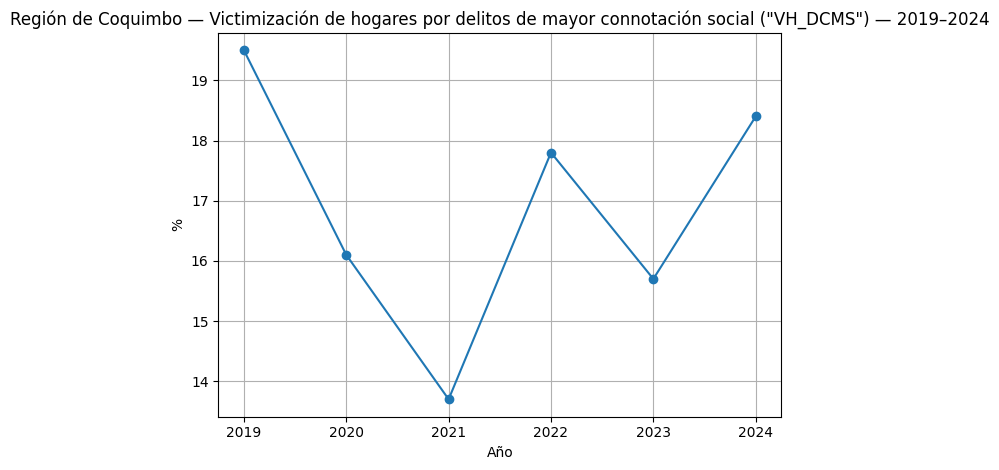

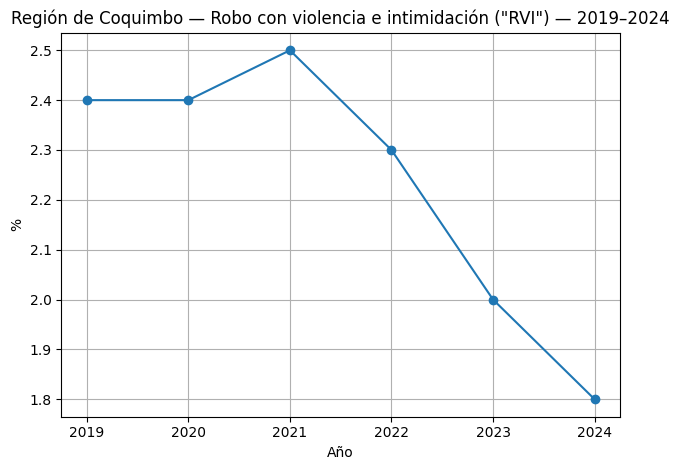

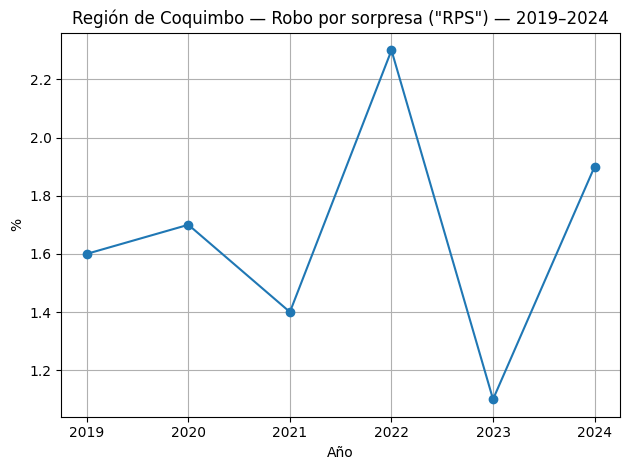

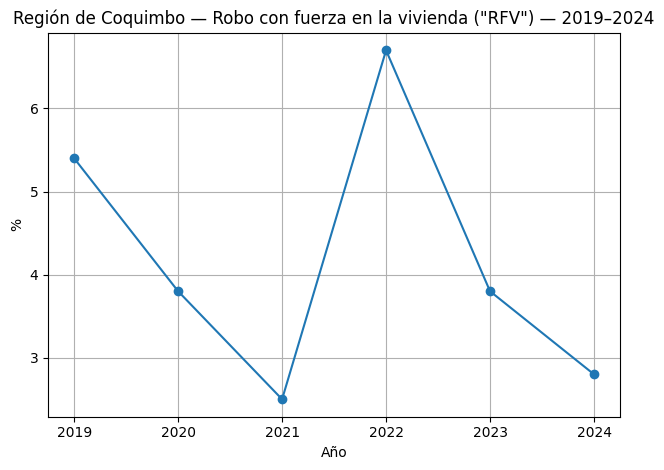

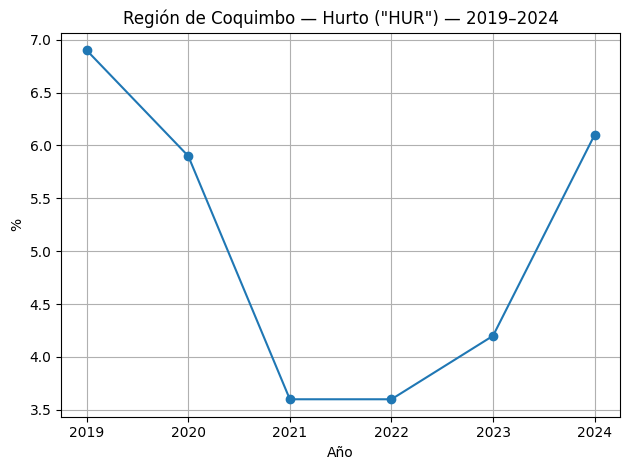

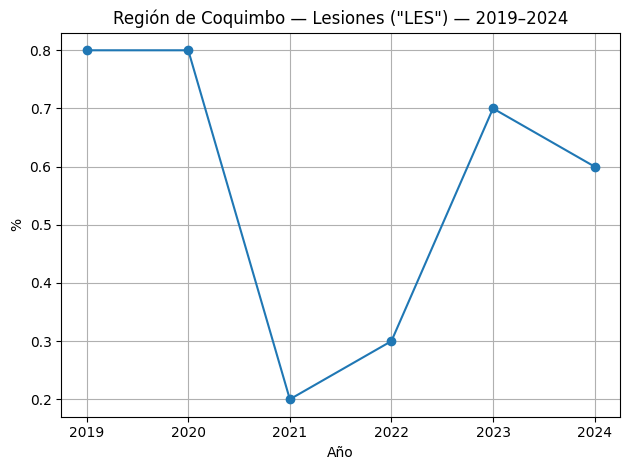

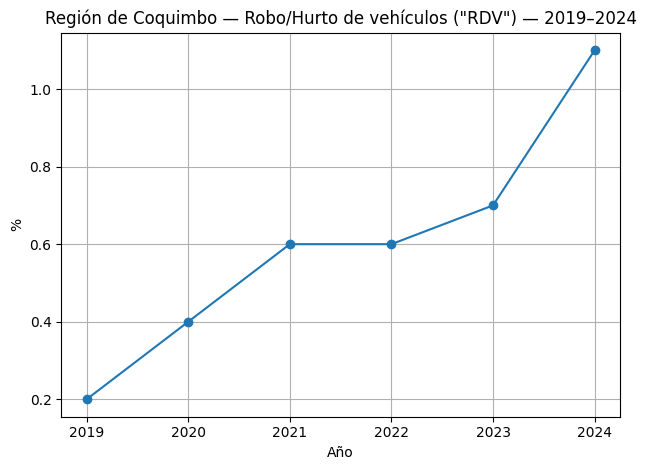

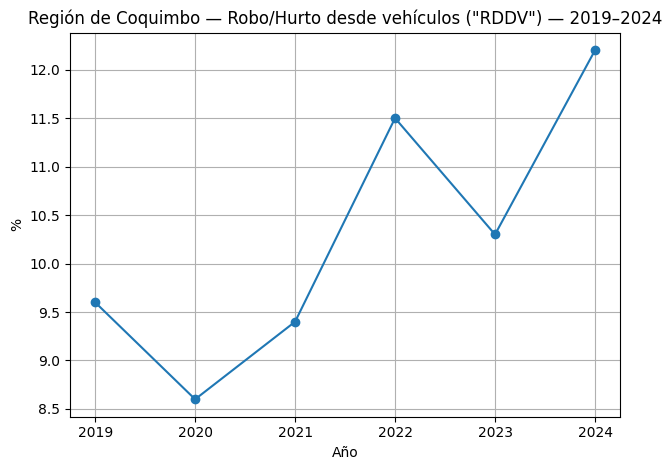

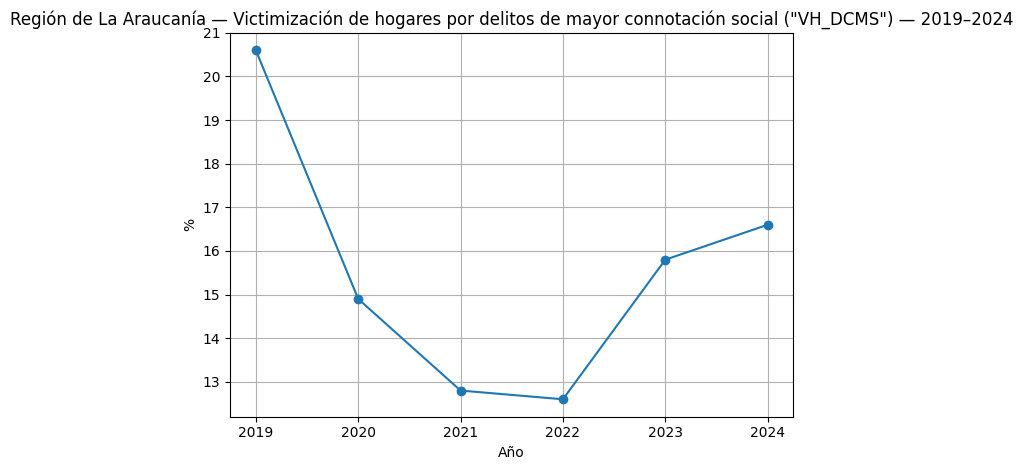

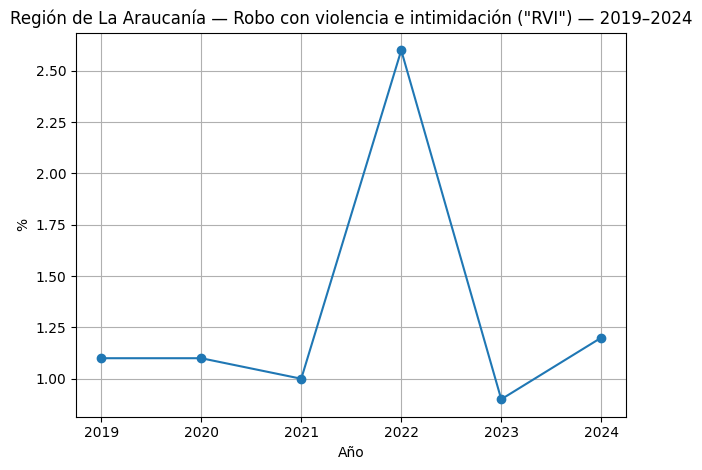

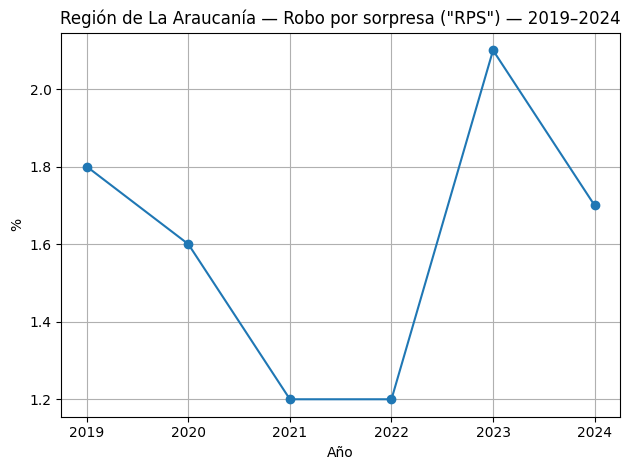

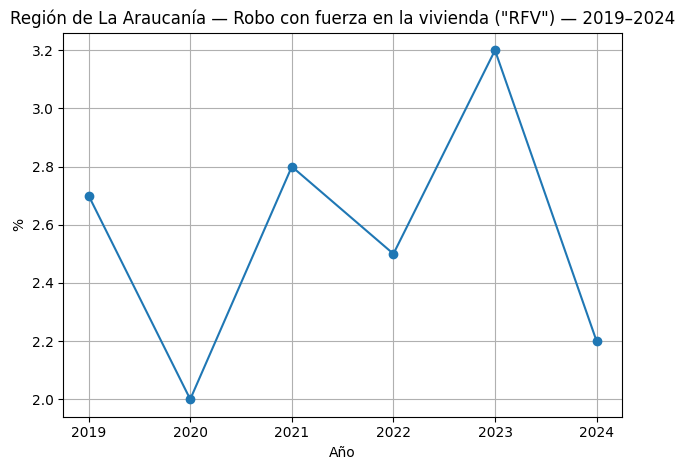

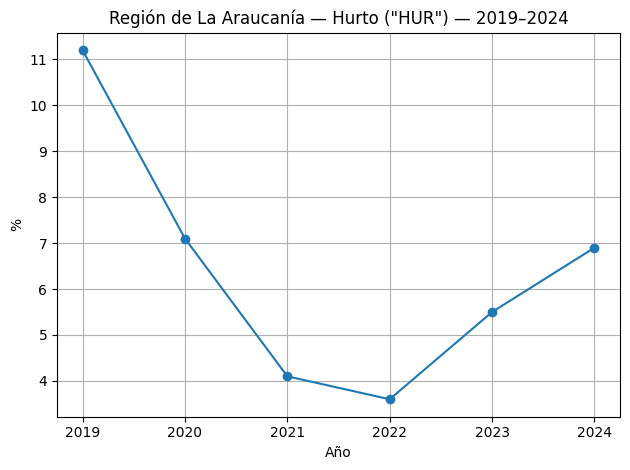

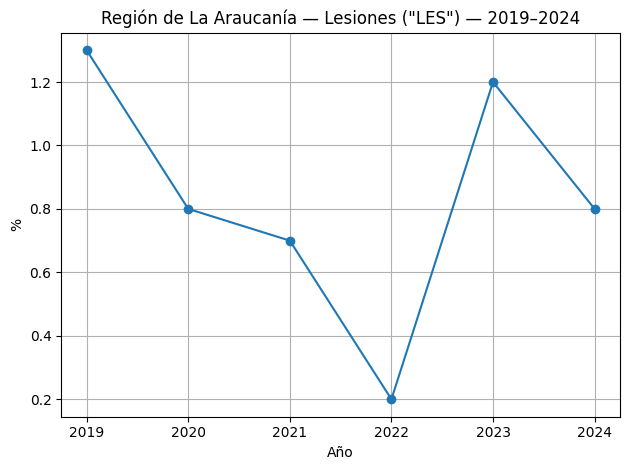

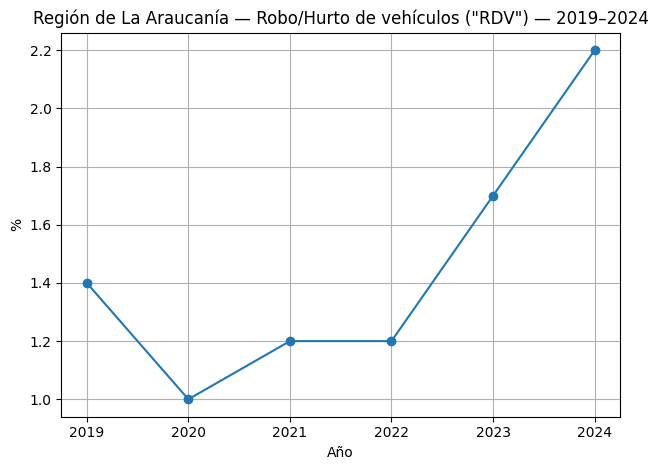

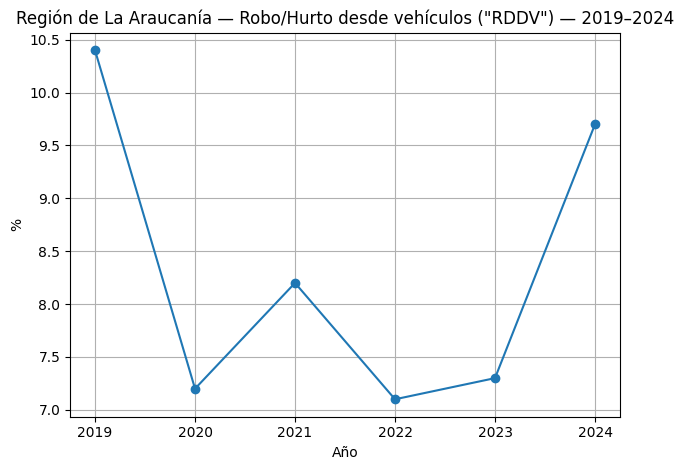

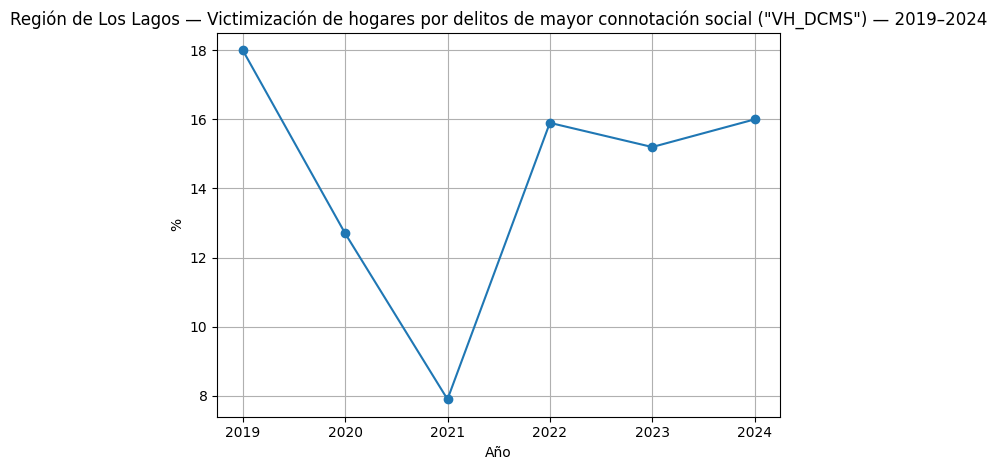

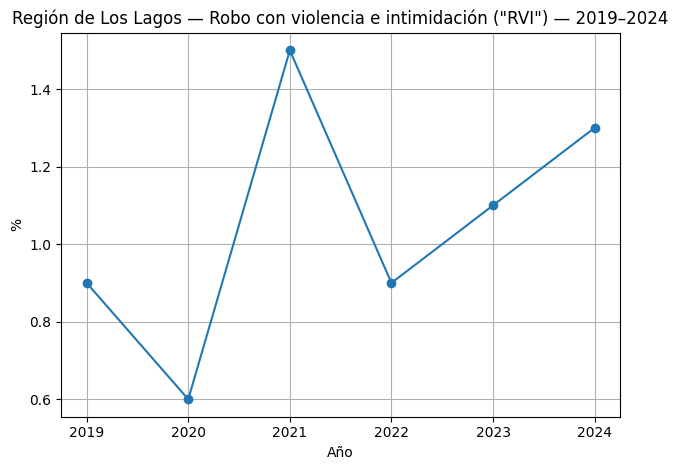

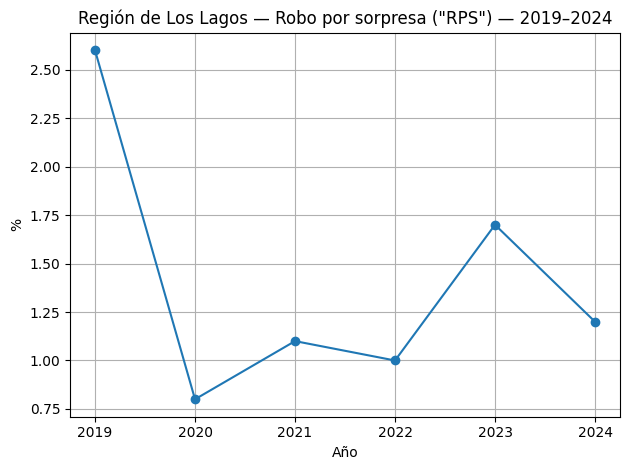

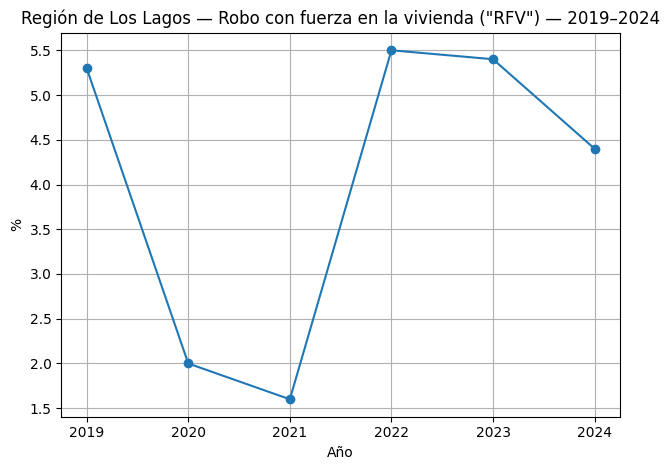

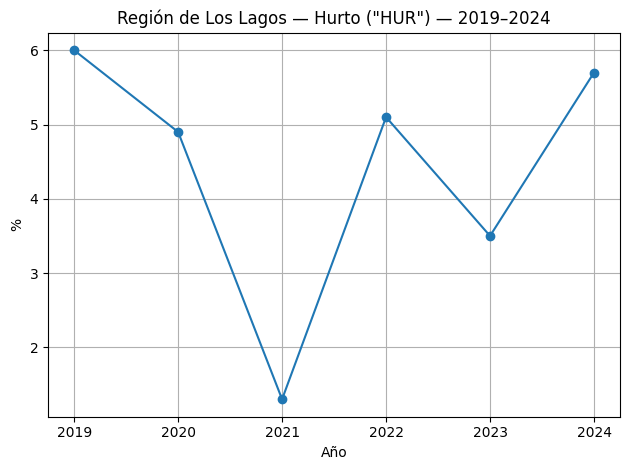

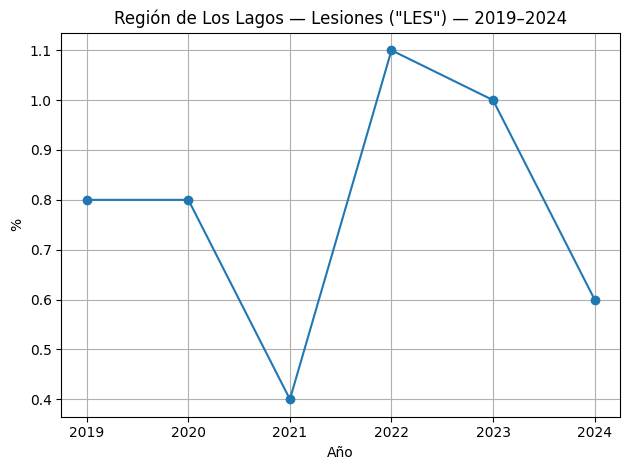

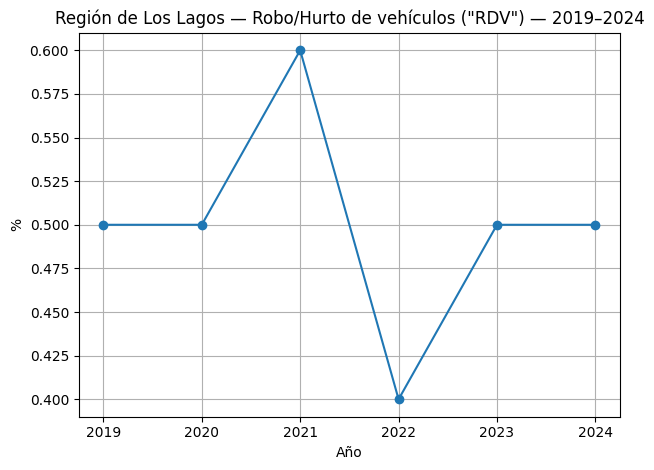

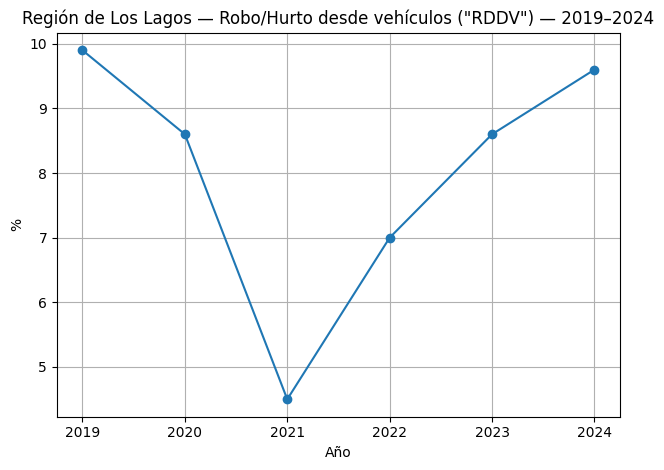

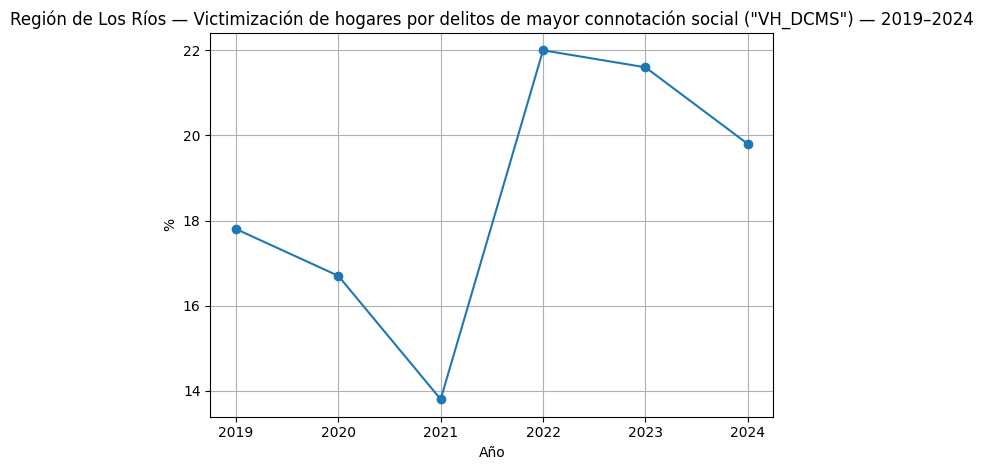

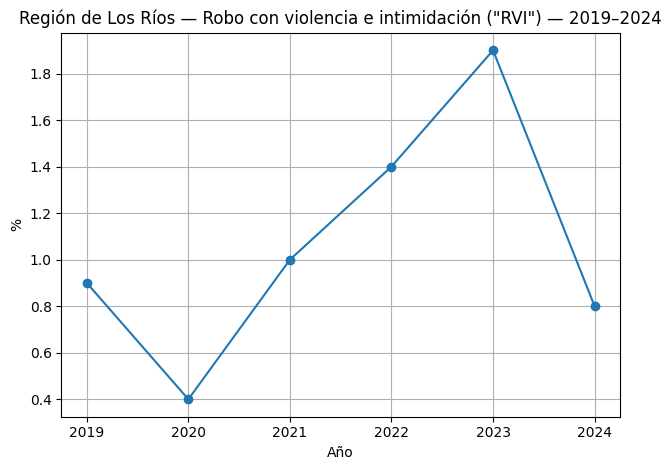

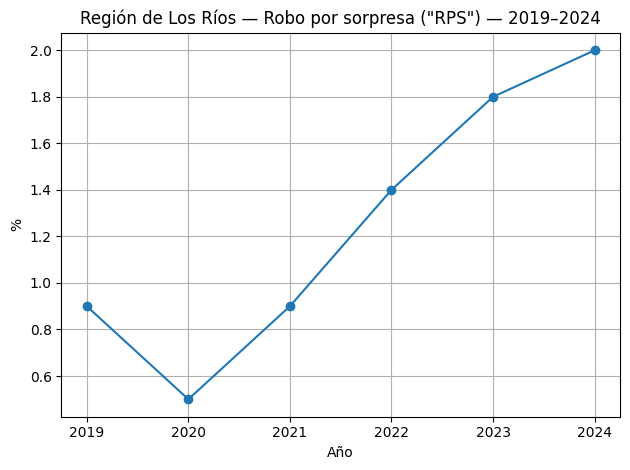

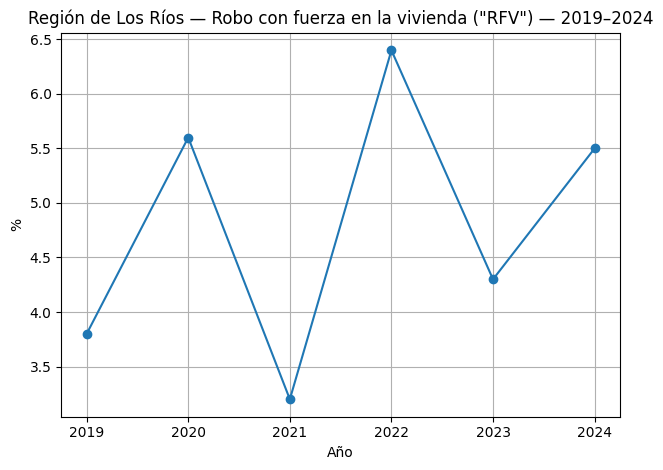

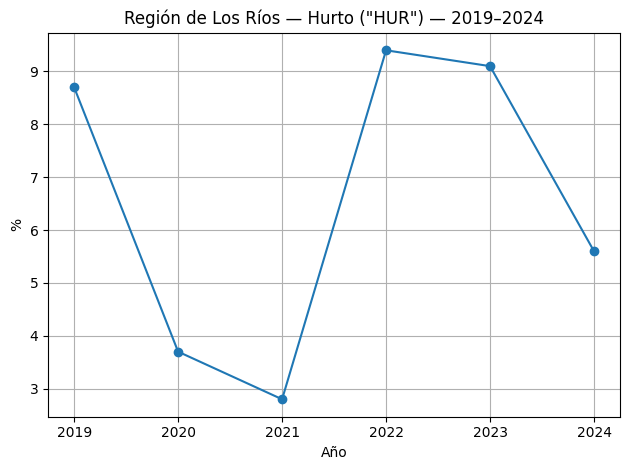

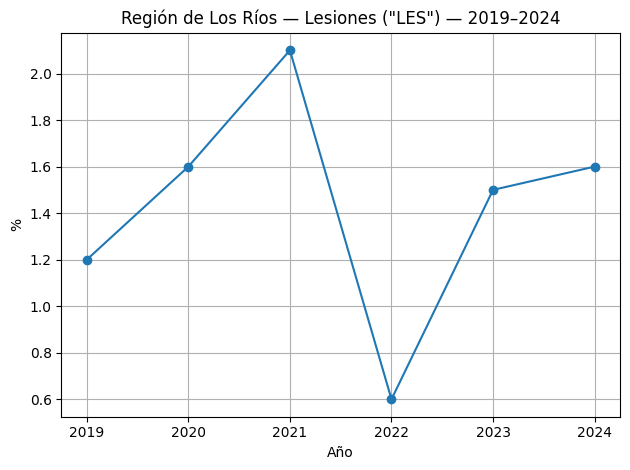

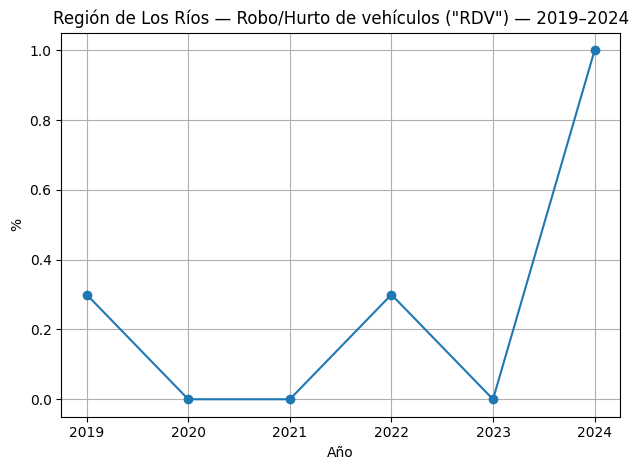

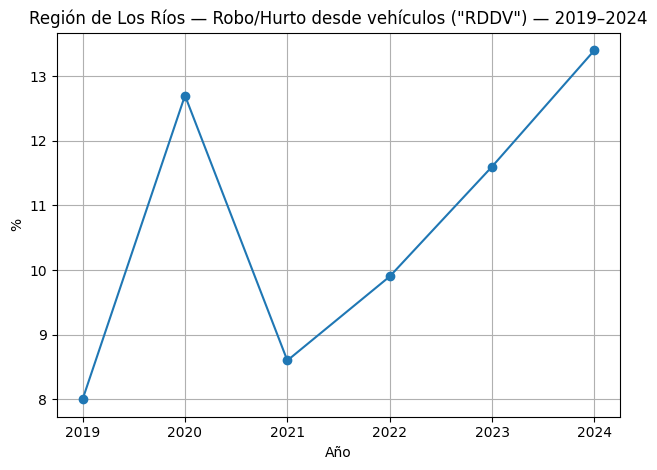

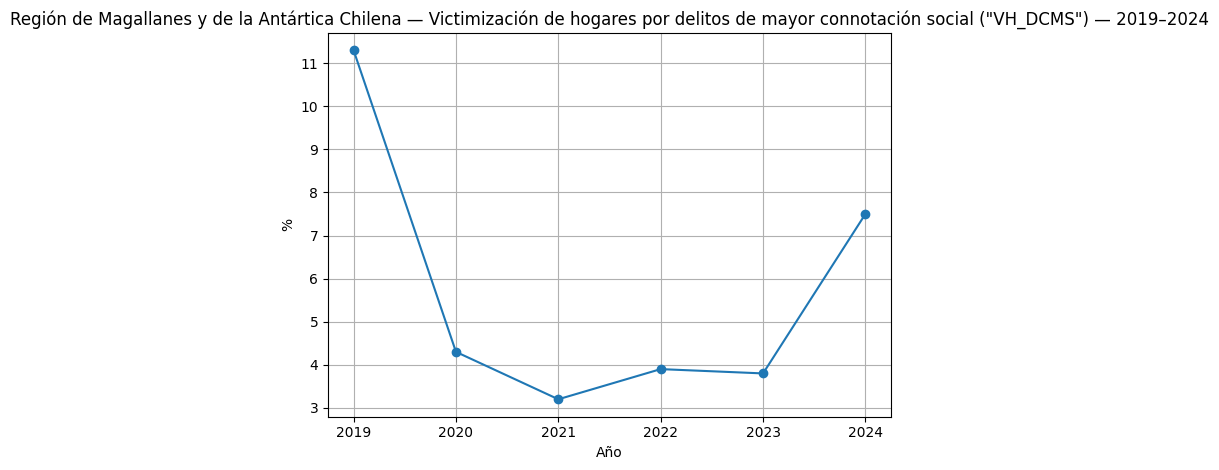

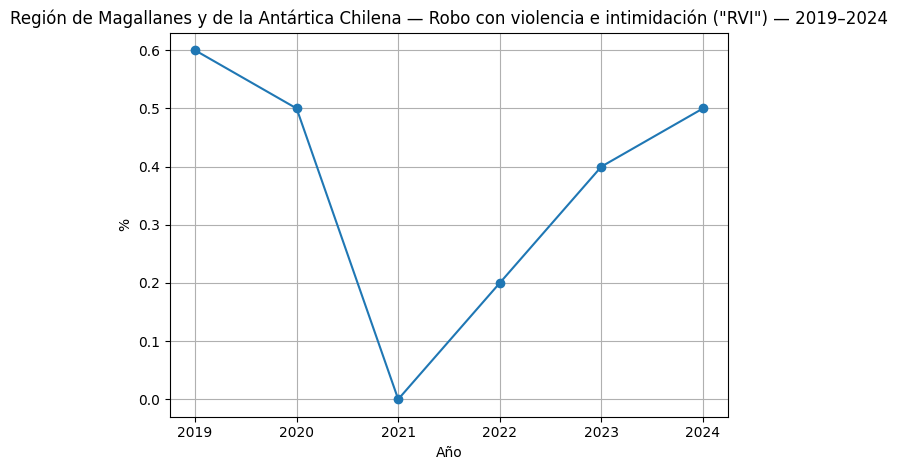

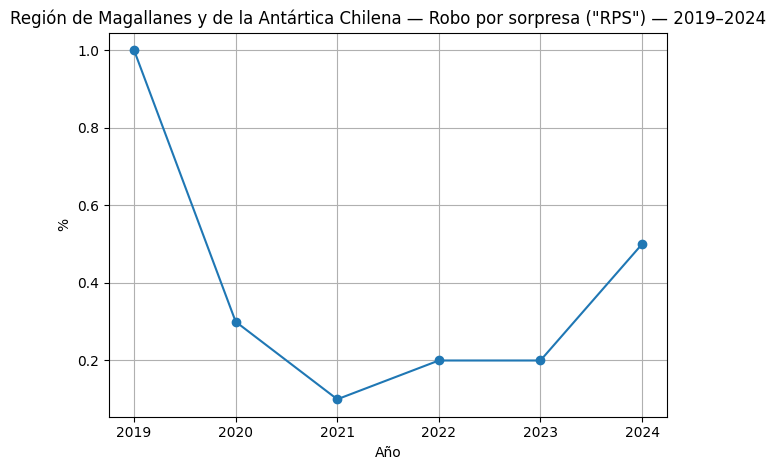

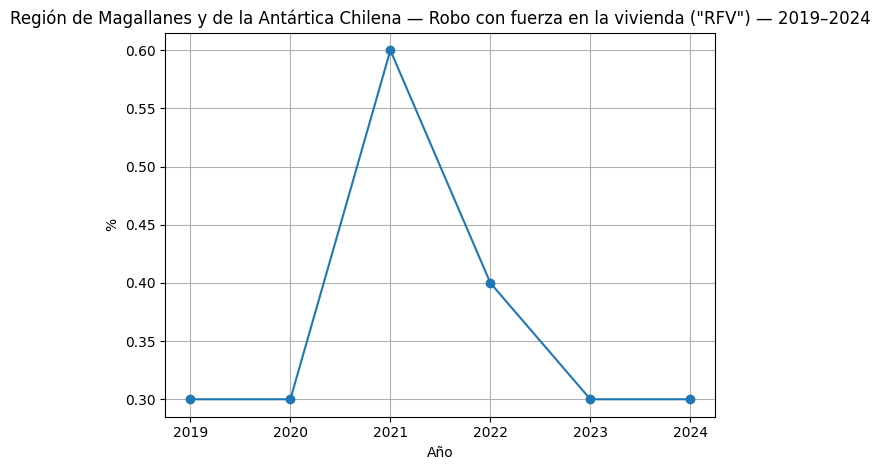

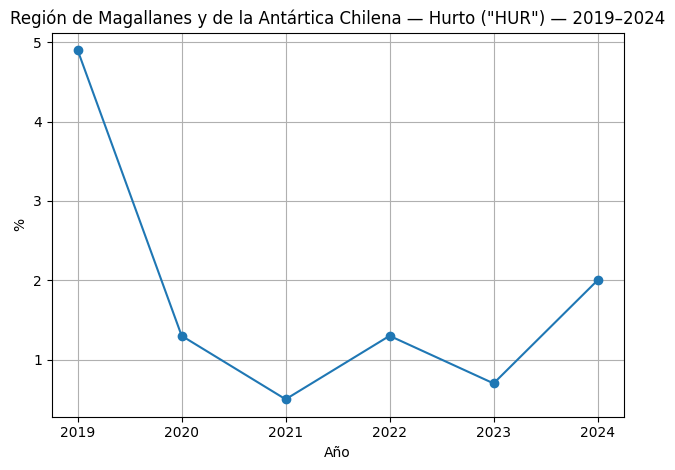

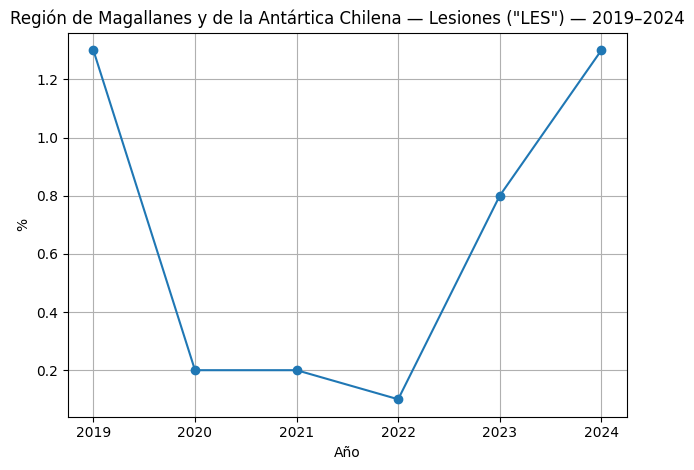

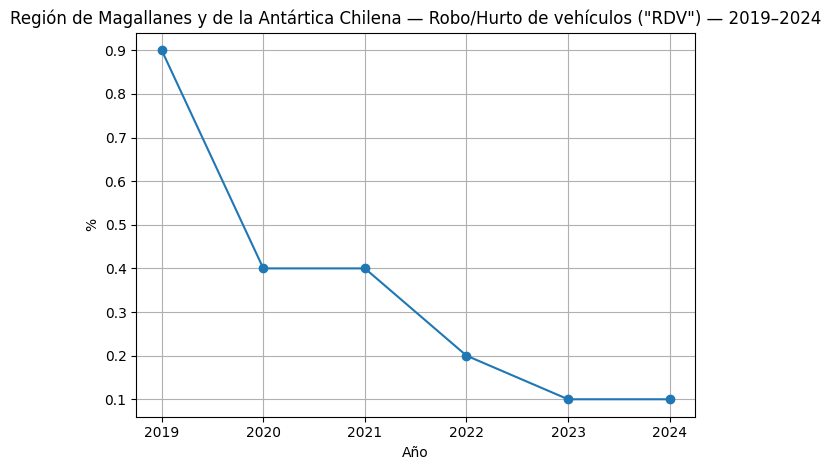

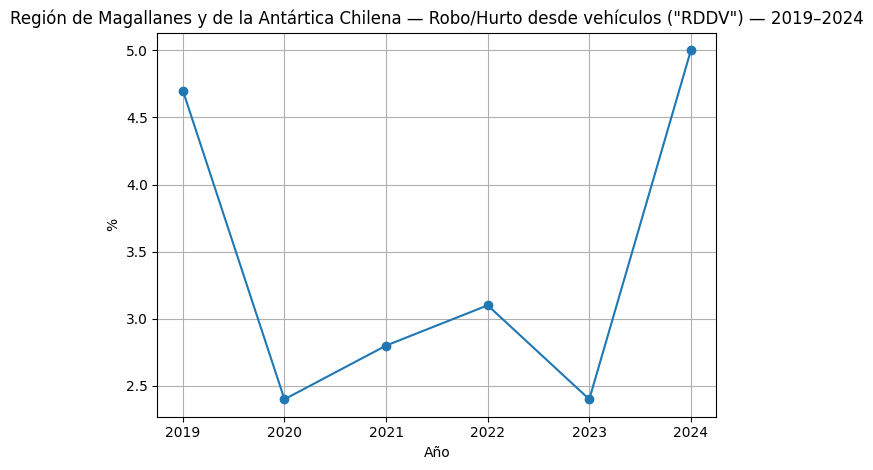

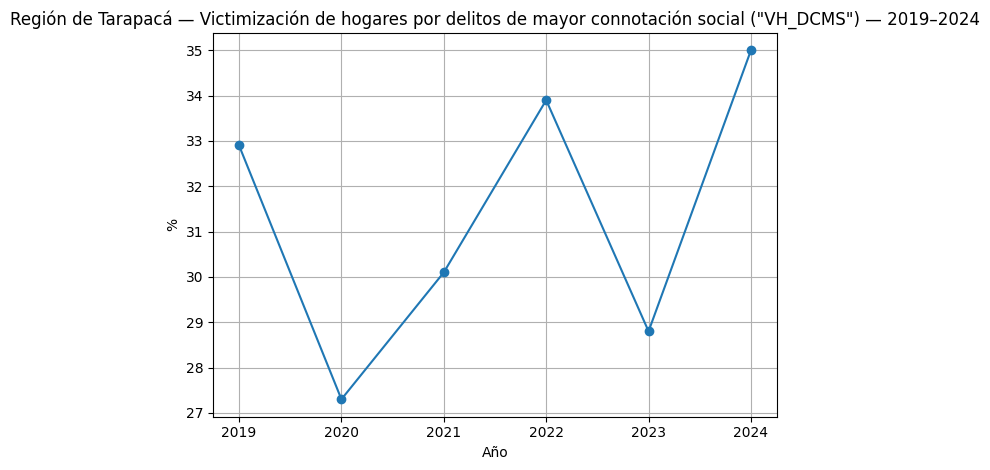

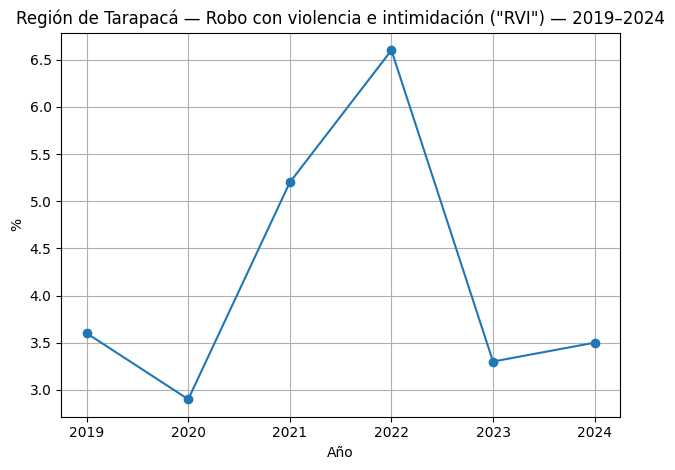

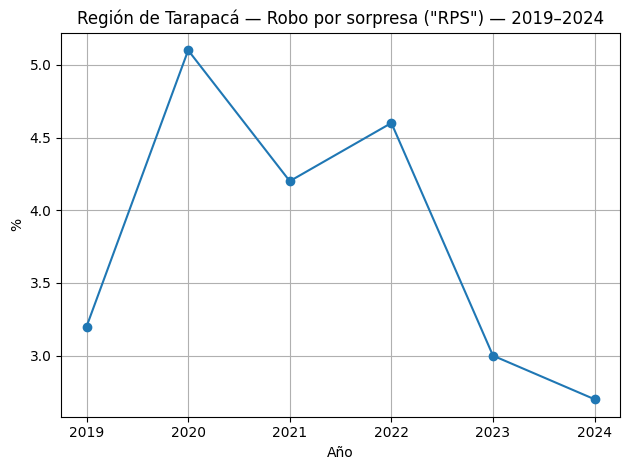

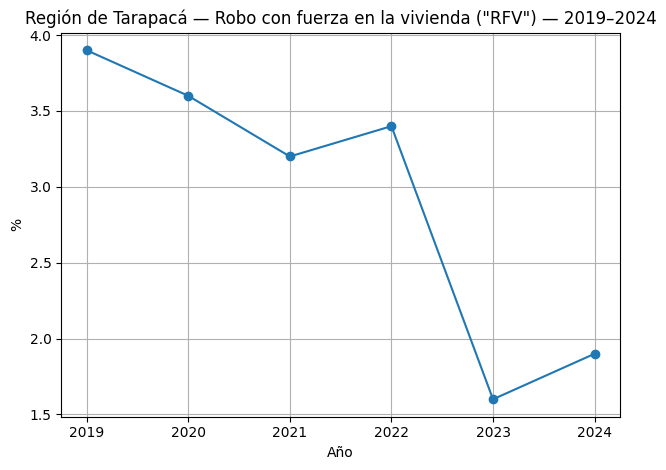

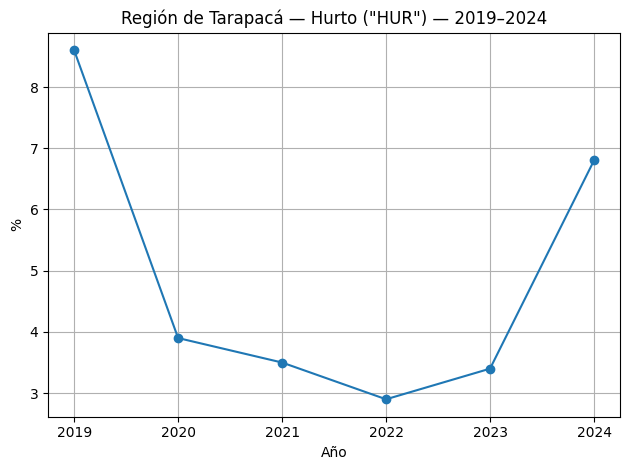

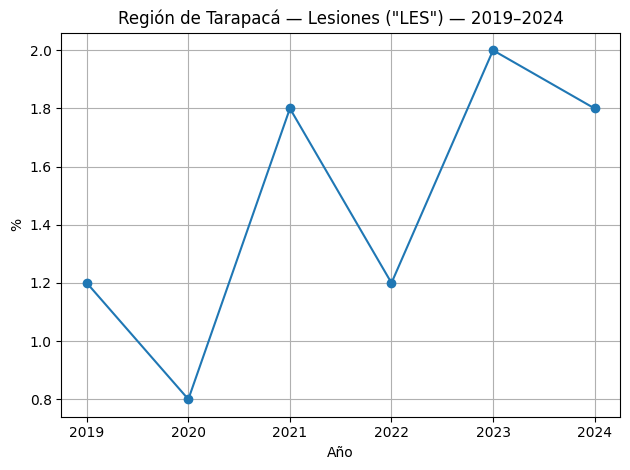

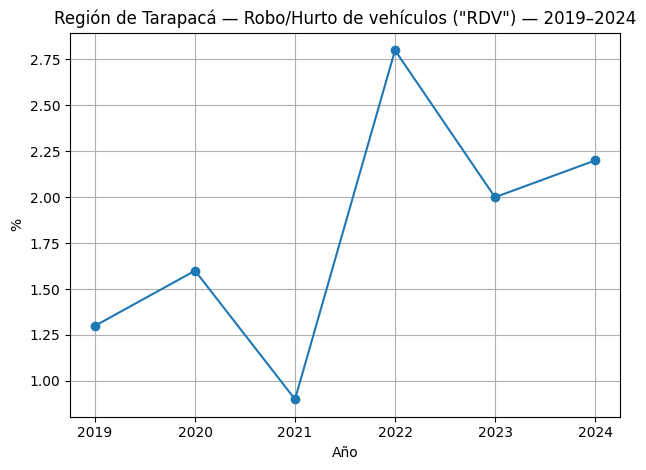

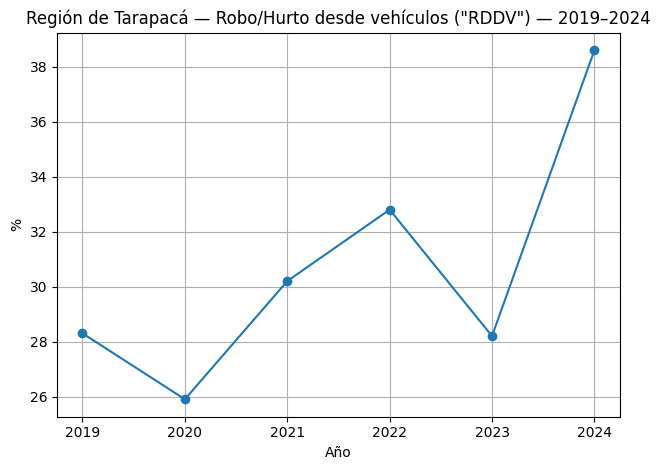

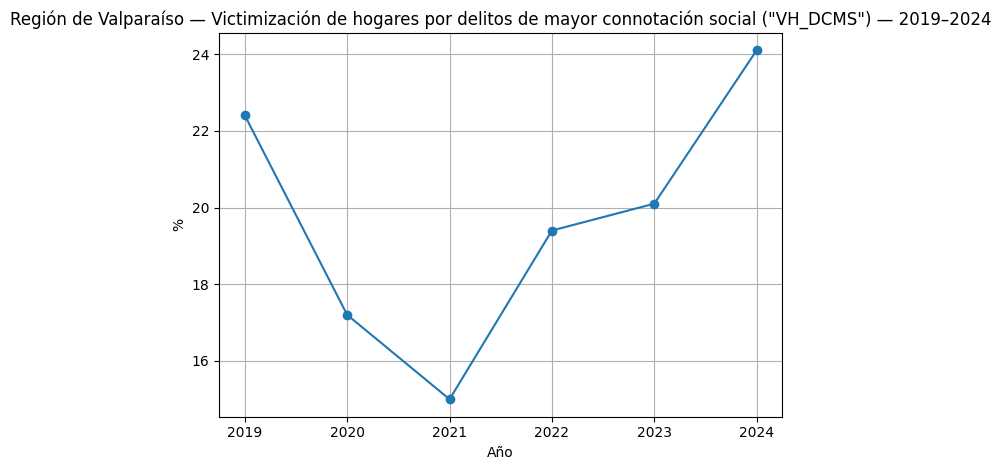

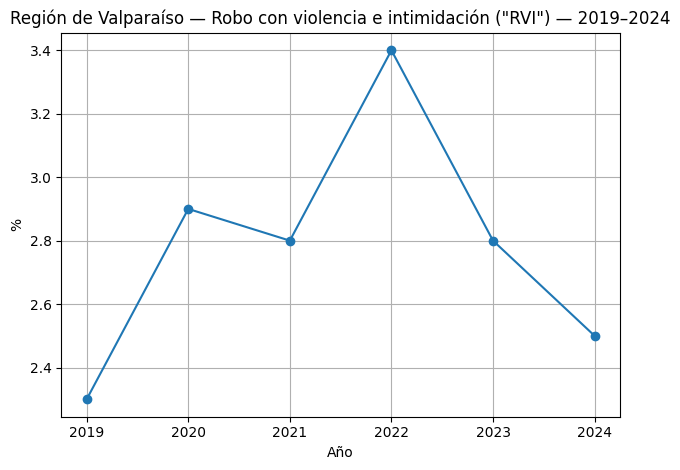

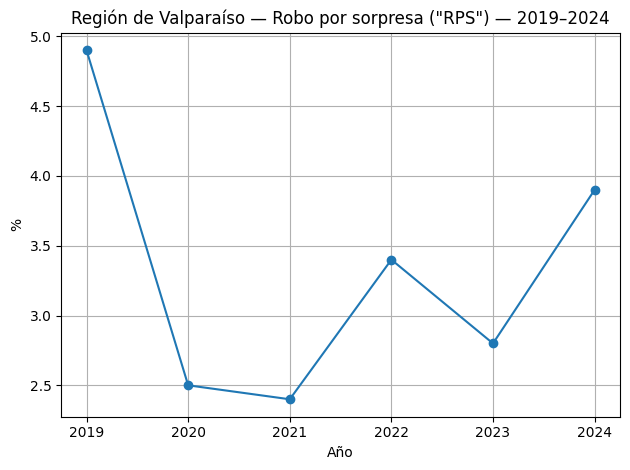

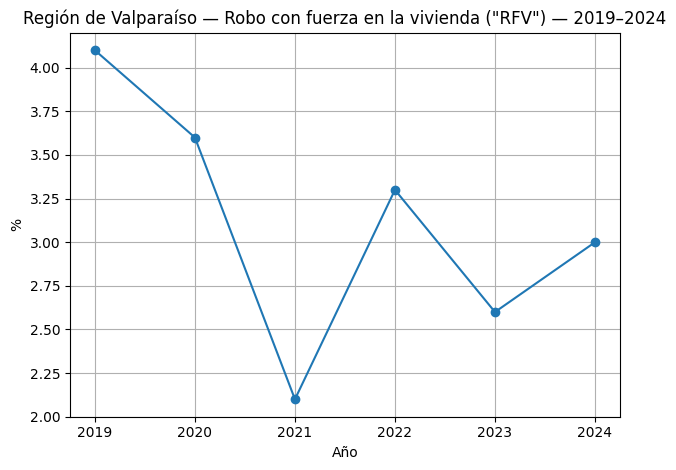

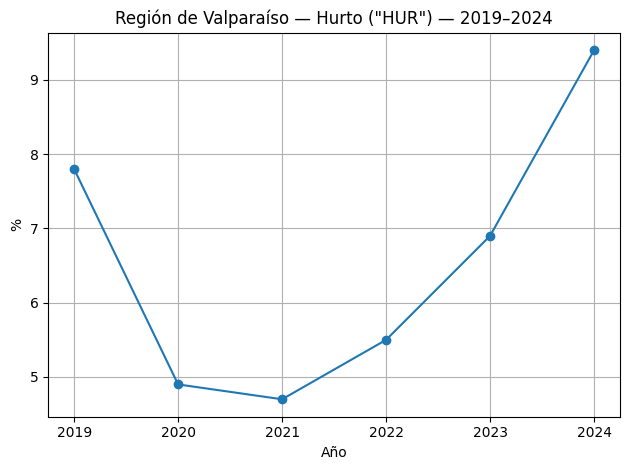

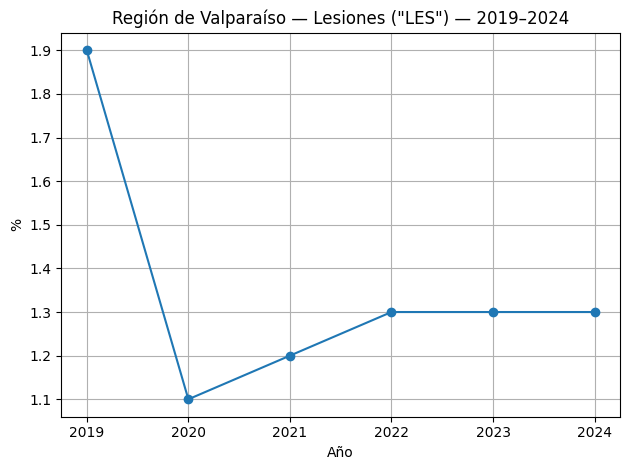

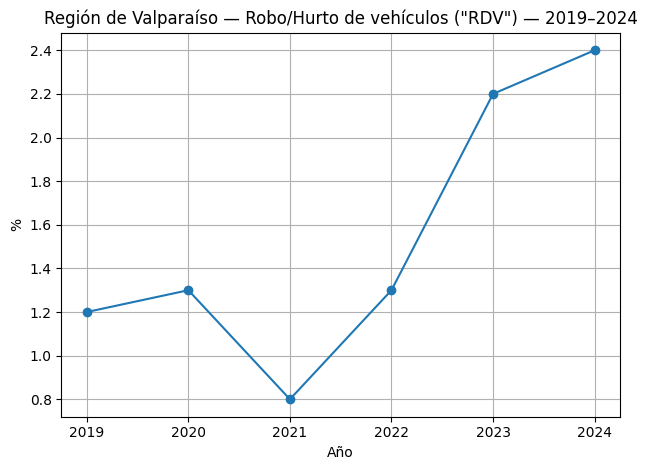

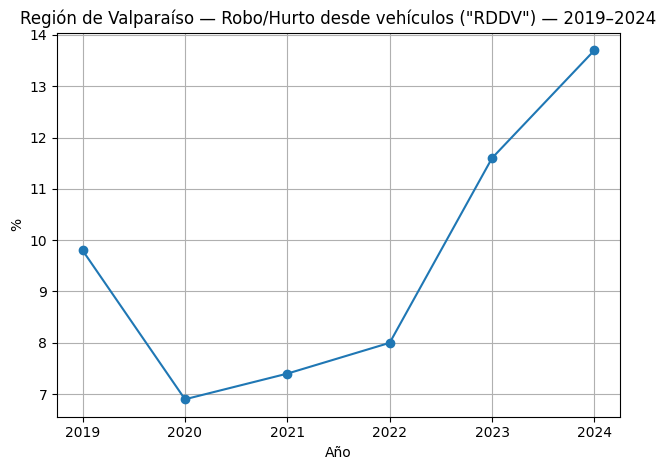

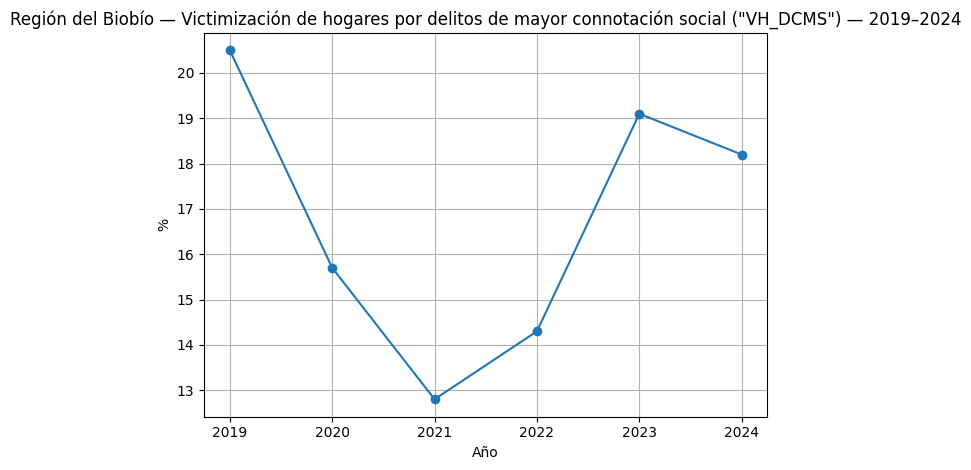

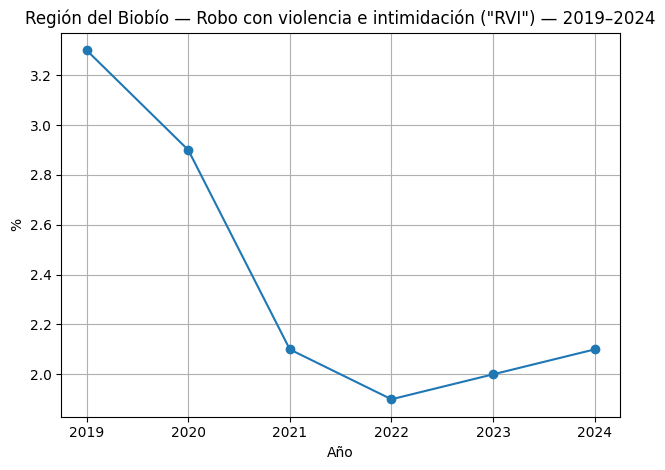

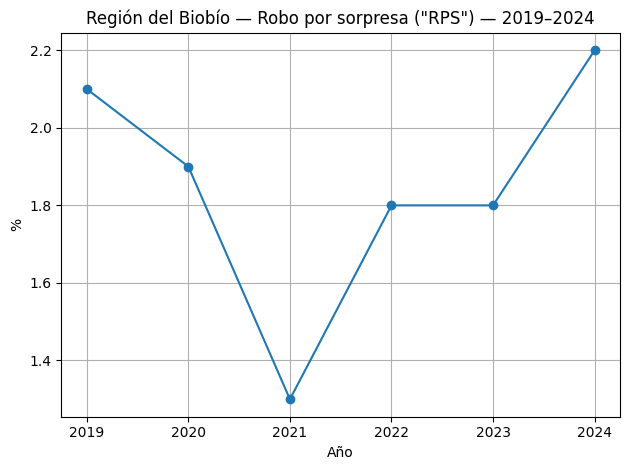

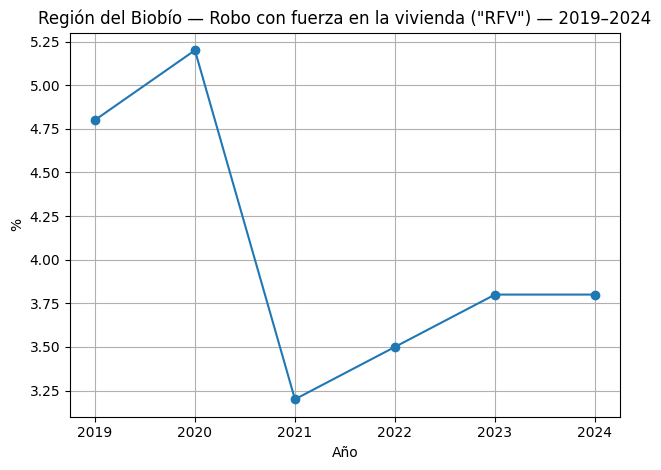

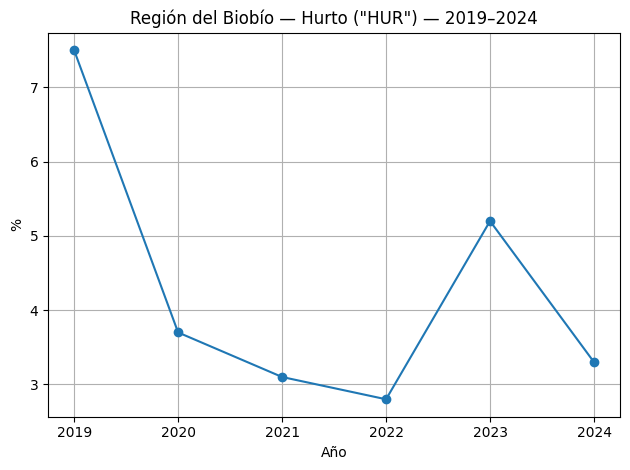

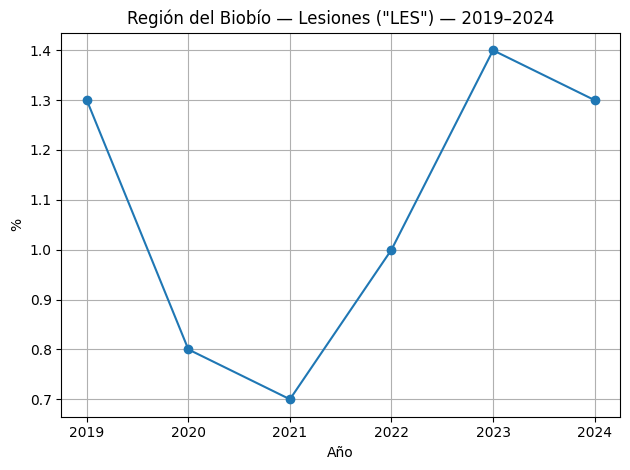

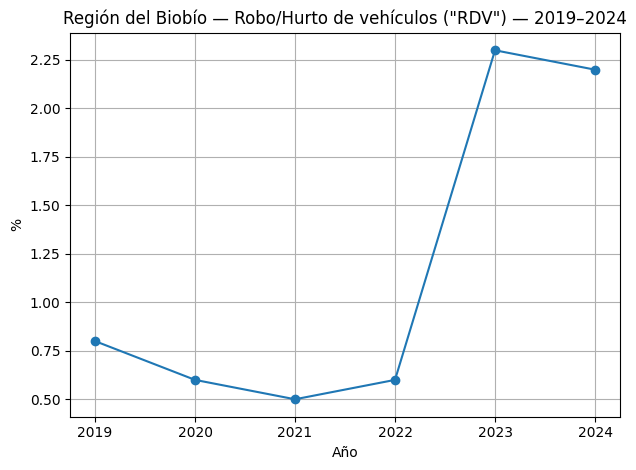

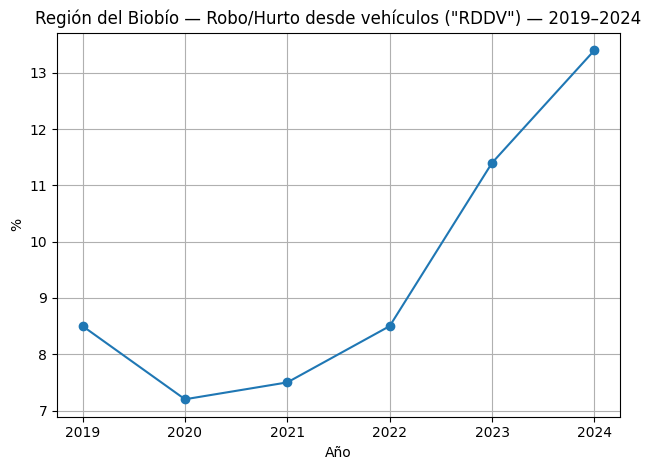

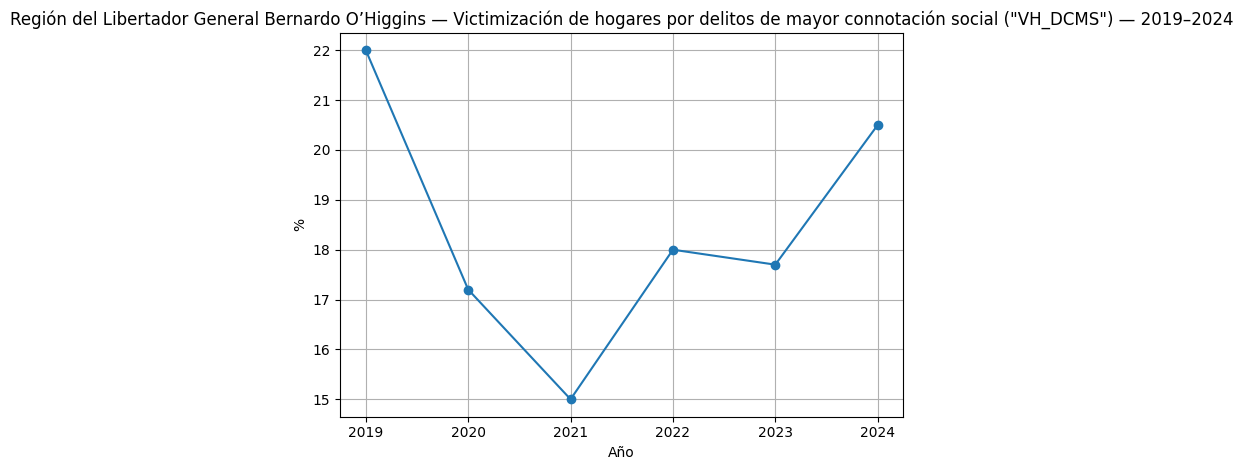

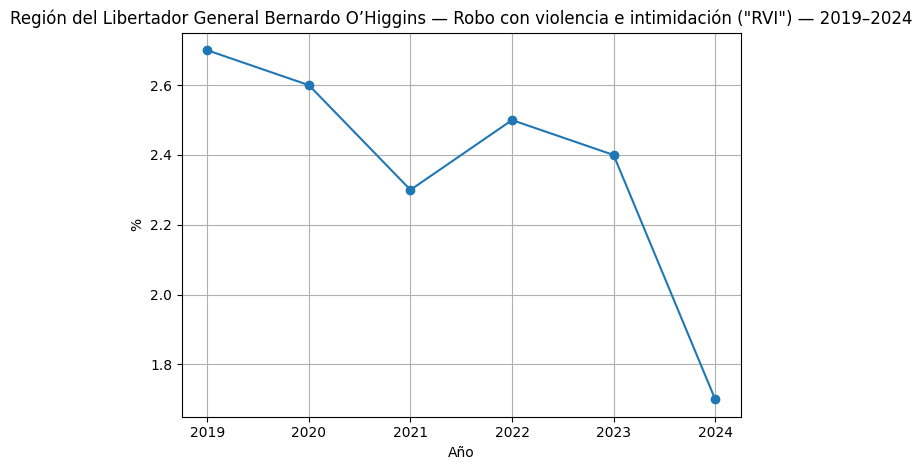

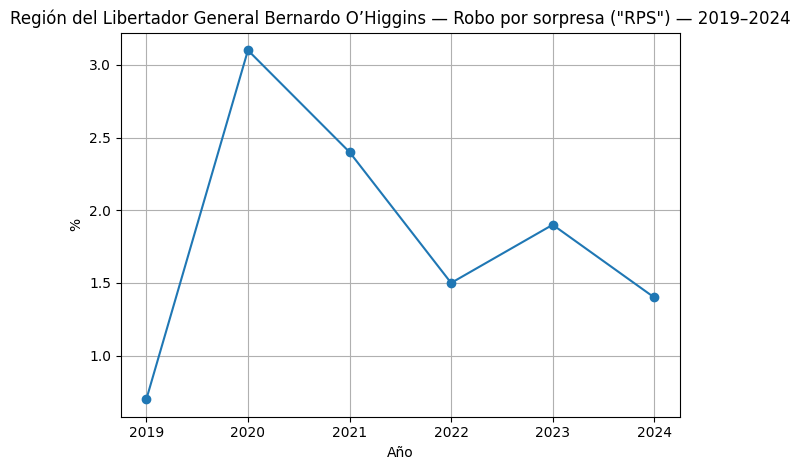

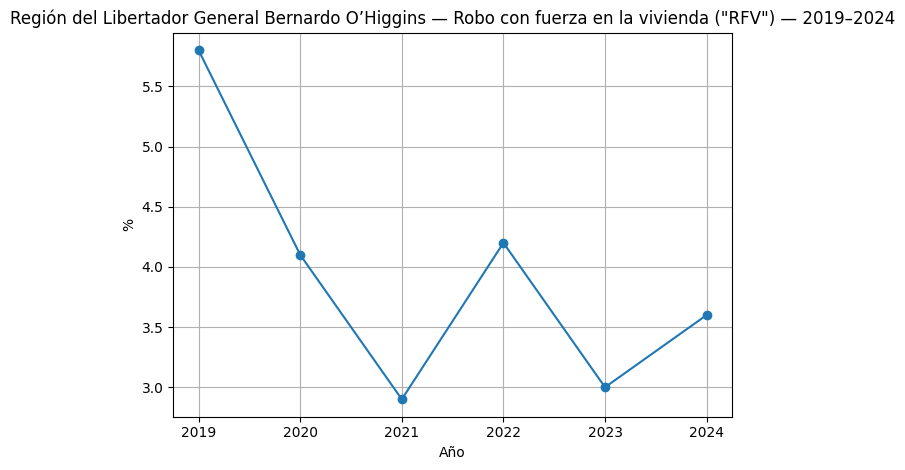

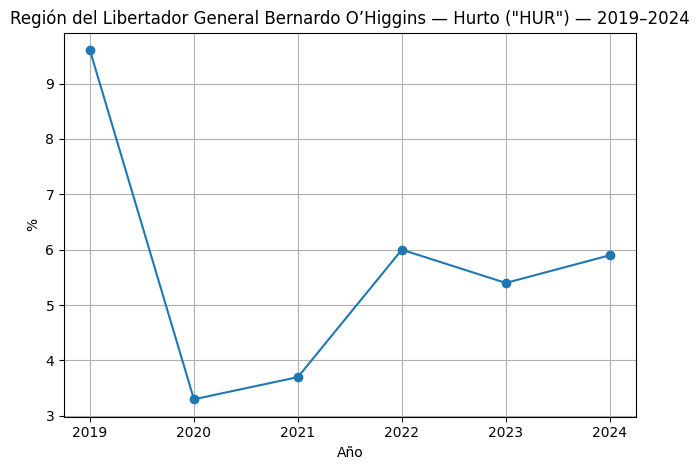

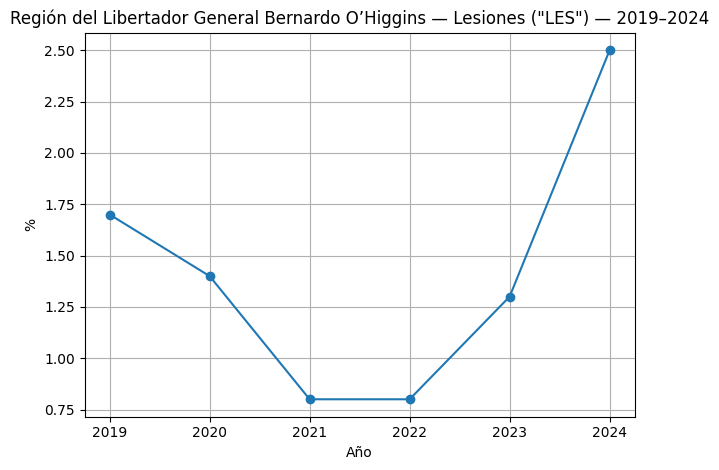

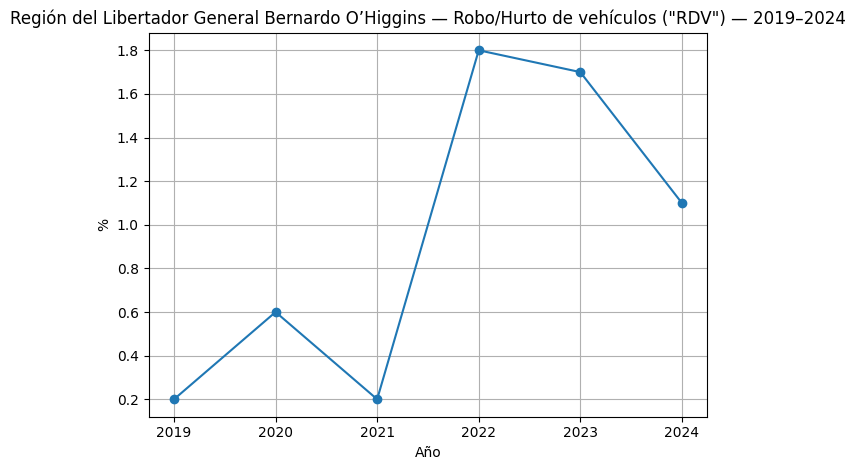

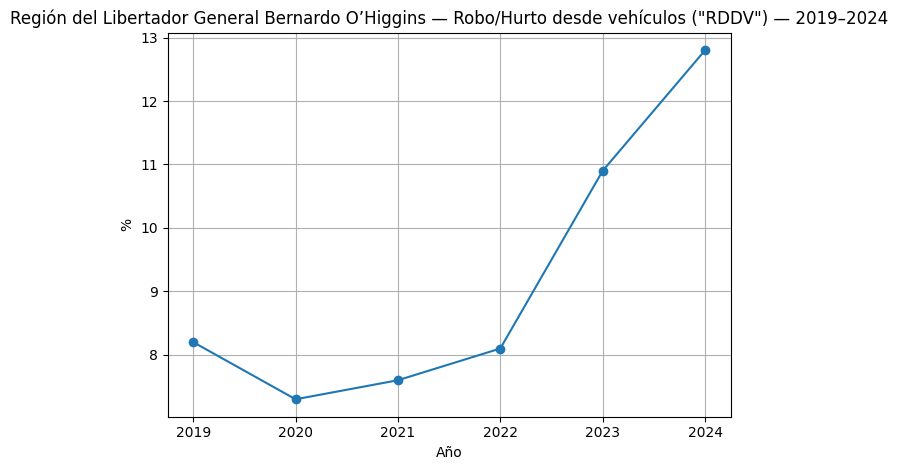

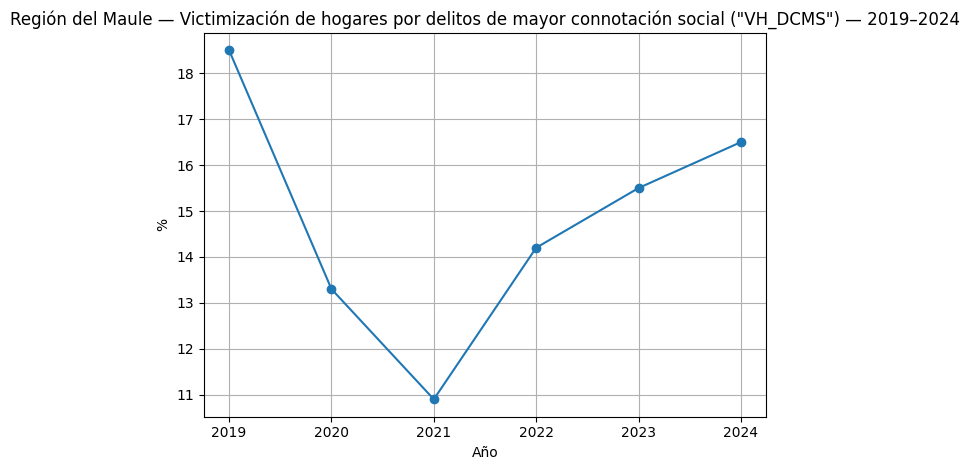

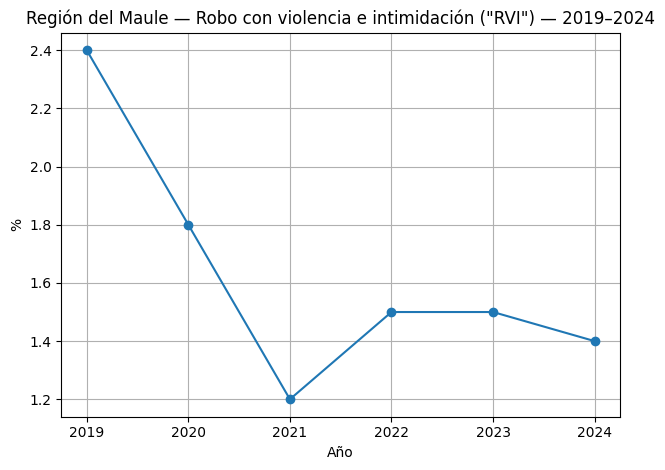

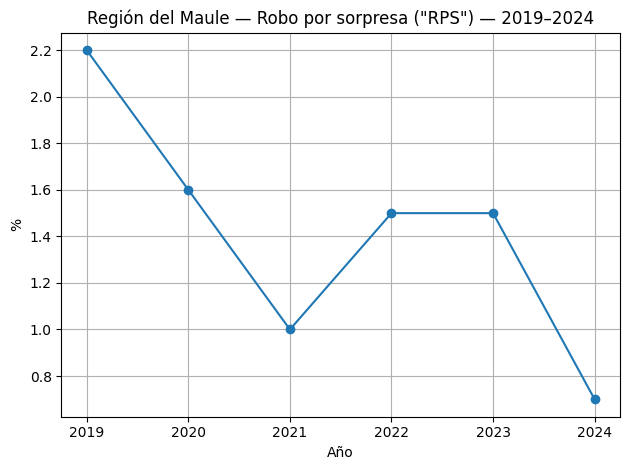

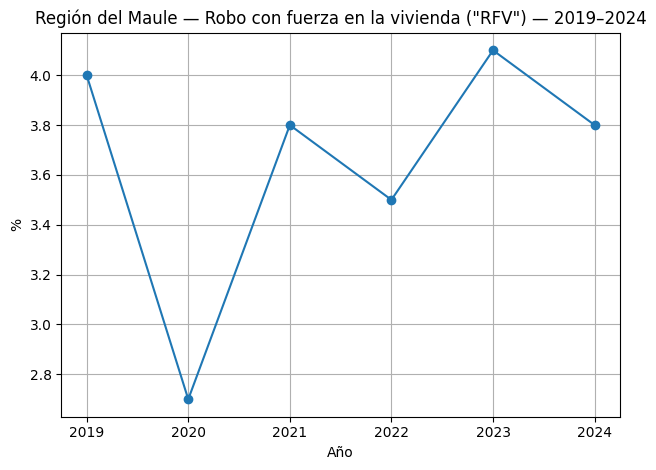

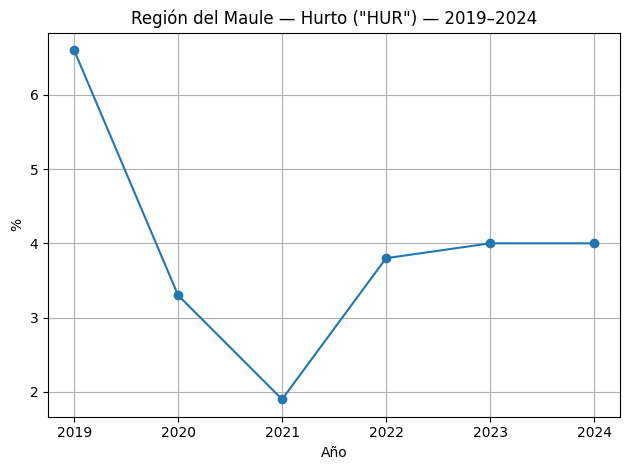

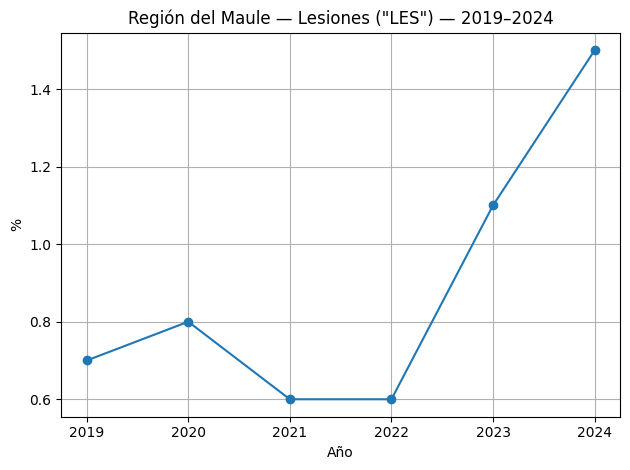

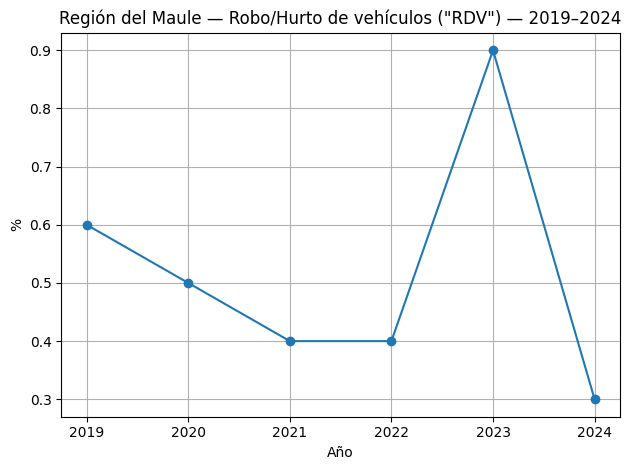

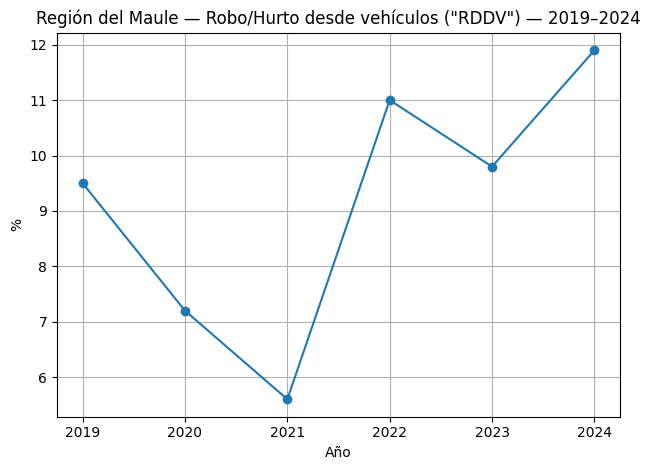

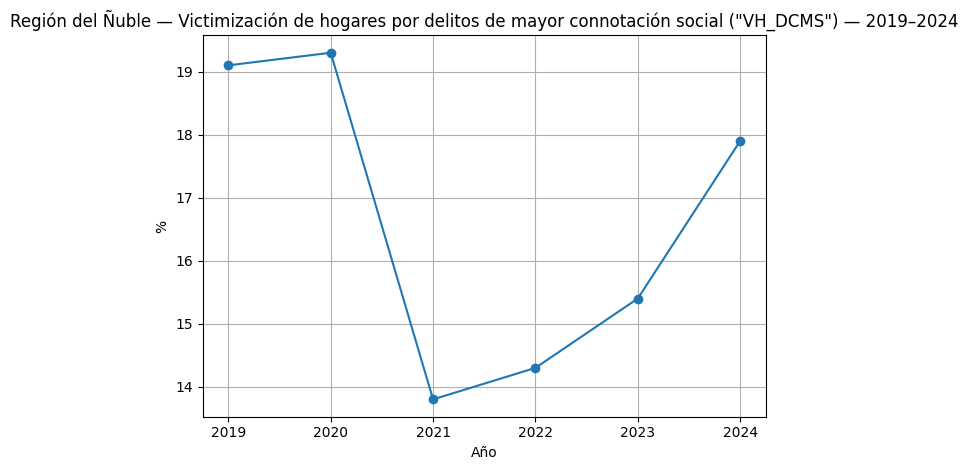

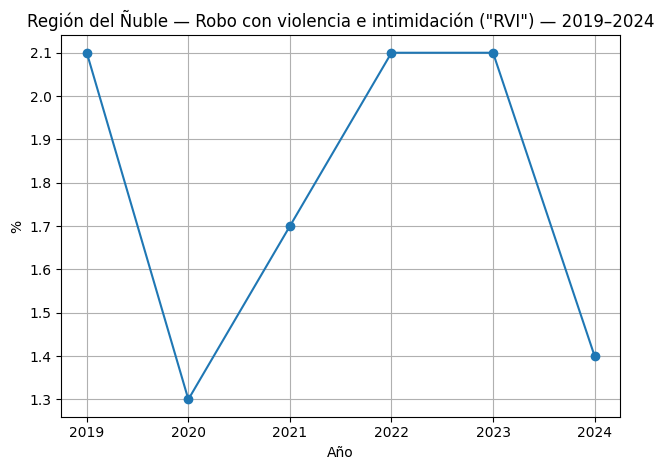

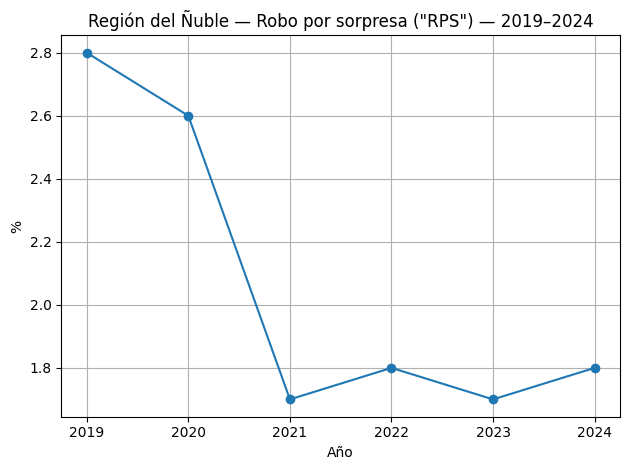

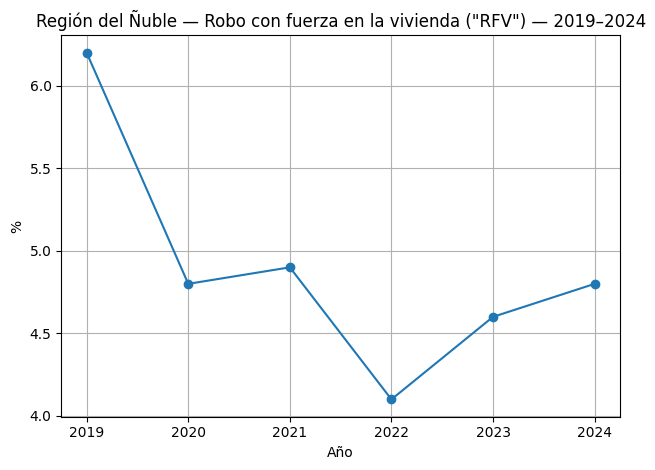

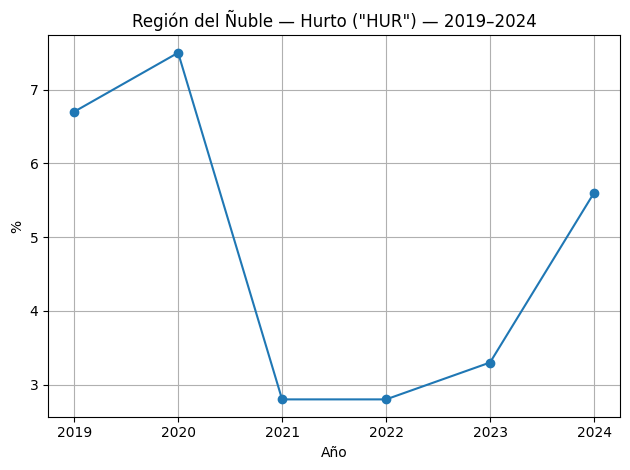

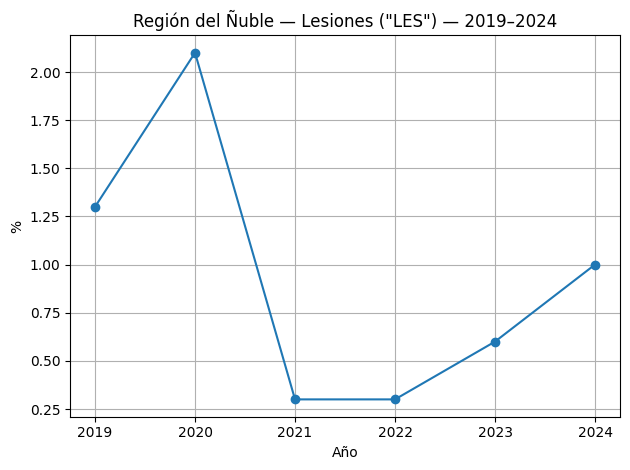

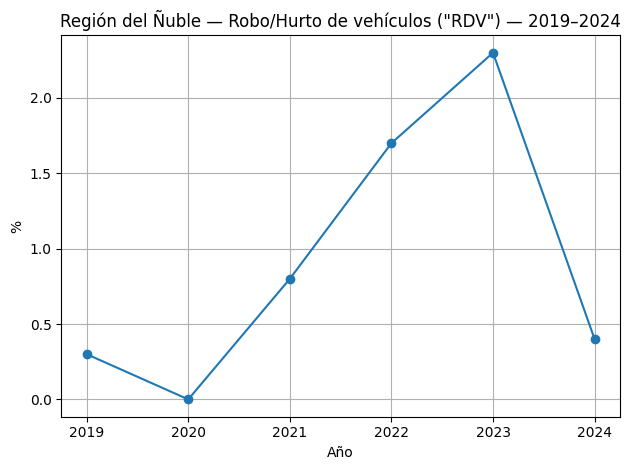

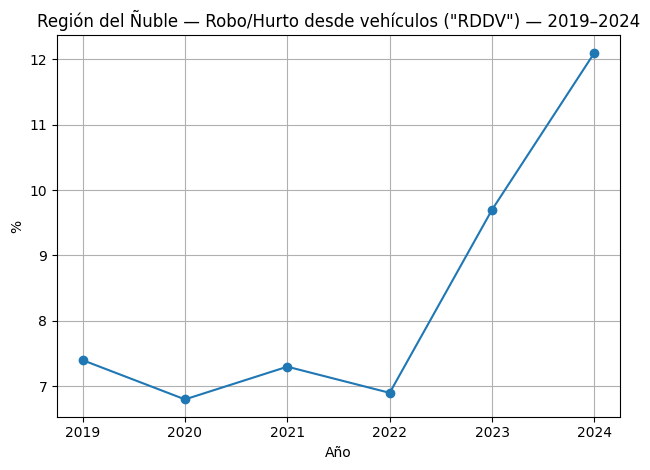

In [5]:
# ============================================================
# BLOQUE 2 — VISUALIZACIONES CORREGIDAS (solo 2019–2024)
# - Nombre largo + código entre comillas y paréntesis
# - SIN vh_dv (solo 2023–2024) para ajustarse al rango pedido
# Requiere creados: nat_percepcion, nat_victim, reg_percepcion, reg_victim
# y reg_percepcion["region_nombre"], reg_victim["region_nombre"]
# ============================================================

# ---- Map de nombres largos por indicador (para títulos)
long_names = {
    'PAD(%)'     : 'Percepción de aumento de la delincuencia',
    'VH_DCMS(%)' : 'Victimización de hogares por delitos de mayor connotación social',
    'RVI(%)'     : 'Robo con violencia e intimidación',
    'RPS(%)'     : 'Robo por sorpresa',
    'RFV(%)'     : 'Robo con fuerza en la vivienda',
    'HUR(%)'     : 'Hurto',
    'LES(%)'     : 'Lesiones',
    'RDV(%)'     : 'Robo/Hurto de vehículos',
    'RDDV(%)'    : 'Robo/Hurto desde vehículos'
}

# Código (entre comillas) para cada columna
short_codes = {
    'PAD(%)'     : 'PAD',
    'VH_DCMS(%)' : 'VH_DCMS',
    'RVI(%)'     : 'RVI',
    'RPS(%)'     : 'RPS',
    'RFV(%)'     : 'RFV',
    'HUR(%)'     : 'HUR',
    'LES(%)'     : 'LES',
    'RDV(%)'     : 'RDV',
    'RDDV(%)'    : 'RDDV'
}

def _title(col, prefijo=None, sufijo=None):
    base = f'{long_names[col]} ("{short_codes[col]}")'
    if prefijo and sufijo:
        return f"{prefijo} — {base} — {sufijo}"
    if prefijo:
        return f"{base} — {prefijo}"
    if sufijo:
        return f"{base} — {sufijo}"
    return base

def _plot_line(df, x, y, titulo, xlabel="Año", ylabel="%"):
    # Asegurar eje X con años enteros ordenados
    years = pd.to_numeric(df[x], errors='coerce').dropna().astype(int)
    vals  = pd.to_numeric(df[y], errors='coerce')
    tmp   = pd.DataFrame({x: years, y: vals}).dropna().sort_values(x)
    fig = plt.figure()
    plt.plot(tmp[x], tmp[y], marker='o')
    plt.title(titulo)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(tmp[x].unique())  # ticks exactos por año
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def _plot_all_lines(df, x, cols, titulo_base):
    for col in cols:
        if col in df.columns:
            _plot_line(df, x, col, _title(col, prefijo=titulo_base))

# ------------------- NACIONAL -------------------

# 1) PAD (nacional)
if 'PAD(%)' in nat_percepcion.columns:
    _plot_line(
        nat_percepcion.sort_values('año'),
        'año', 'PAD(%)',
        _title('PAD(%)', prefijo='Nacional', sufijo='2019–2024')
    )

# 2) Victimización (nacional) — todas las componentes
nat_cols = [c for c in nat_victim.columns if c.endswith('(%)') and c != 'vh_dv_pct']
_plot_all_lines(
    nat_victim.sort_values('año'),
    'año',
    nat_cols,
    'Nacional (2019–2024)'
)

# ------------------- REGIONAL -------------------

# 3) PAD por región
if {'PAD(%)','region_nombre','año'}.issubset(reg_percepcion.columns):
    for reg_name in sorted(reg_percepcion['region_nombre'].dropna().unique()):
        df_r = reg_percepcion[reg_percepcion['region_nombre'] == reg_name].sort_values('año')
        _plot_line(
            df_r, 'año', 'PAD(%)',
            _title('PAD(%)', prefijo=reg_name, sufijo='2019–2024')
        )

# 4) Victimización por región (todas las componentes)
vict_cols = ["VH_DCMS(%)","RVI(%)","RPS(%)","RFV(%)","HUR(%)","LES(%)","RDV(%)","RDDV(%)"]
if {'region_nombre','año'}.issubset(reg_victim.columns):
    for reg_name in sorted(reg_victim['region_nombre'].dropna().unique()):
        df_r = reg_victim[reg_victim['region_nombre'] == reg_name].sort_values('año')
        for col in vict_cols:
            if col in df_r.columns:
                _plot_line(
                    df_r, 'año', col,
                    _title(col, prefijo=reg_name, sufijo='2019–2024')
                )


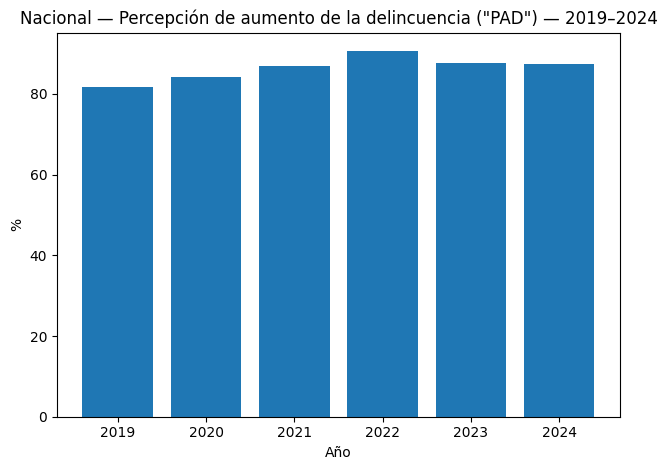

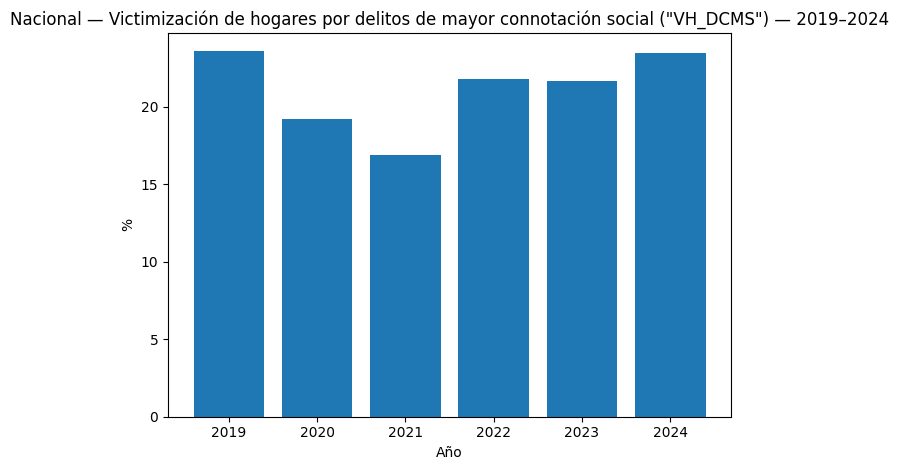

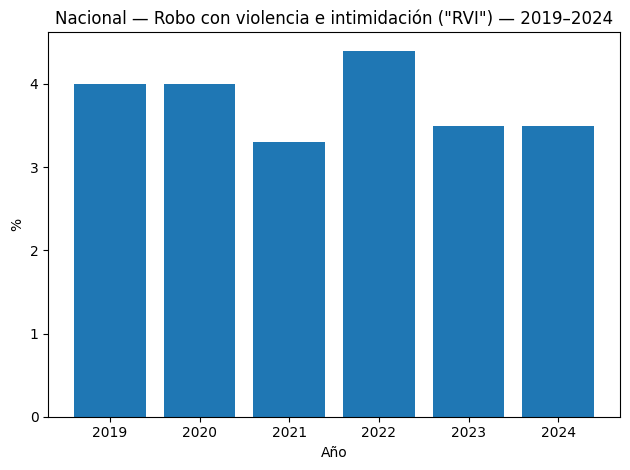

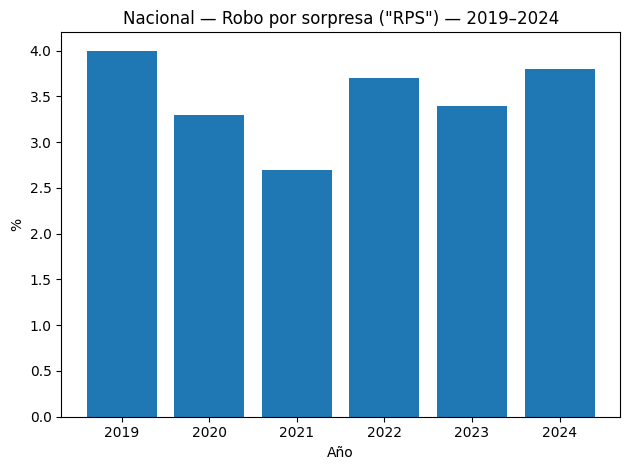

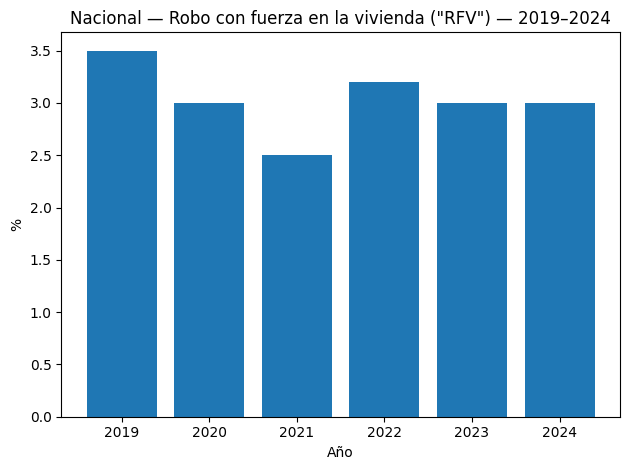

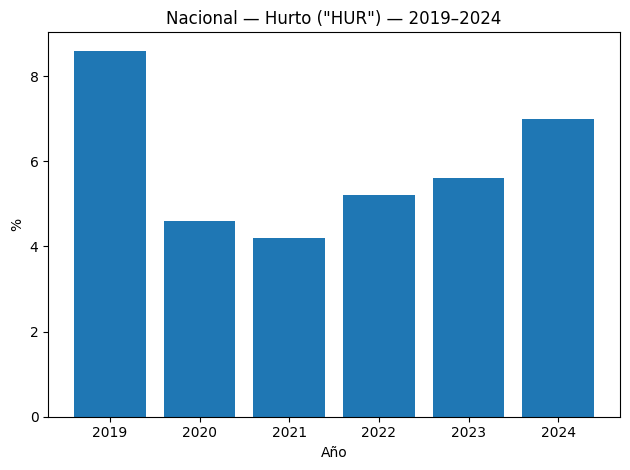

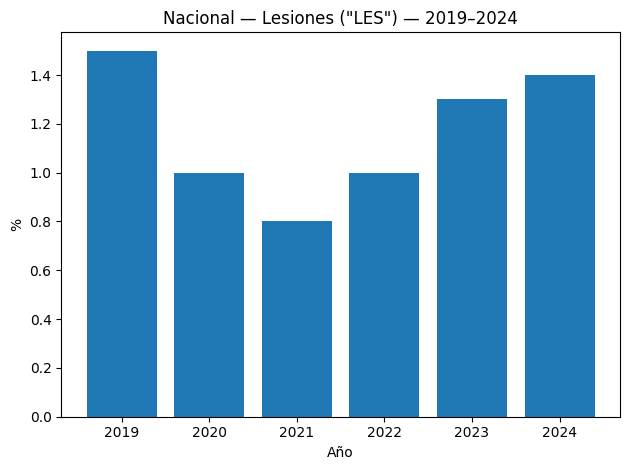

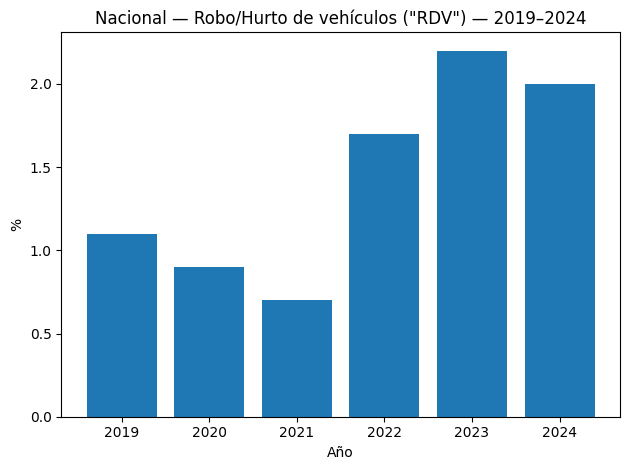

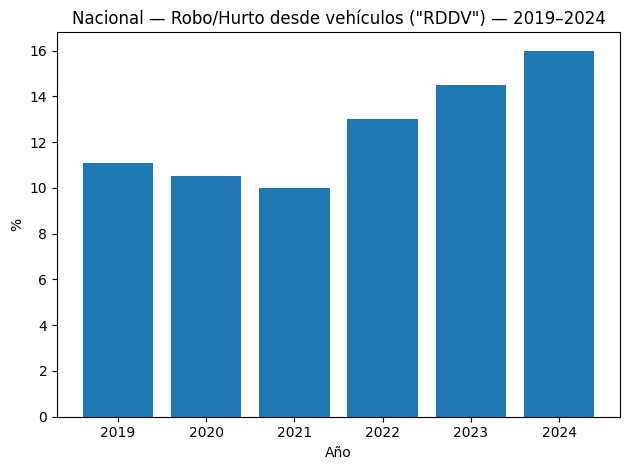

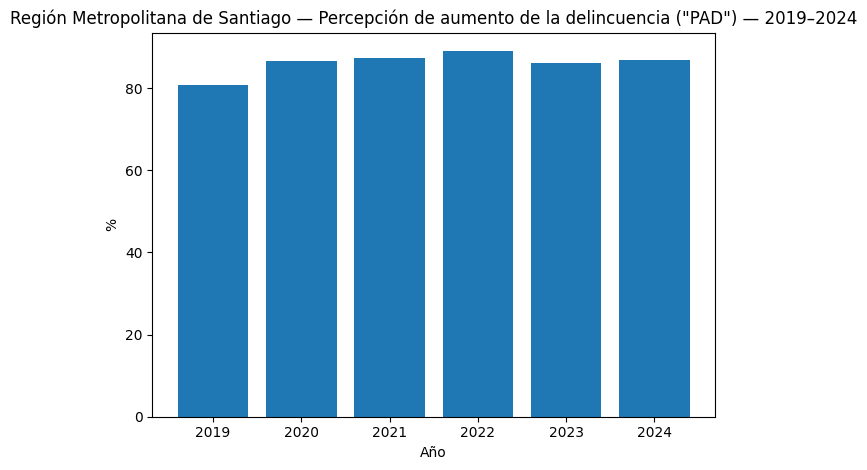

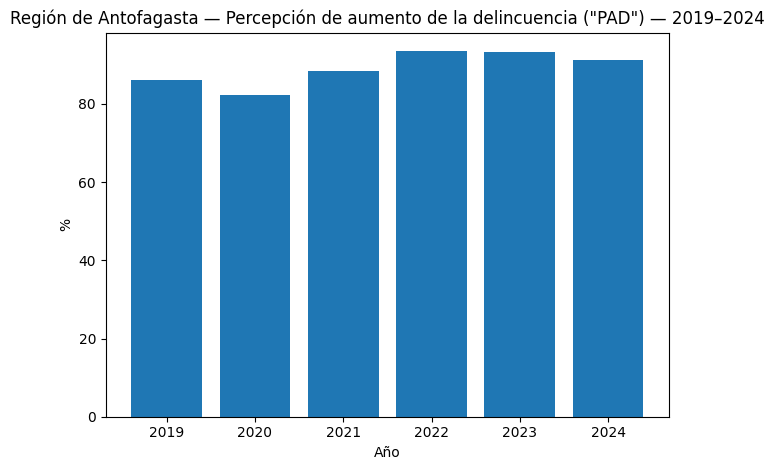

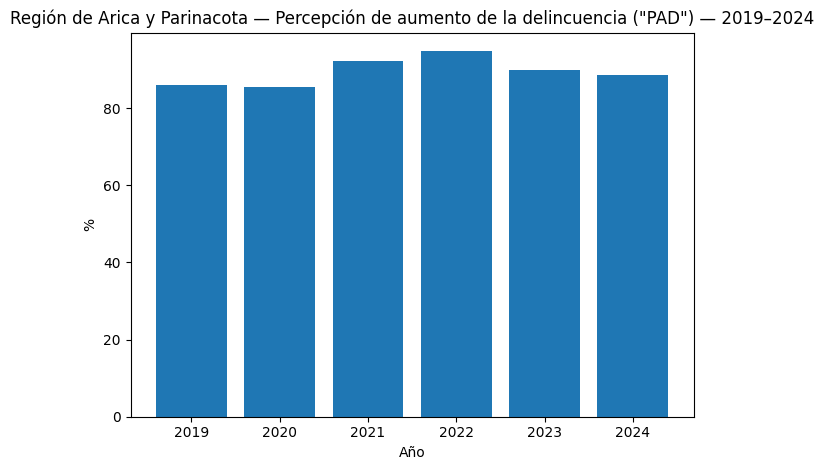

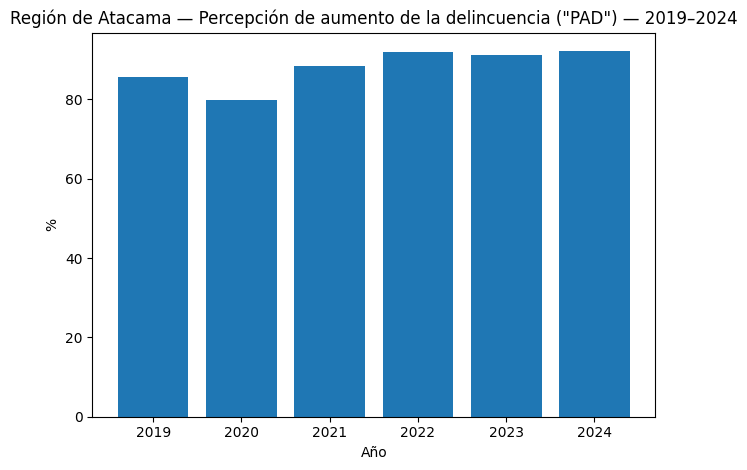

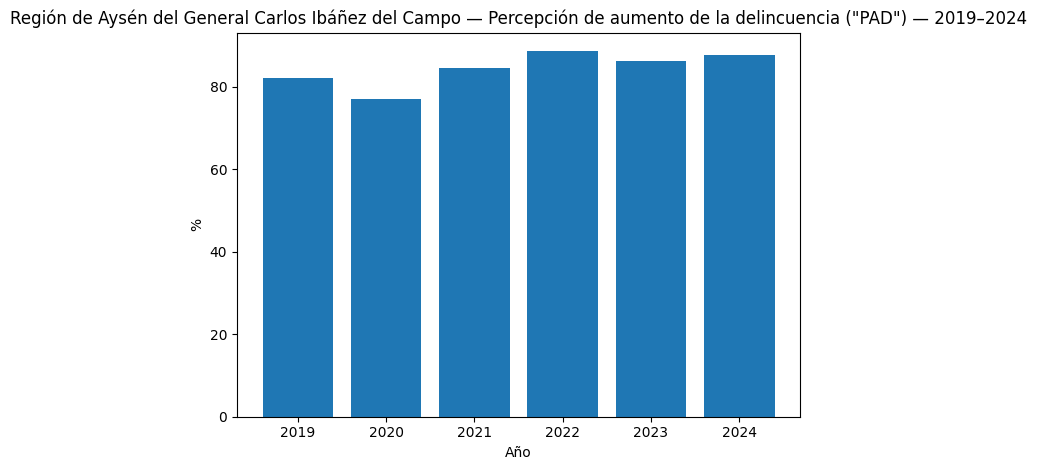

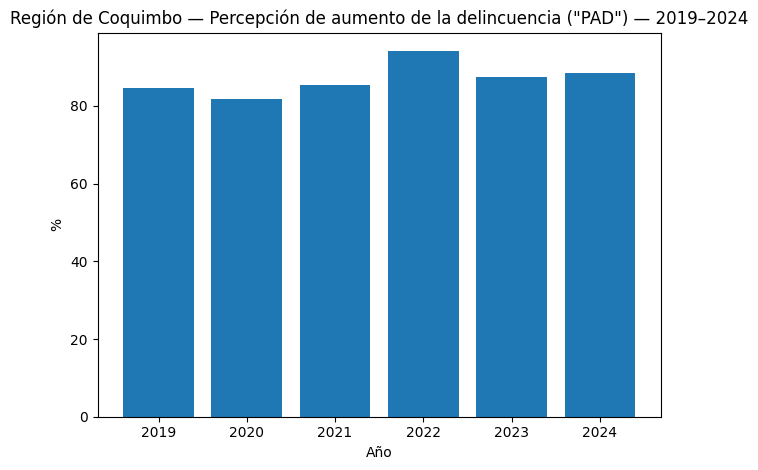

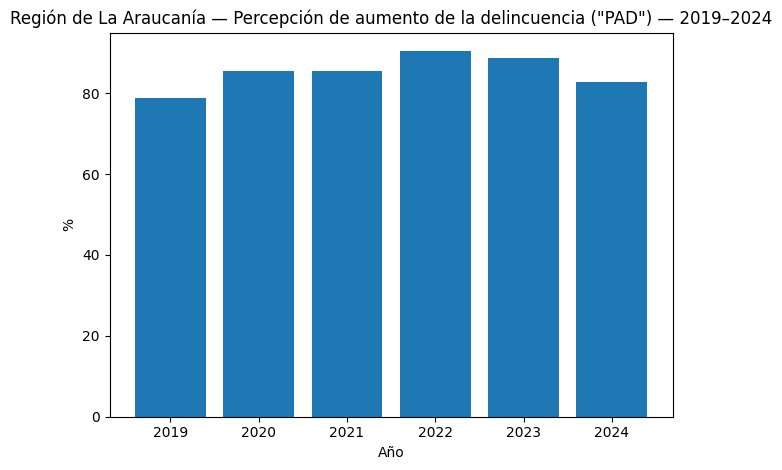

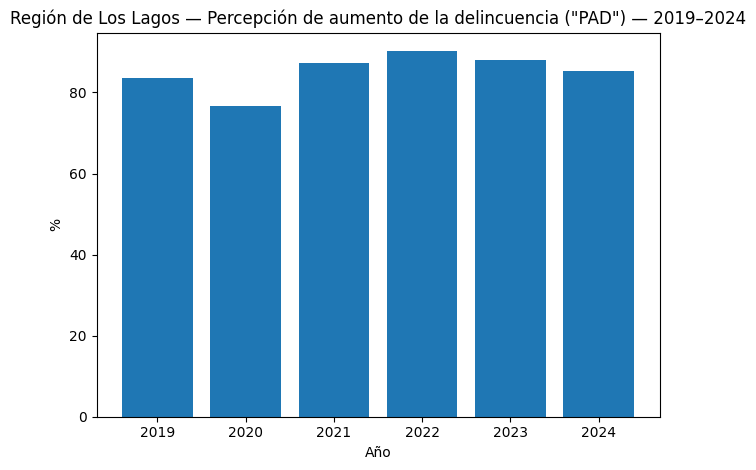

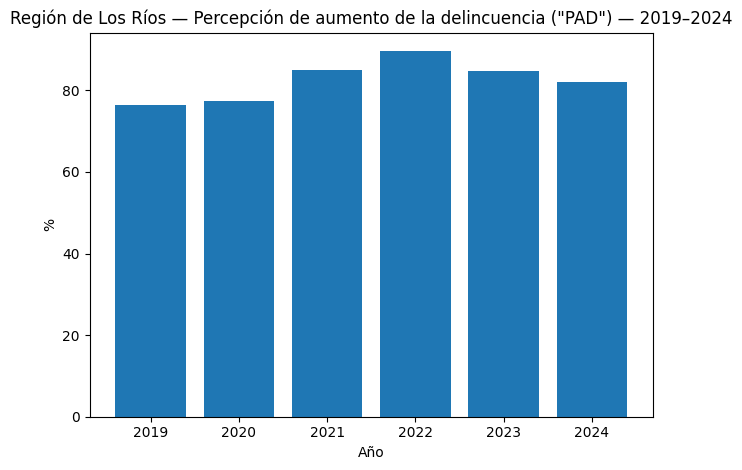

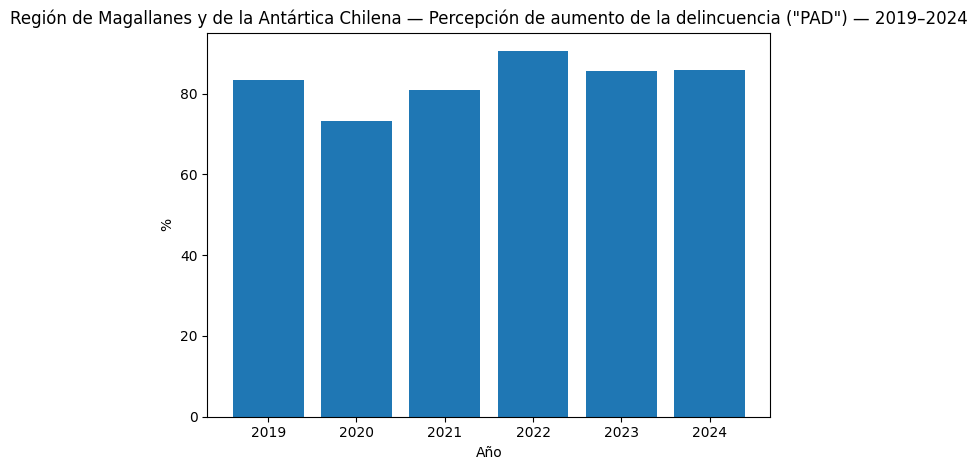

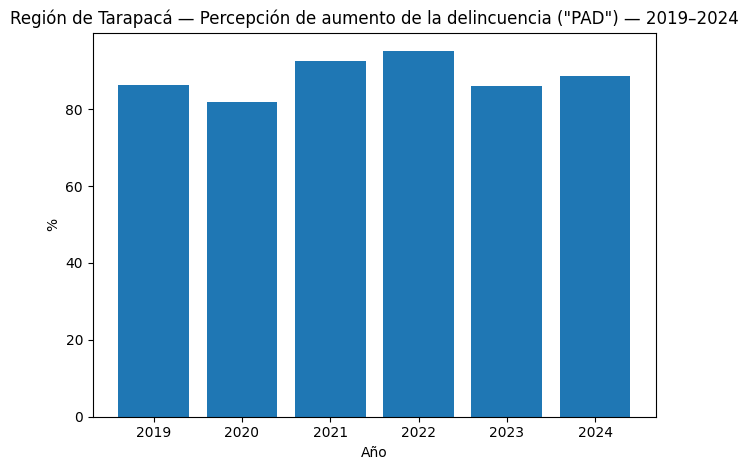

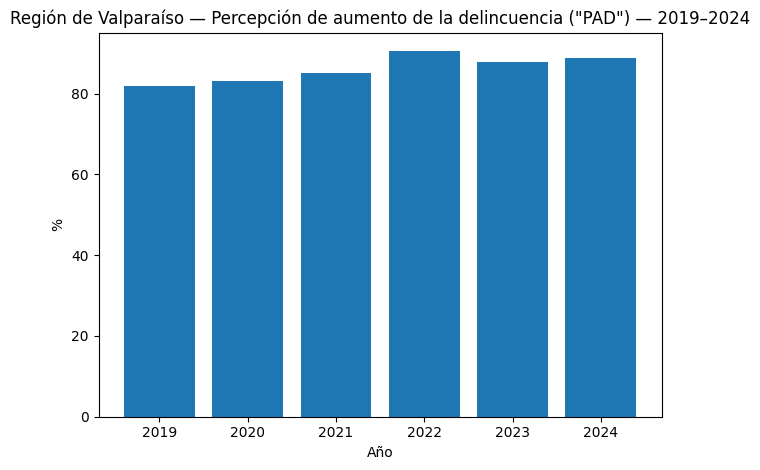

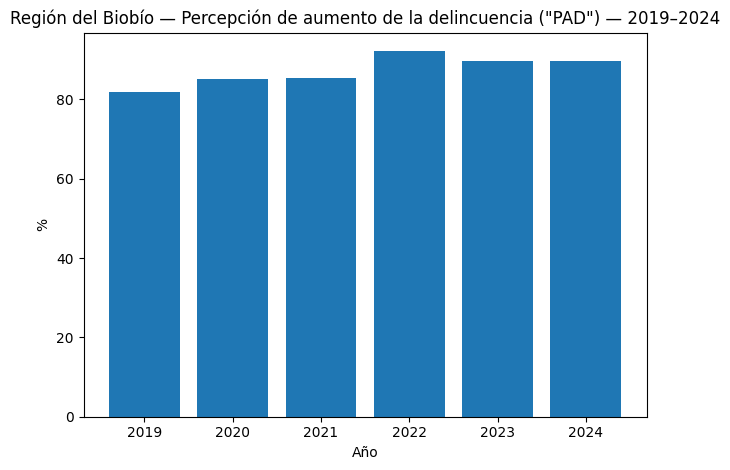

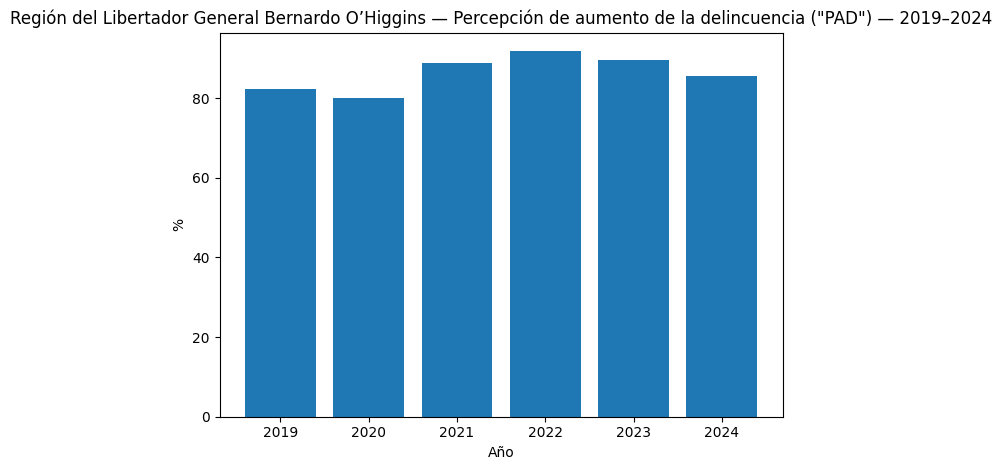

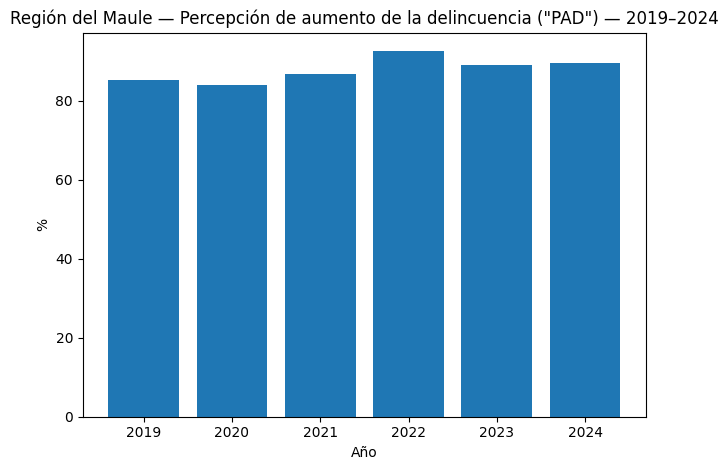

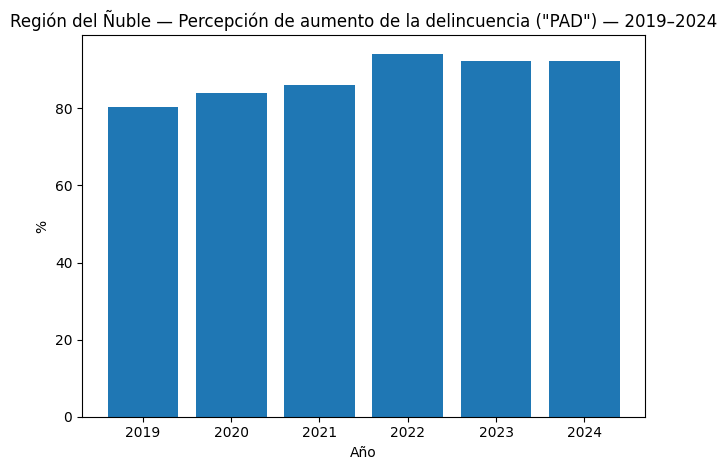

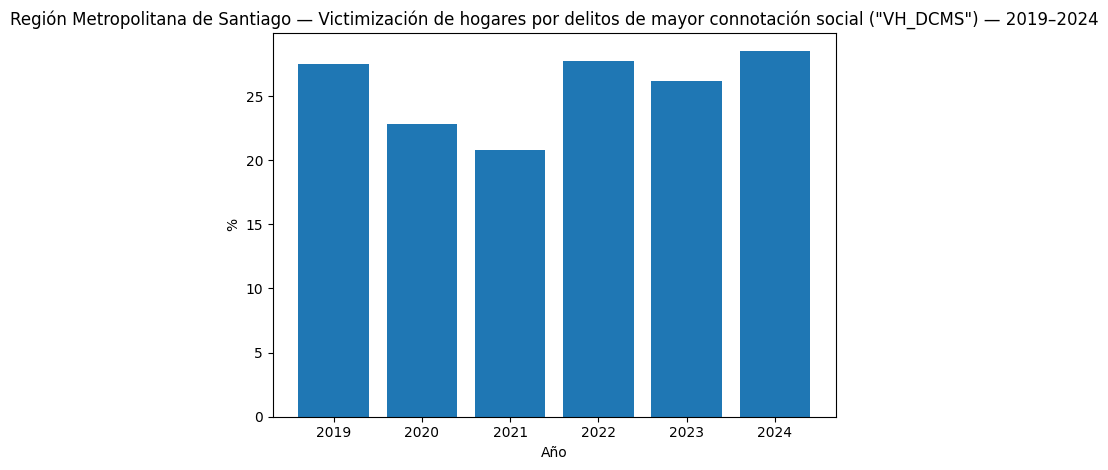

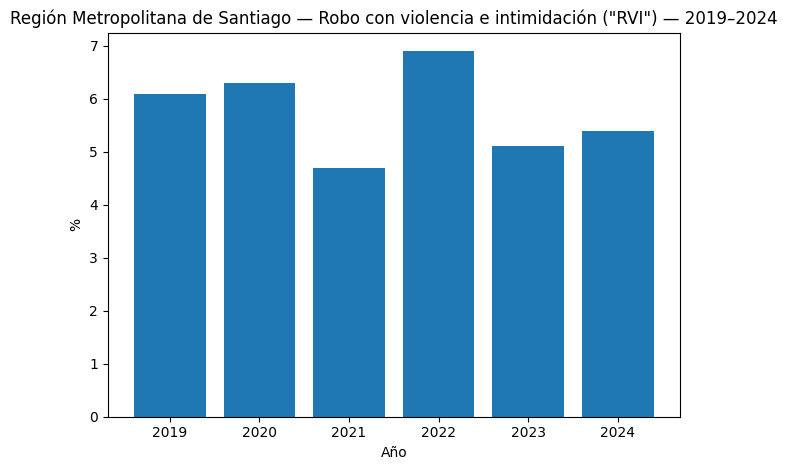

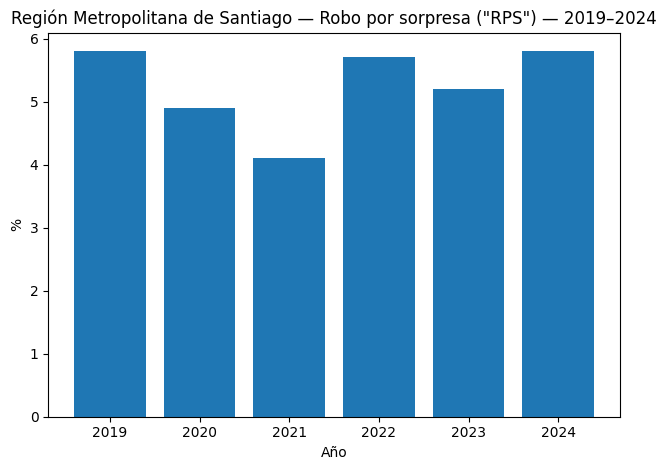

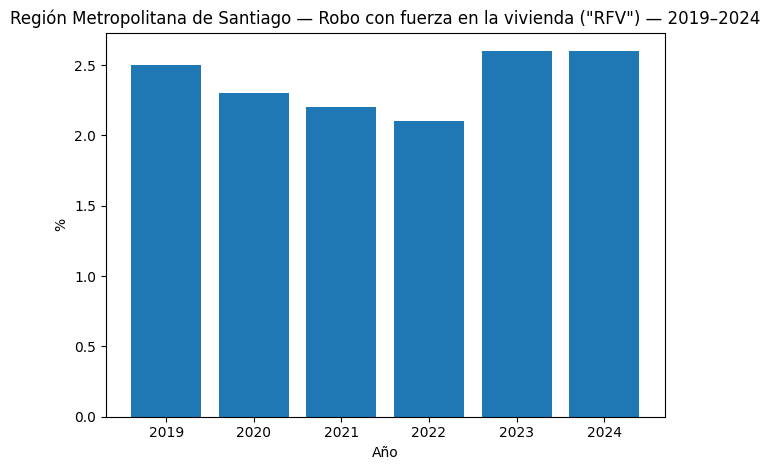

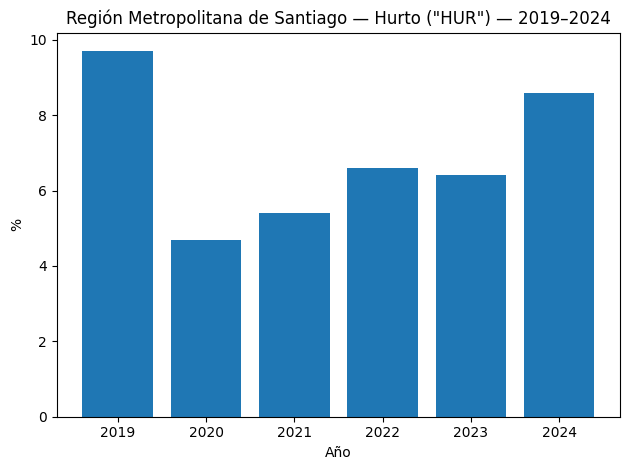

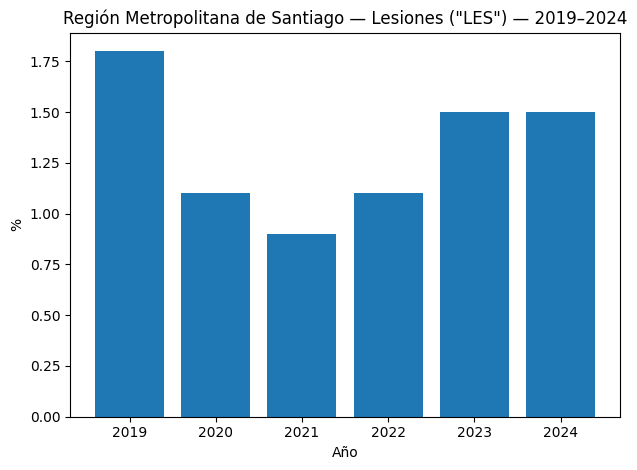

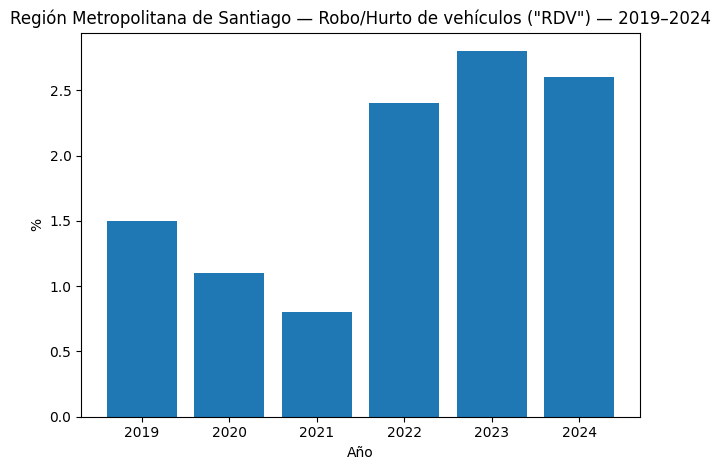

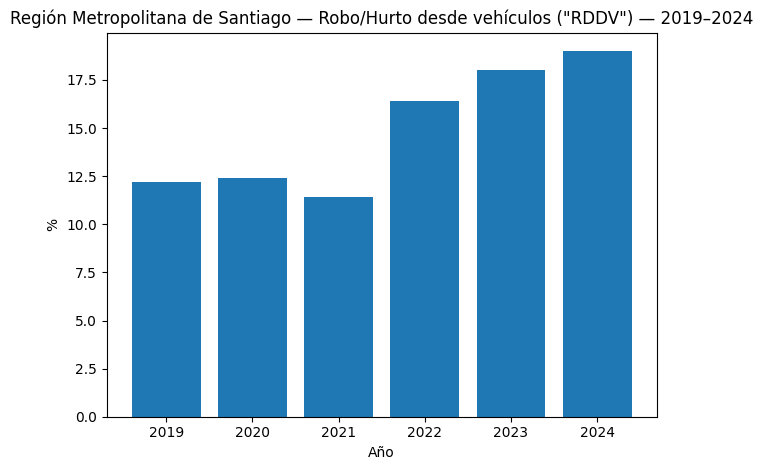

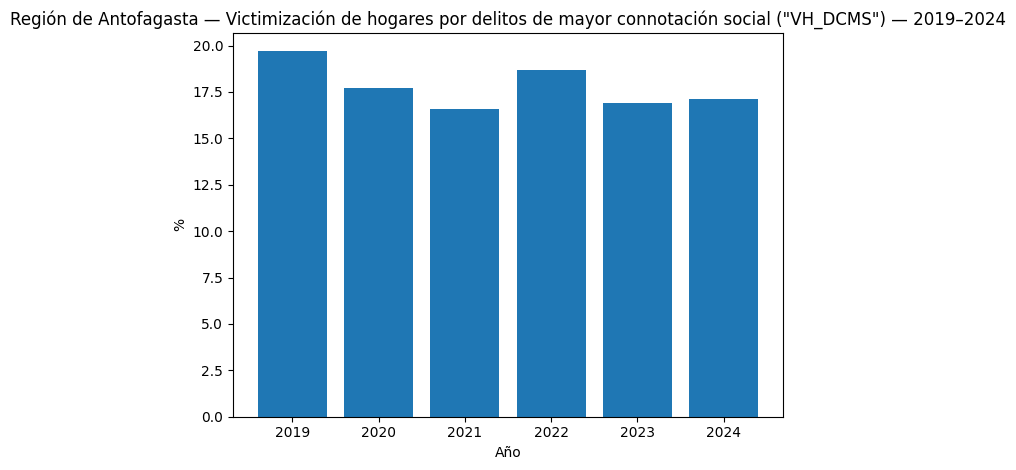

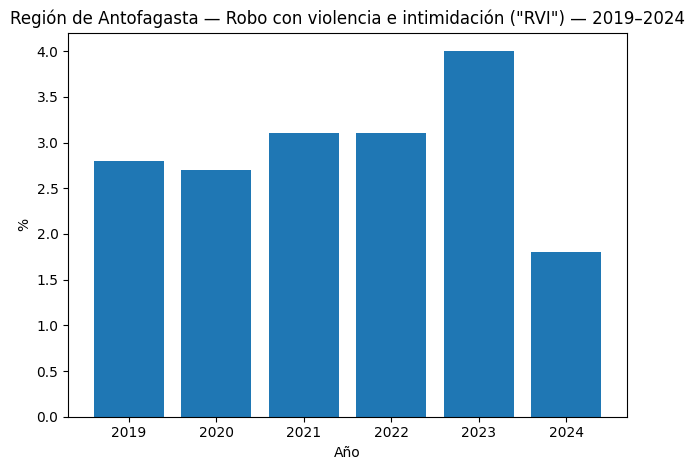

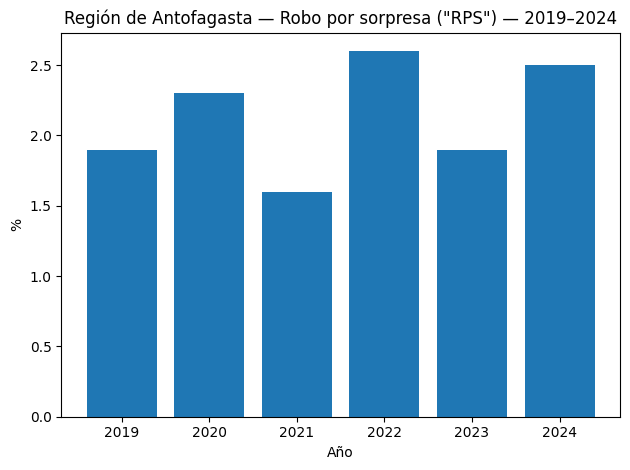

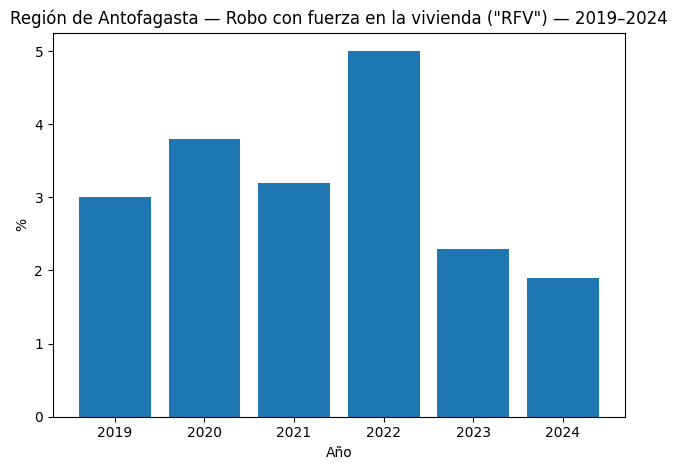

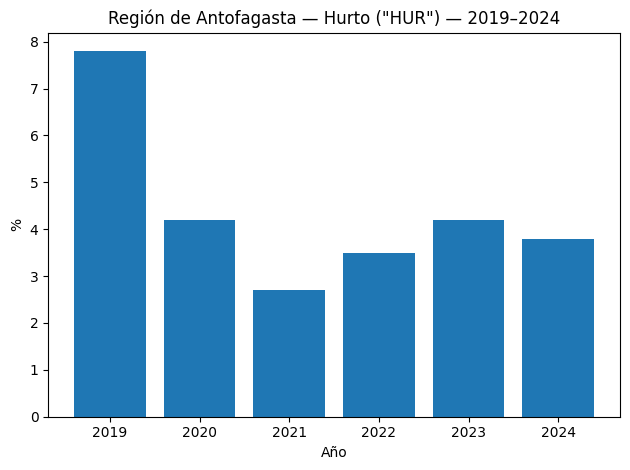

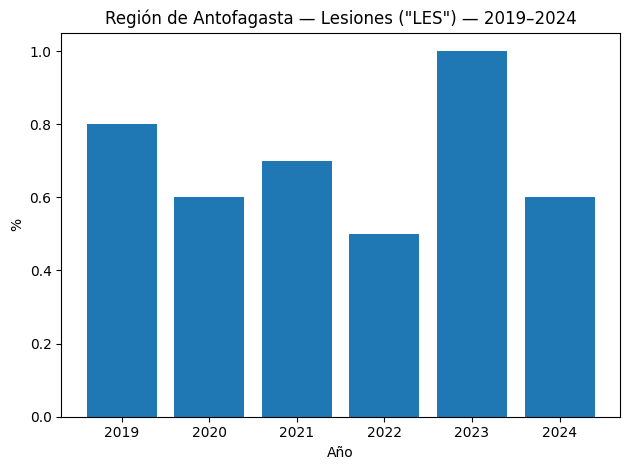

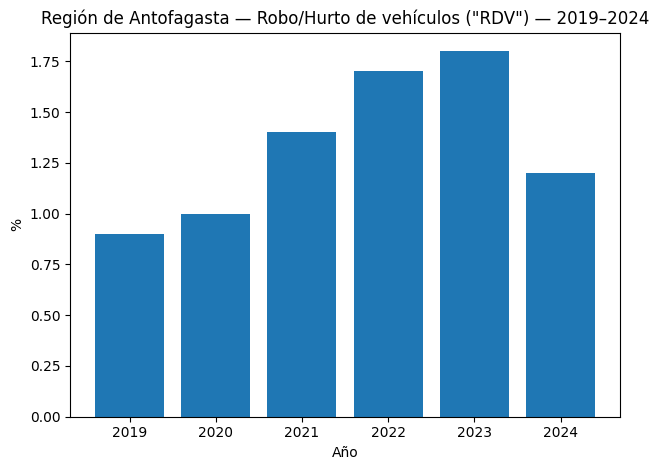

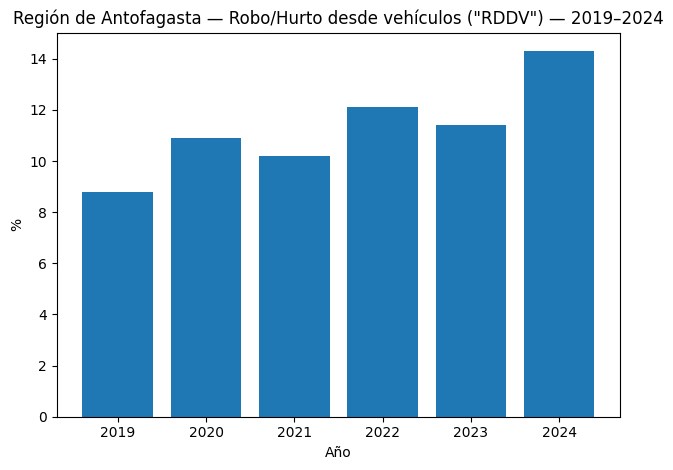

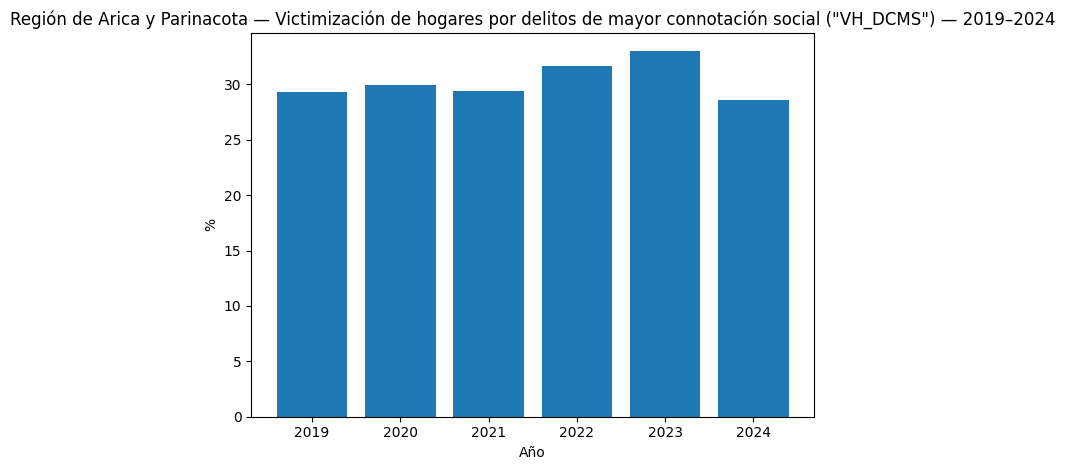

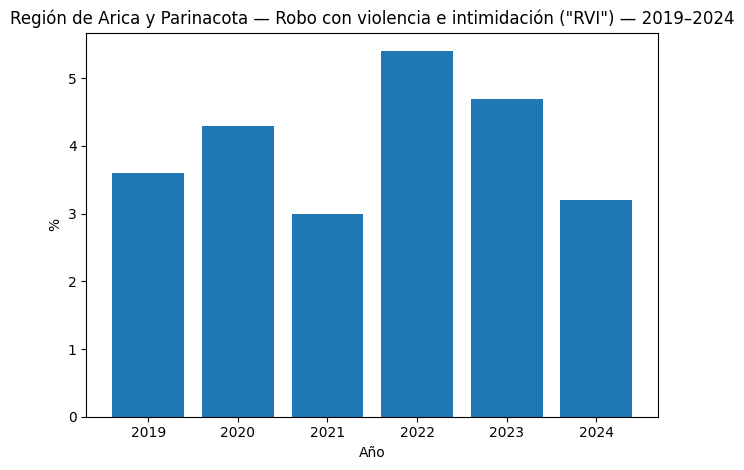

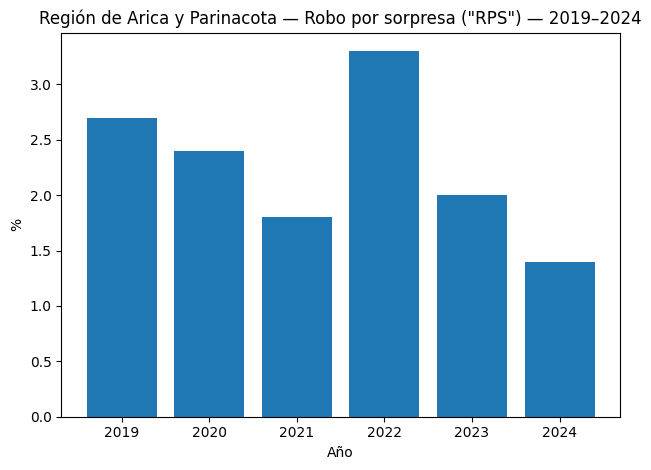

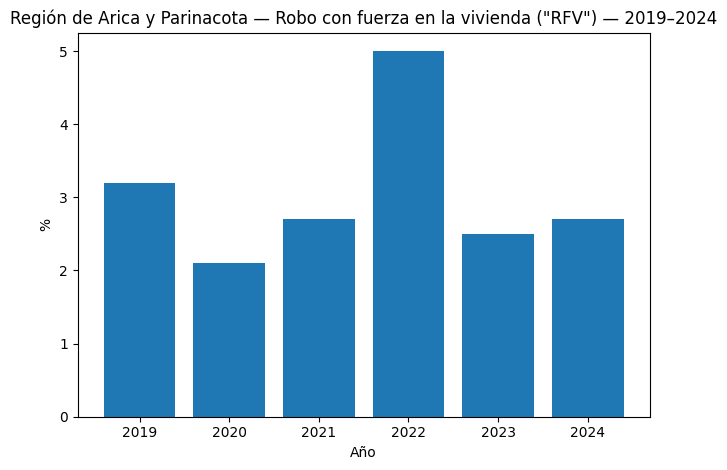

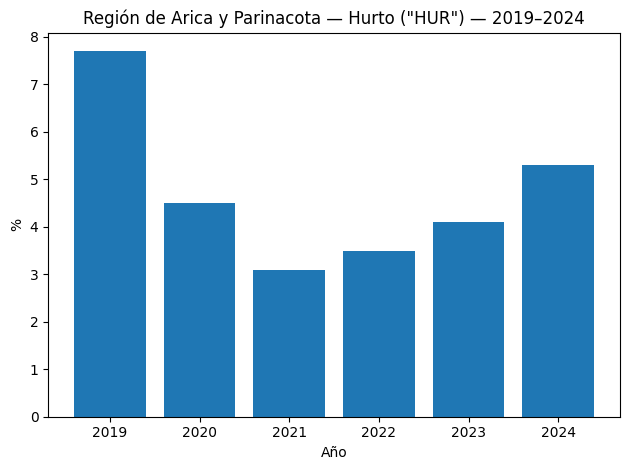

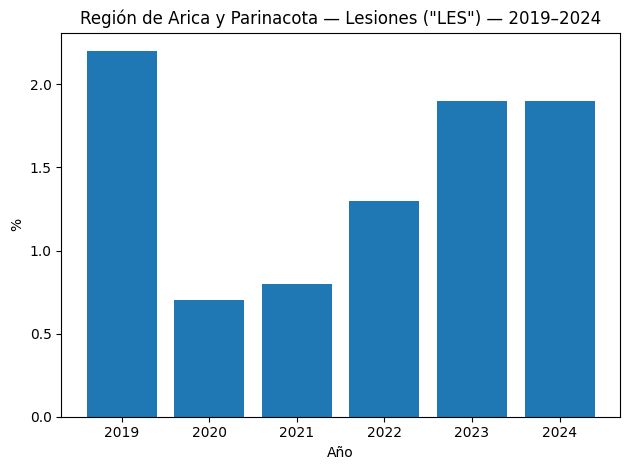

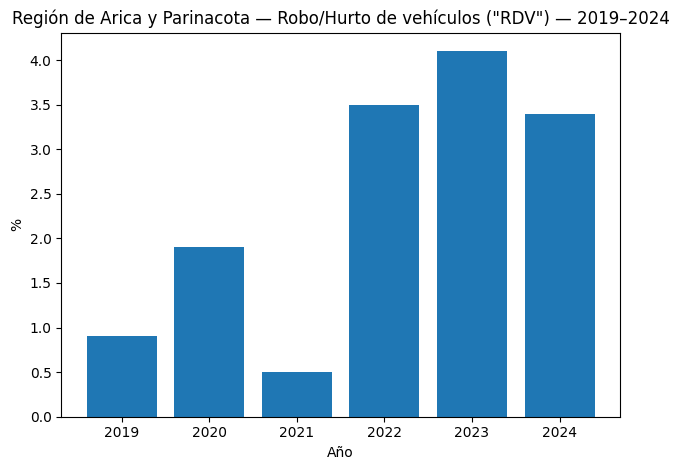

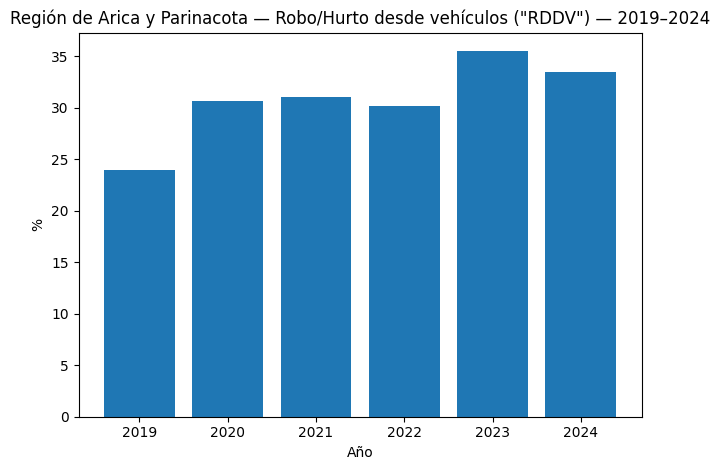

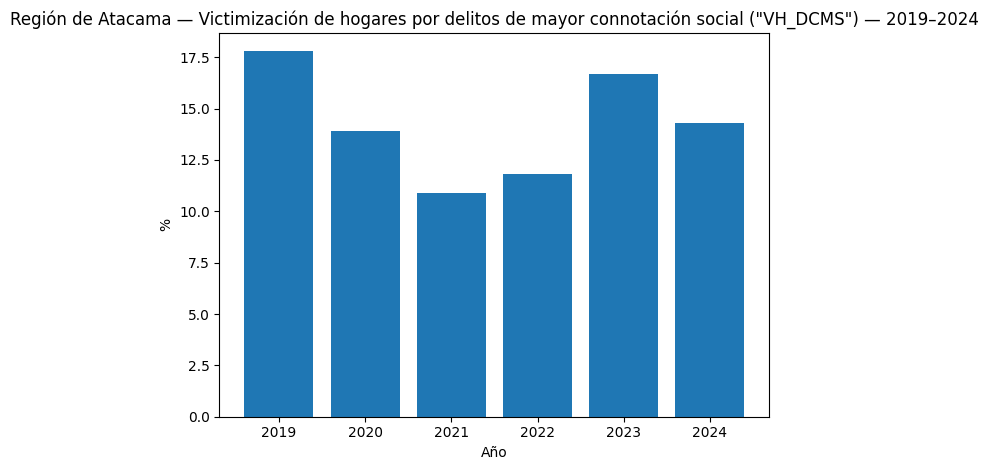

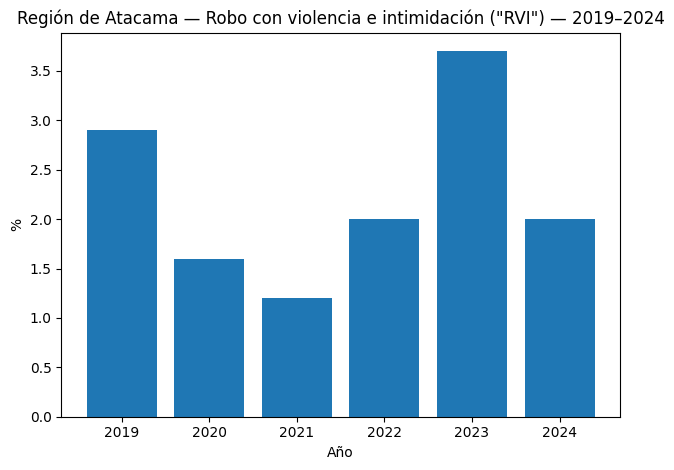

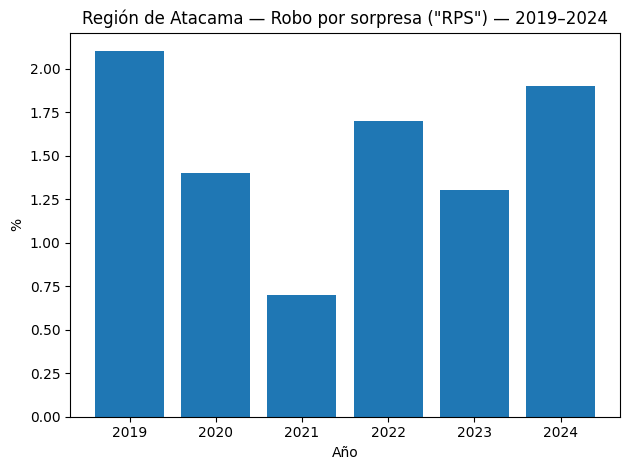

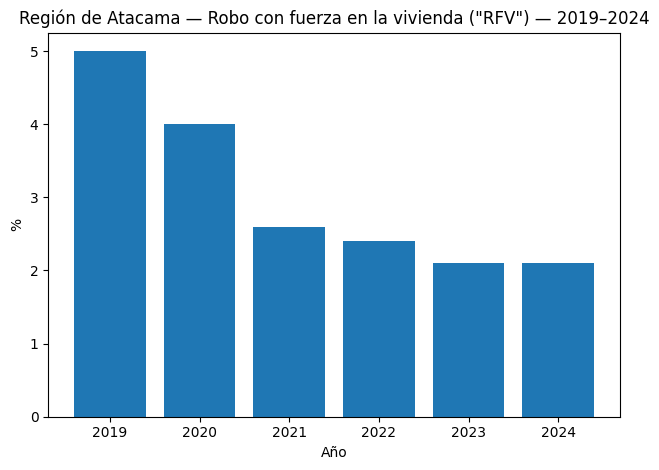

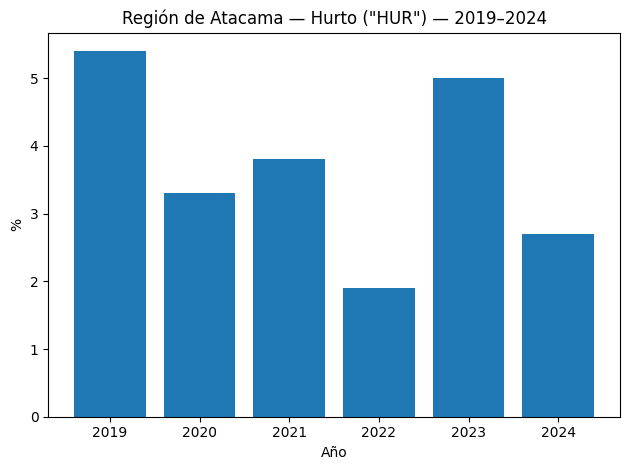

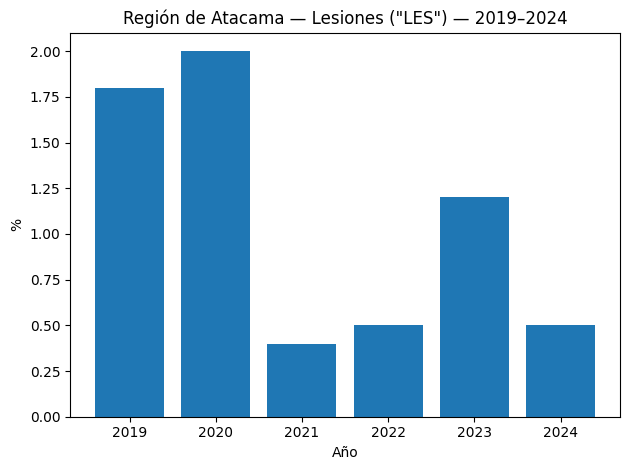

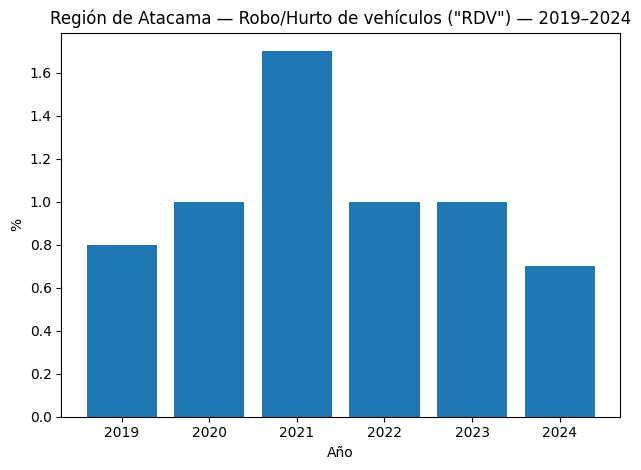

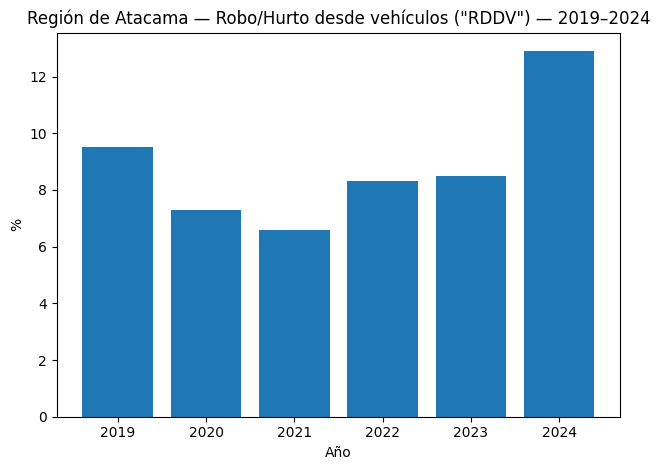

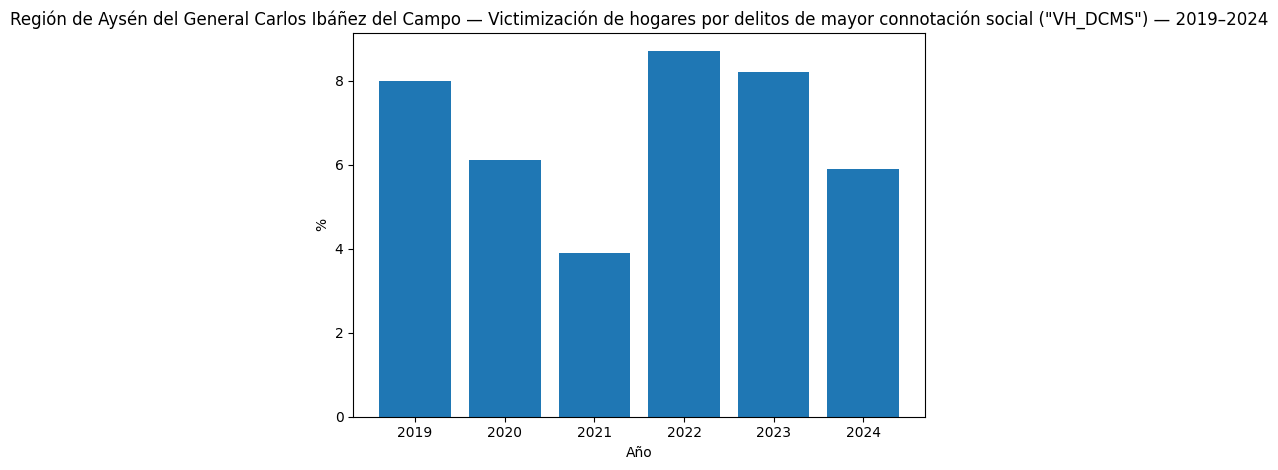

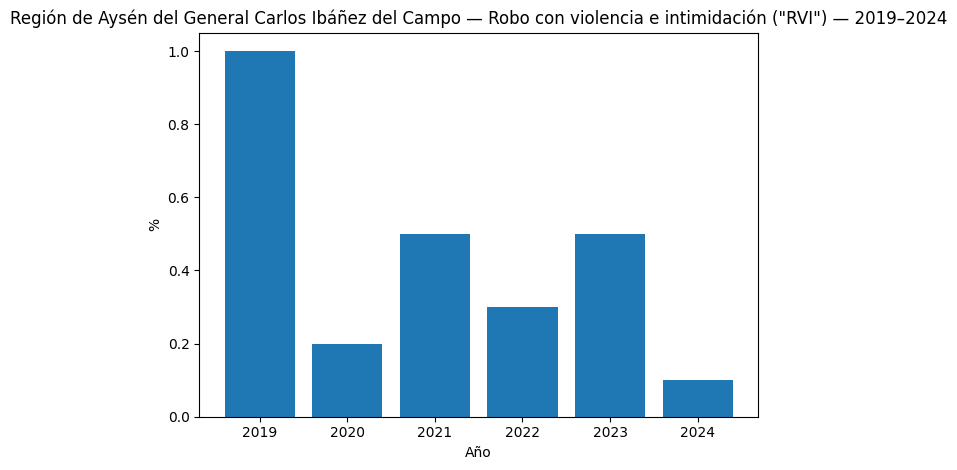

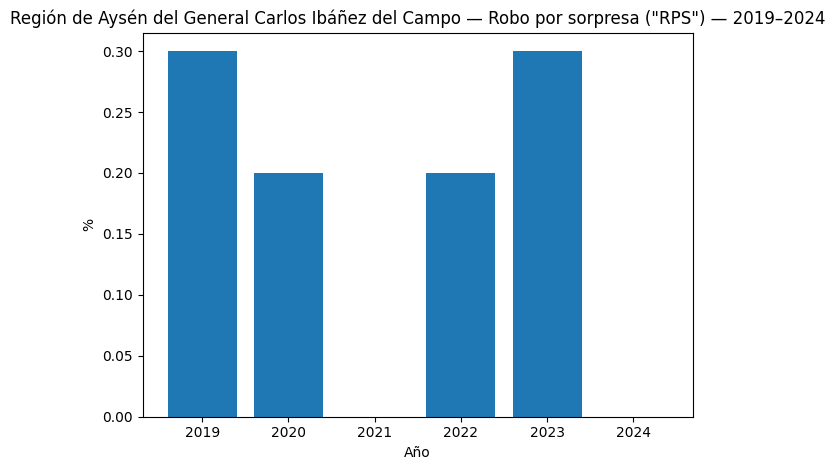

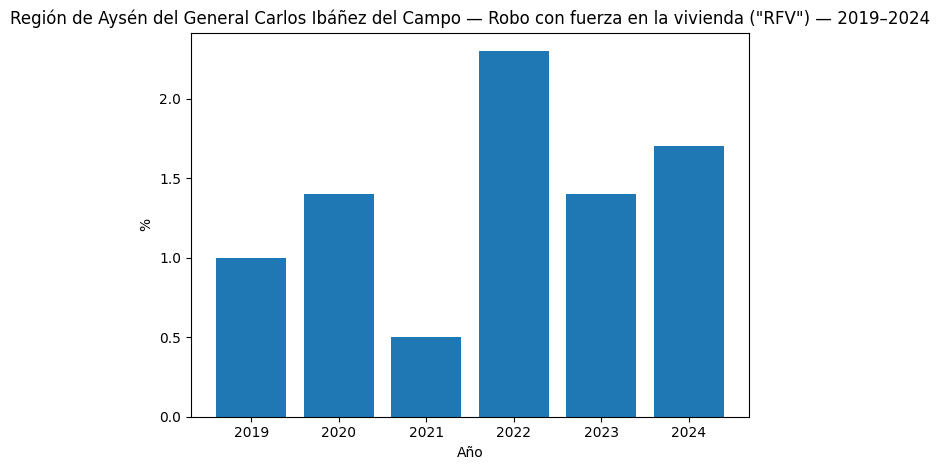

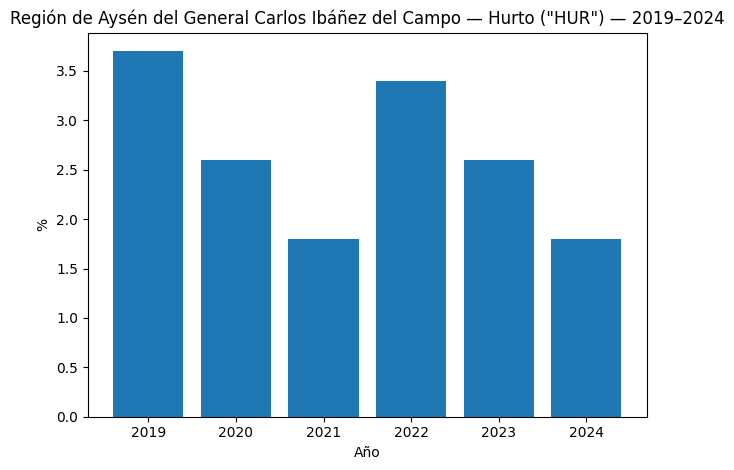

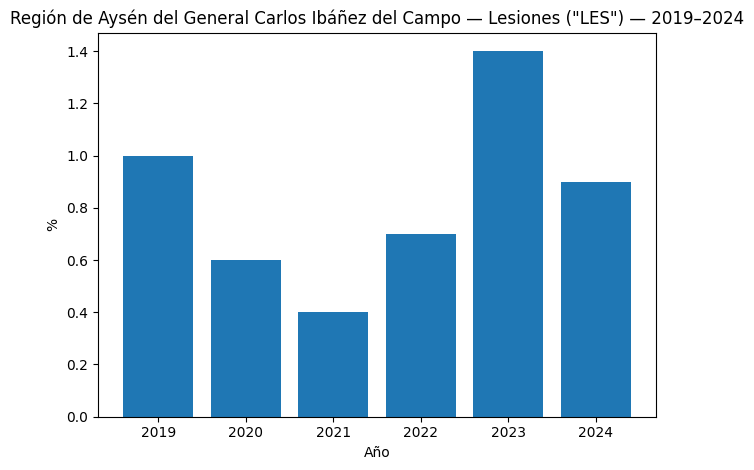

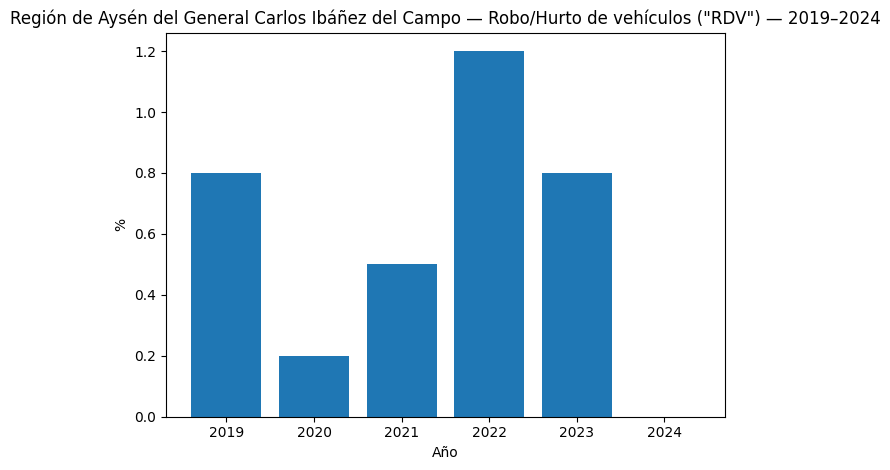

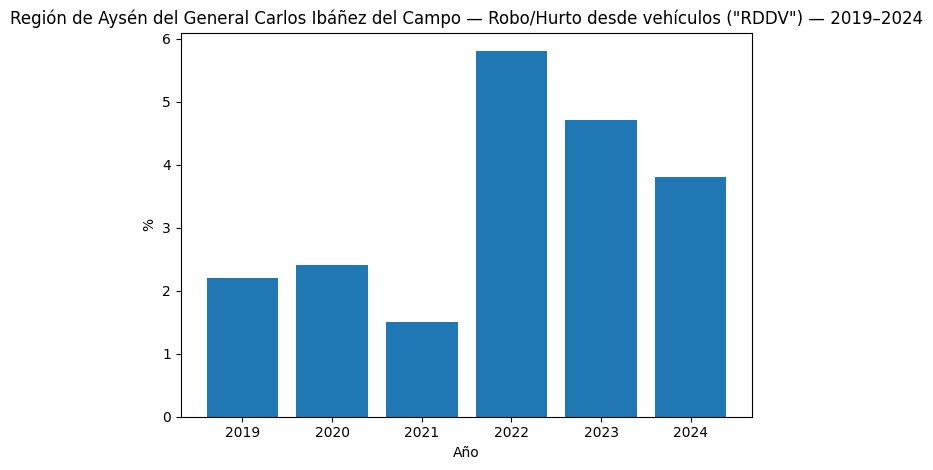

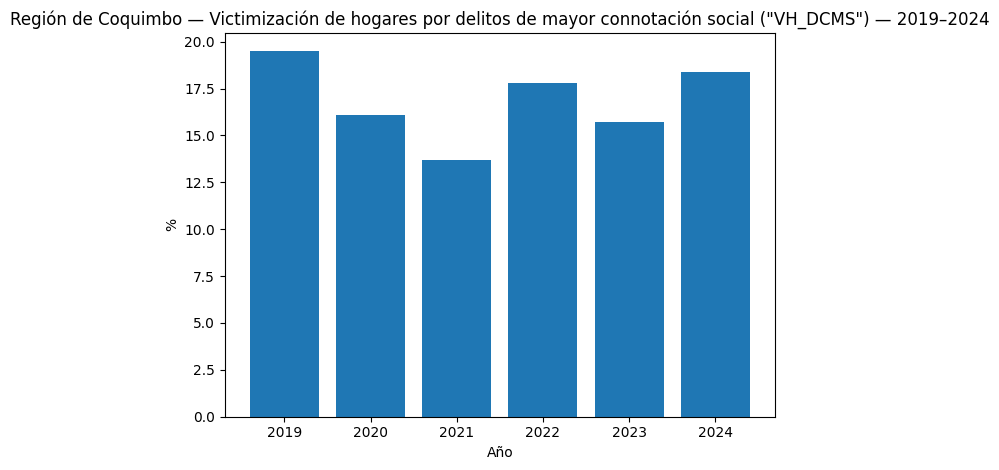

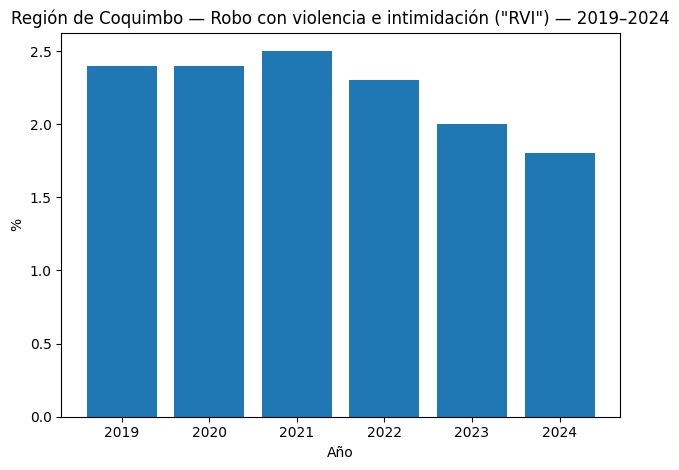

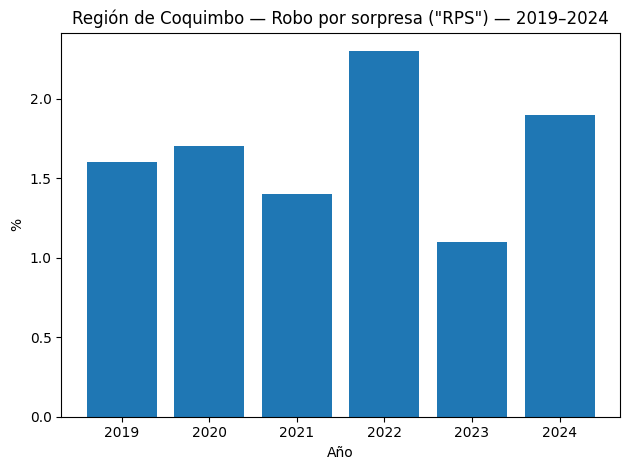

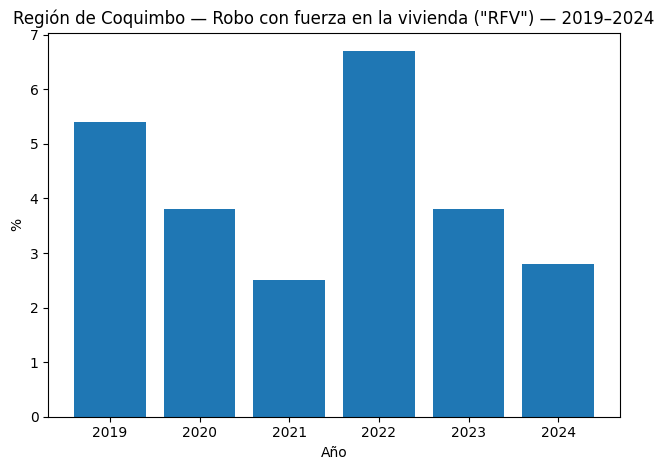

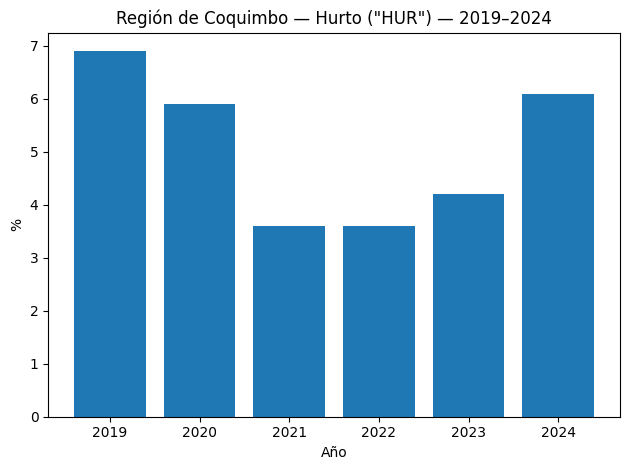

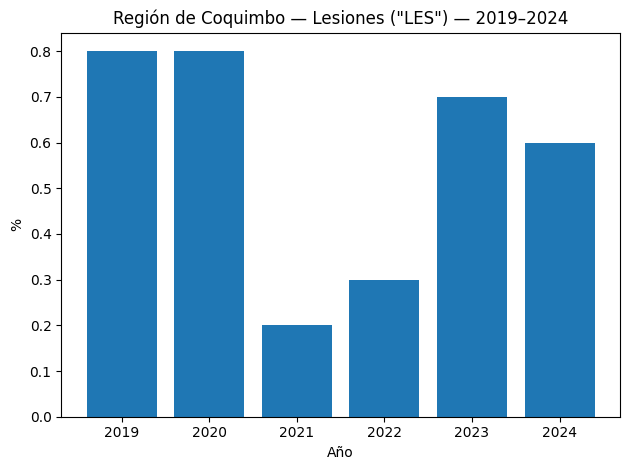

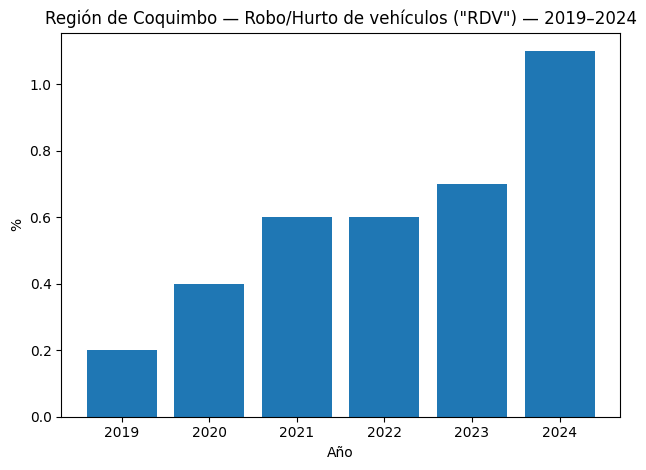

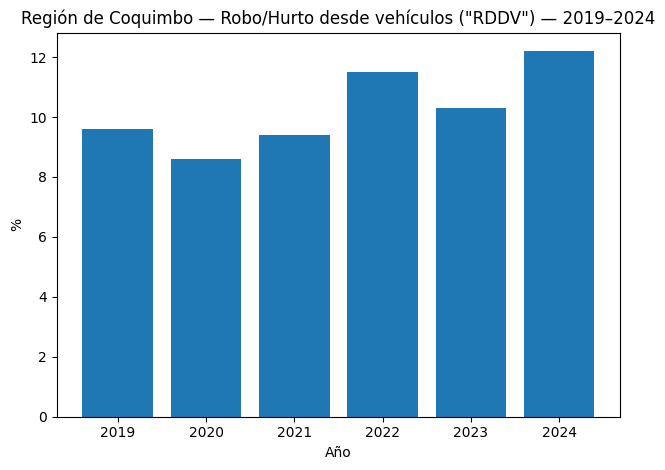

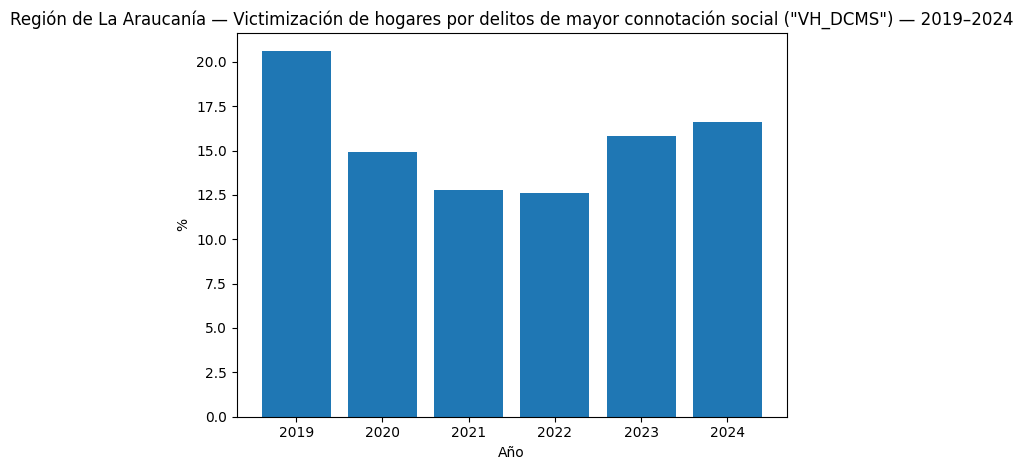

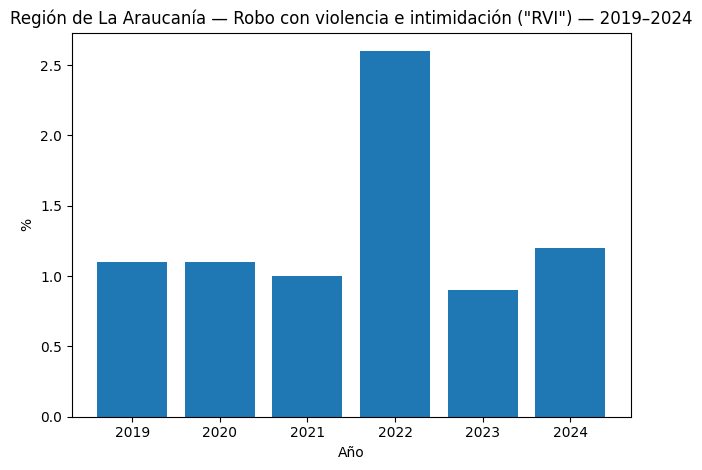

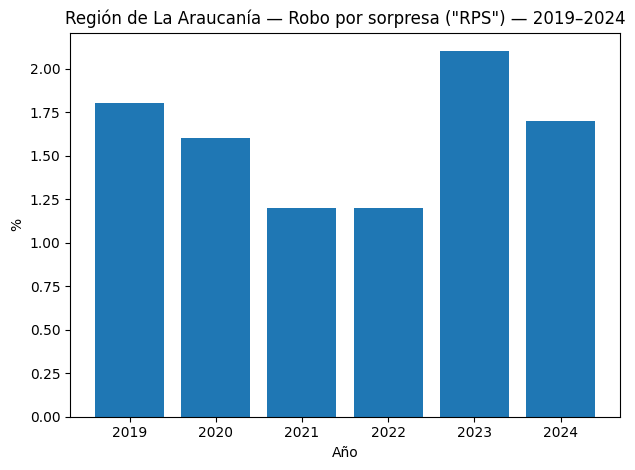

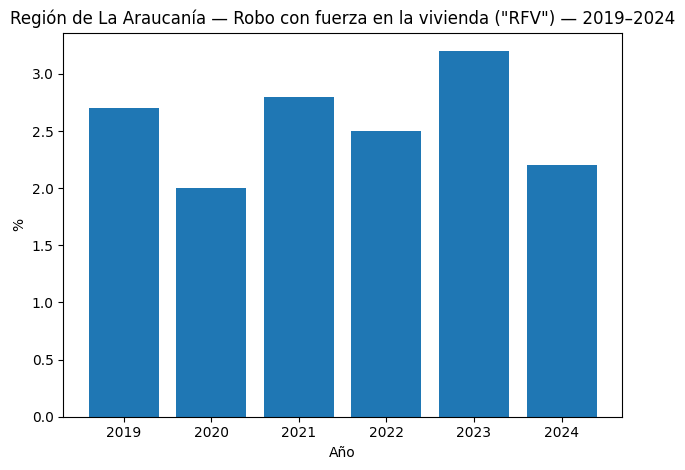

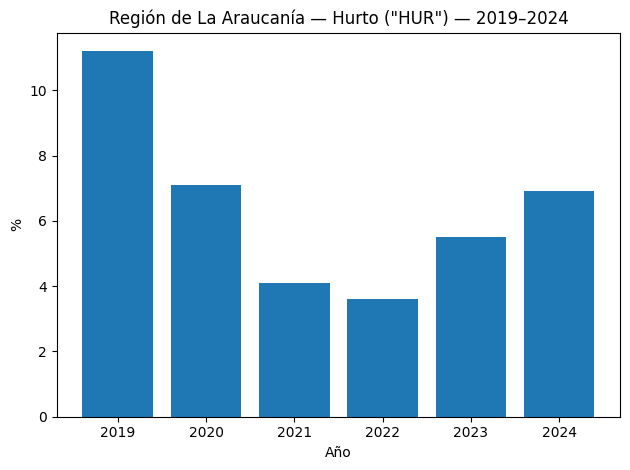

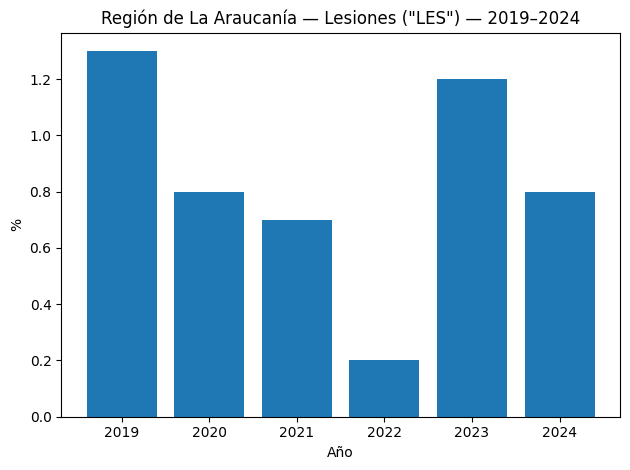

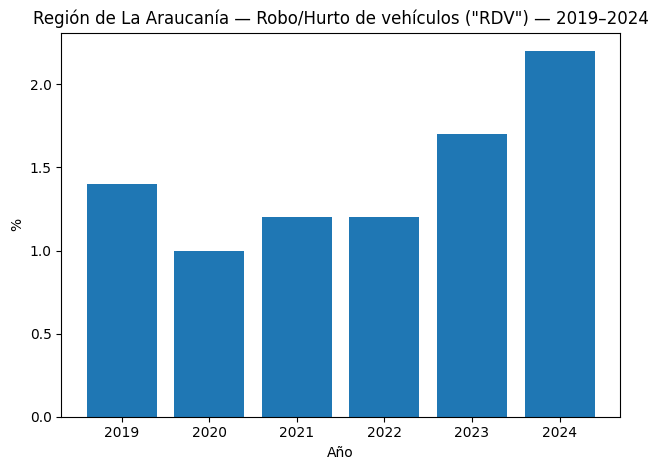

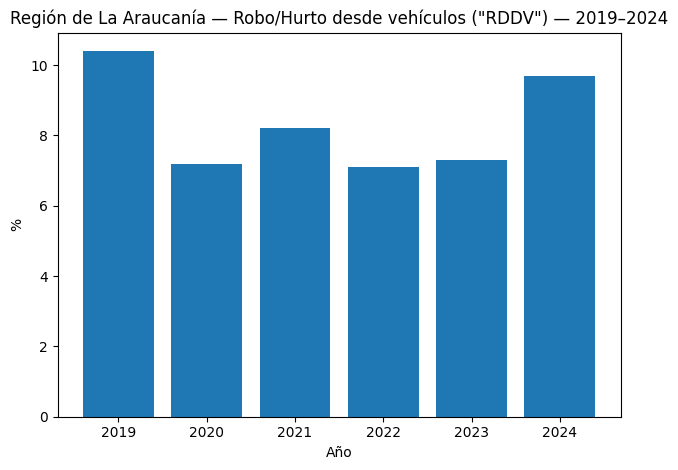

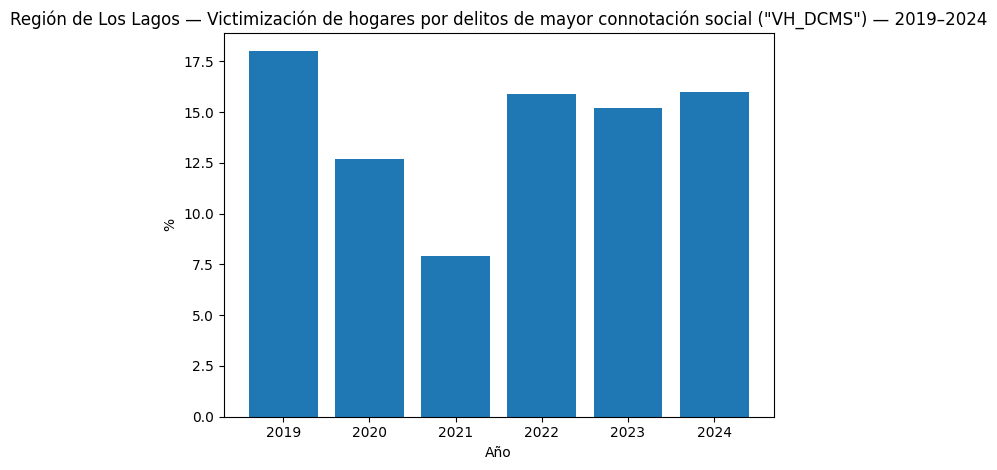

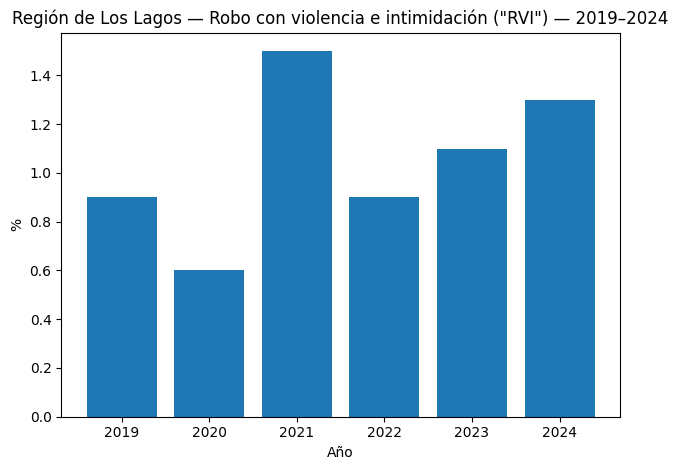

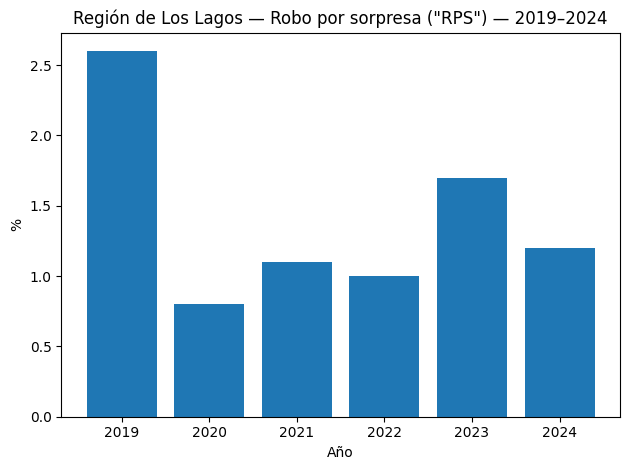

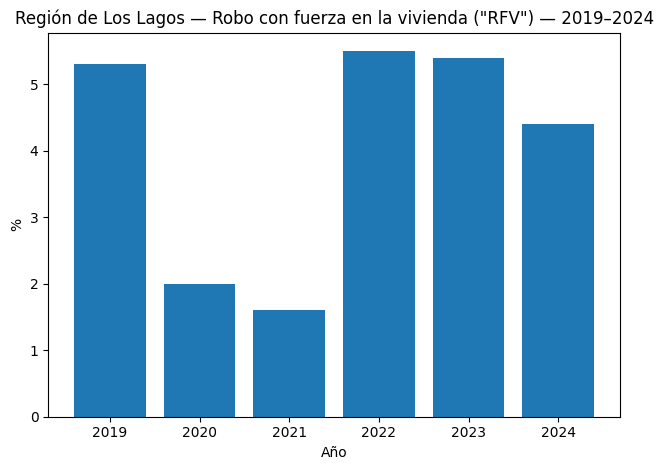

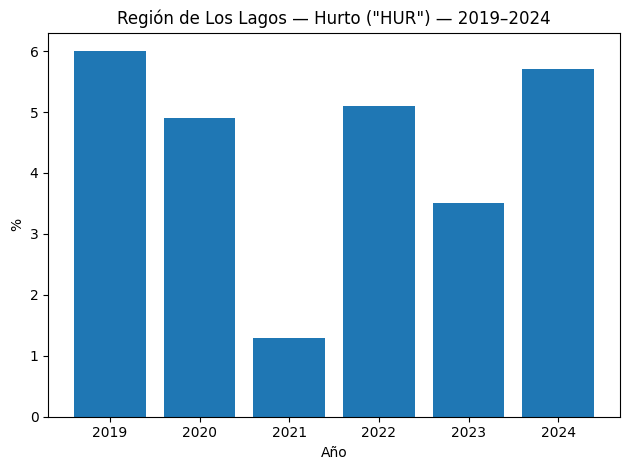

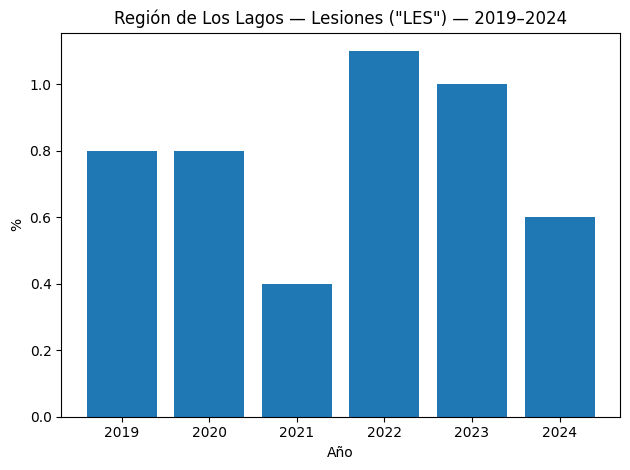

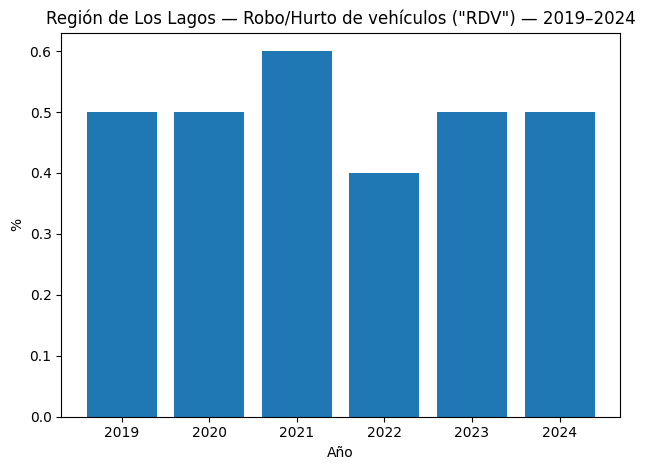

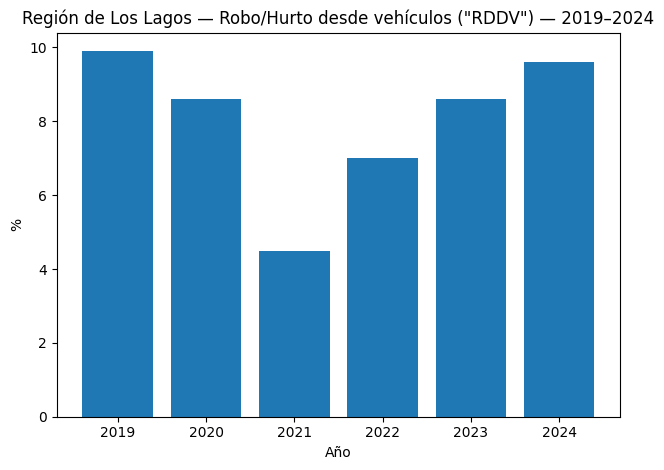

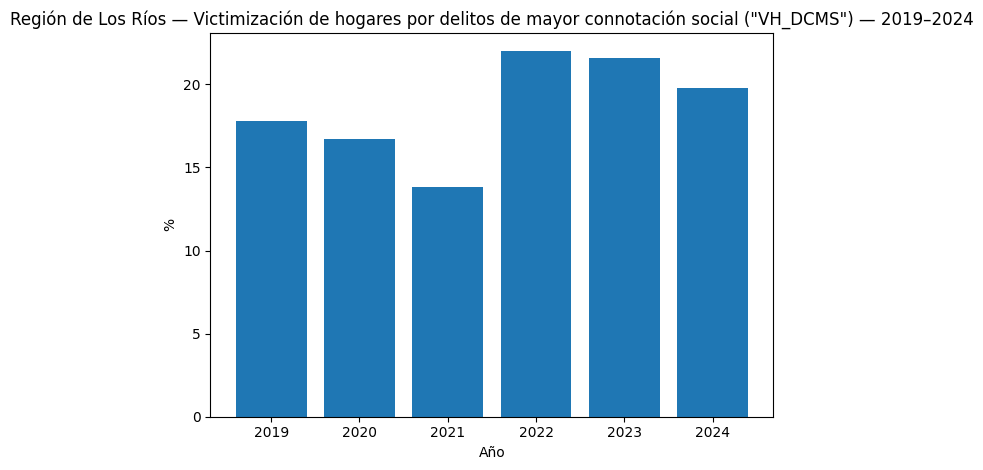

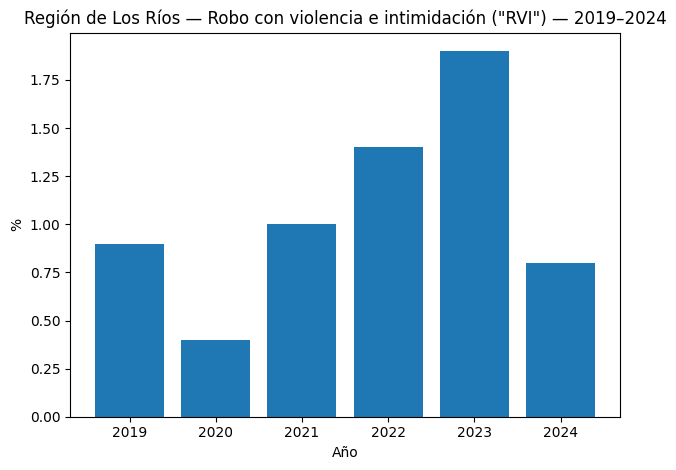

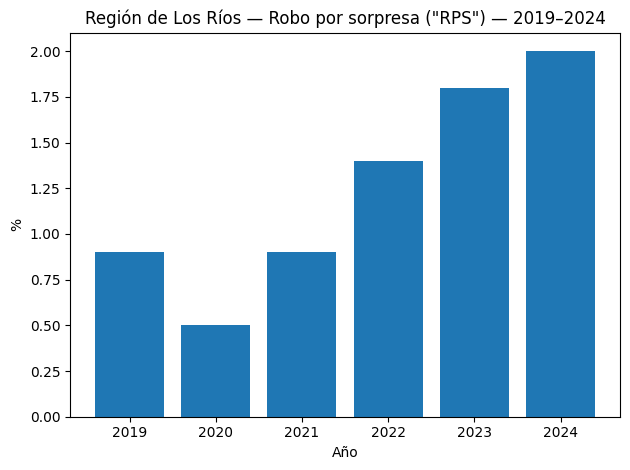

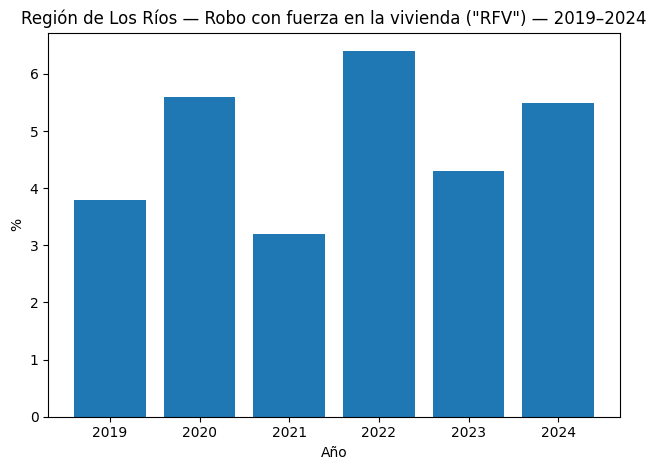

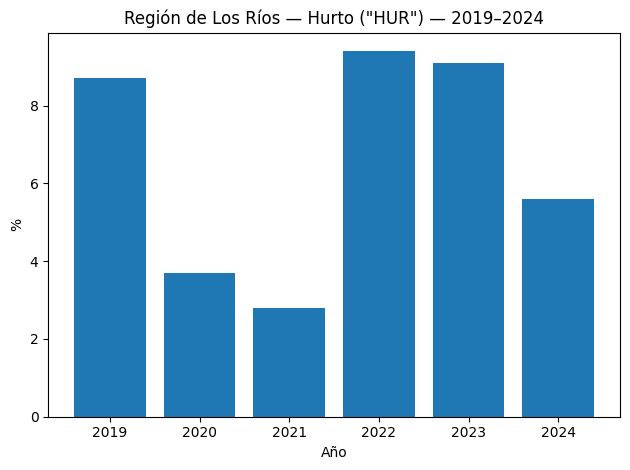

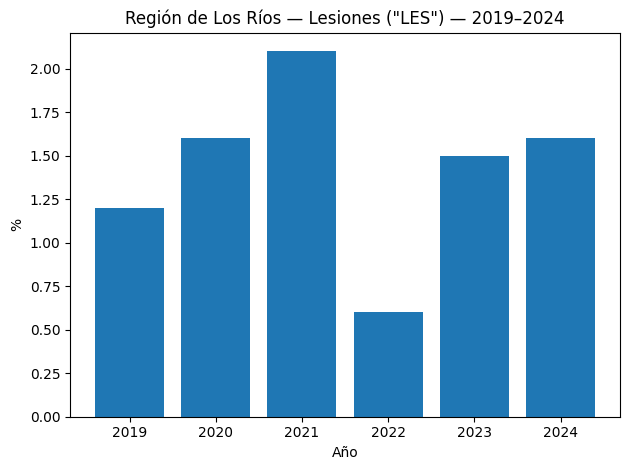

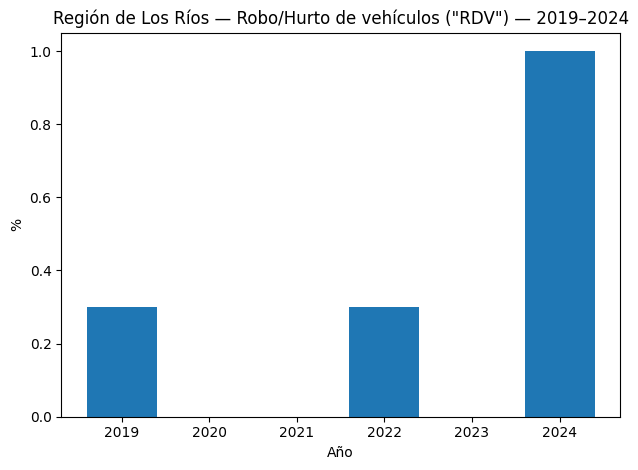

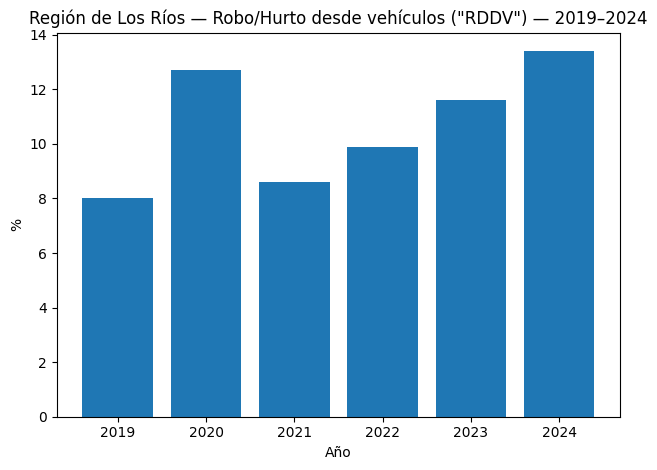

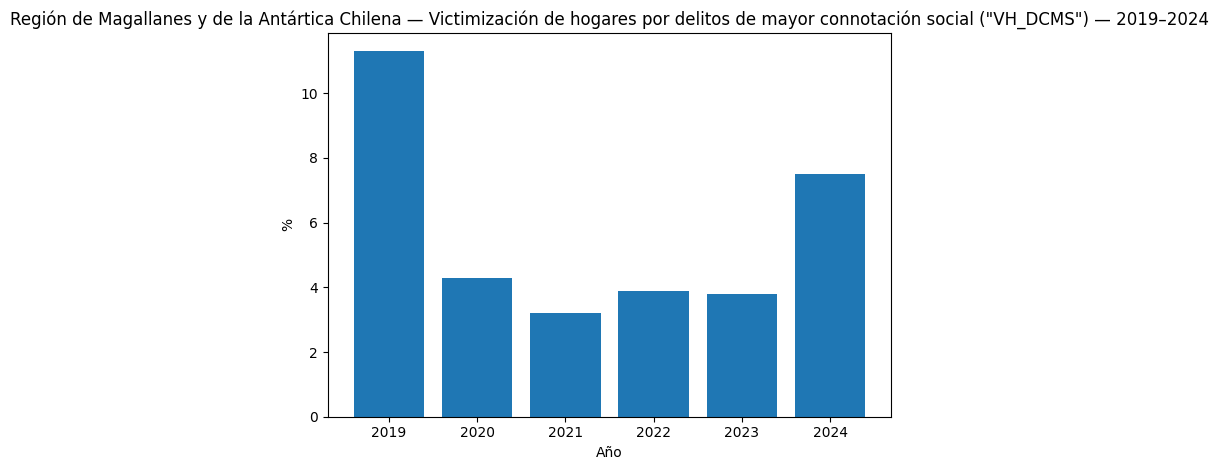

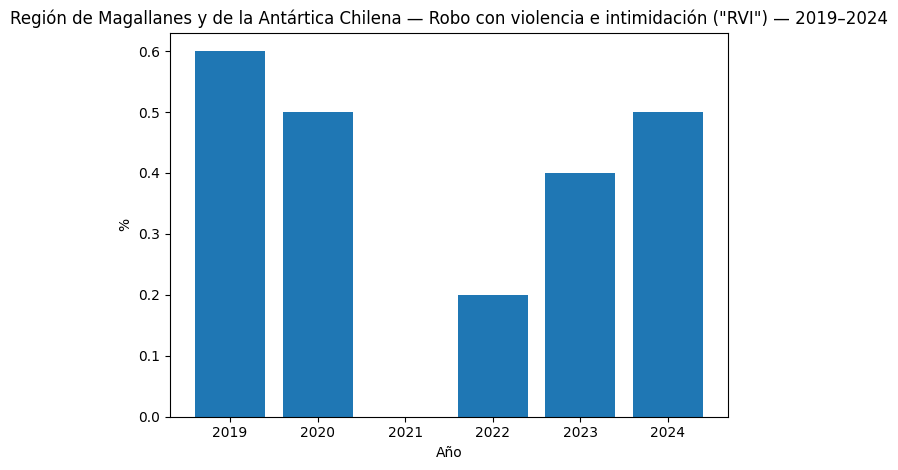

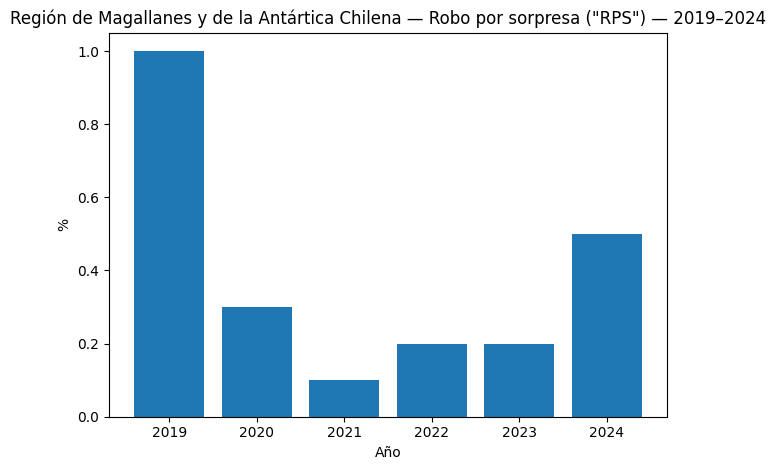

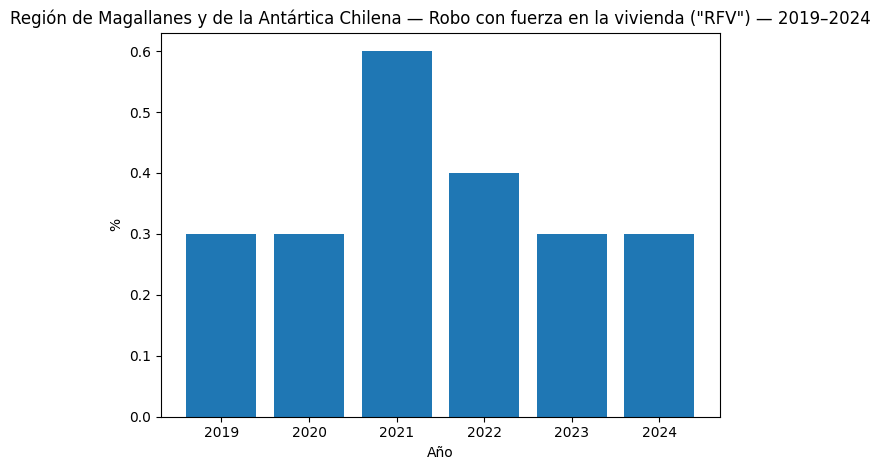

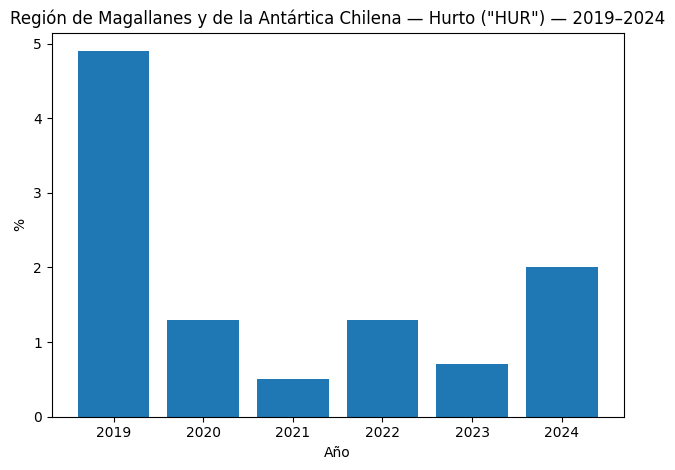

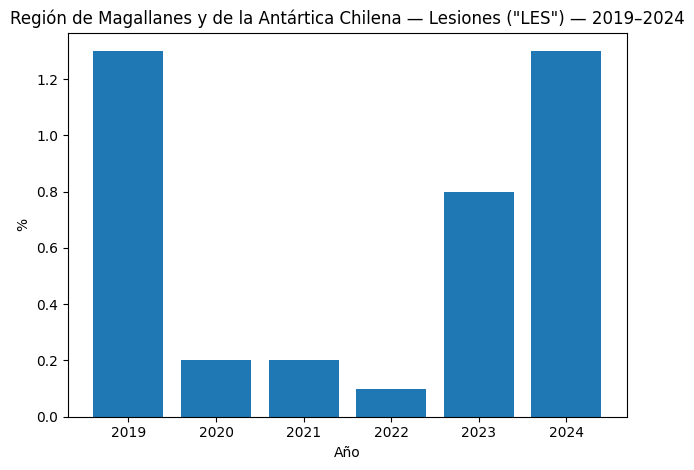

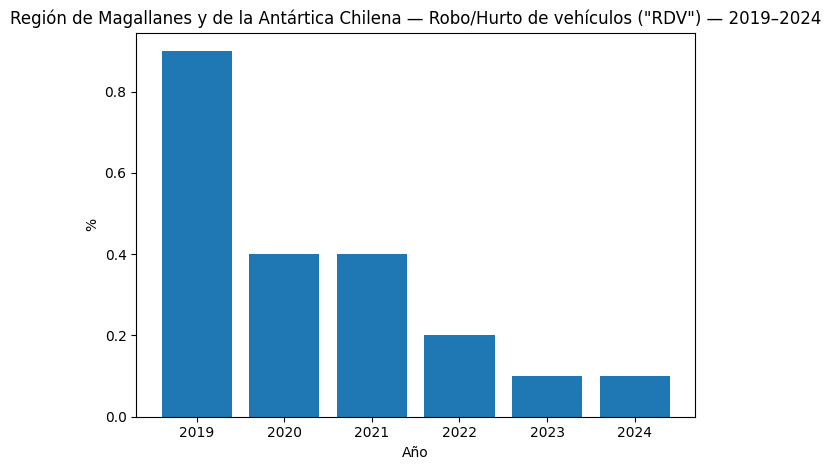

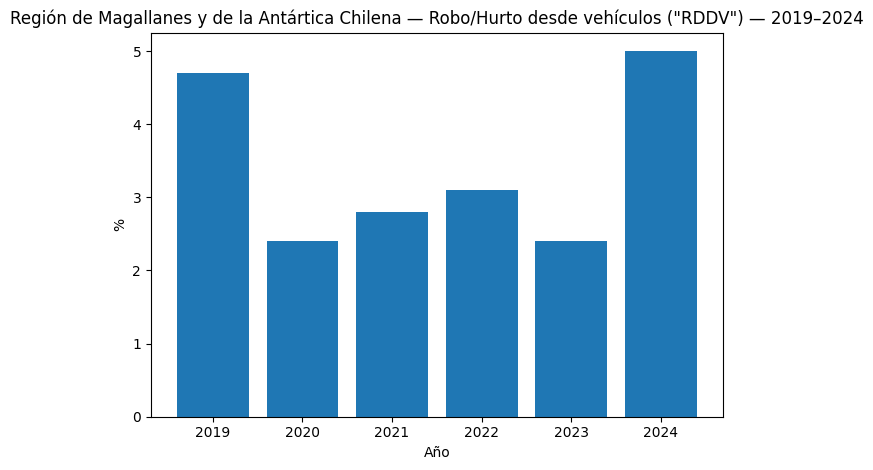

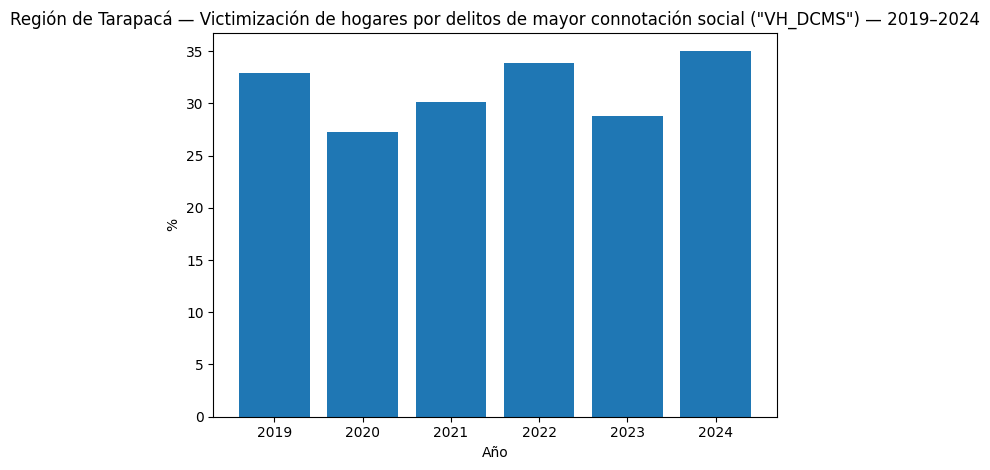

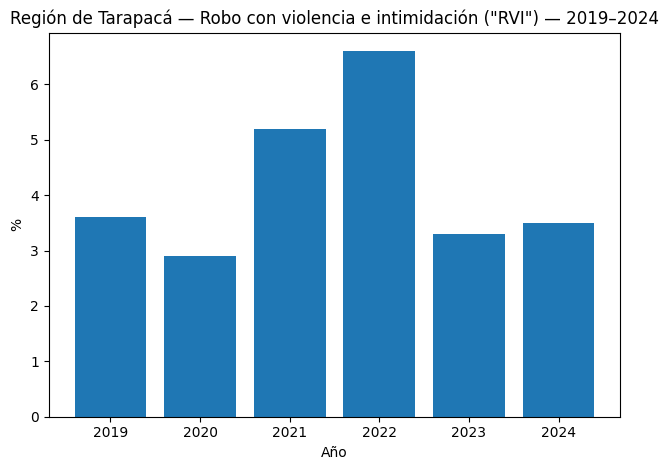

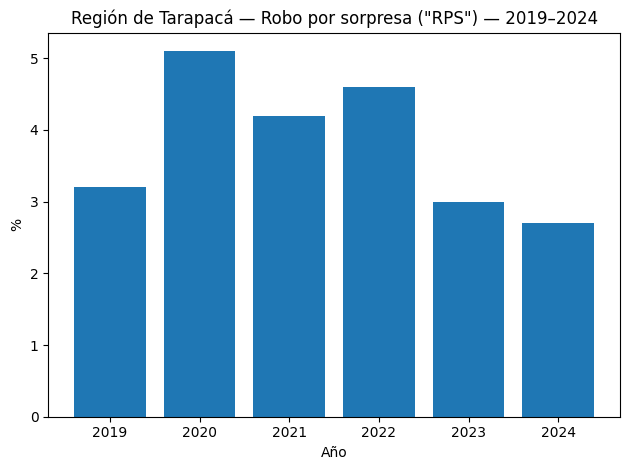

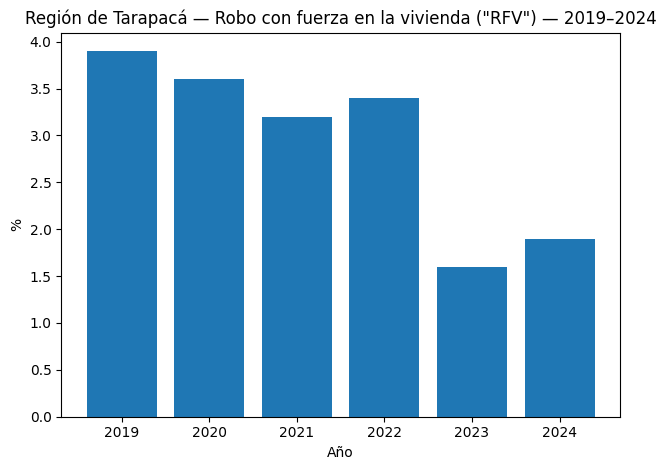

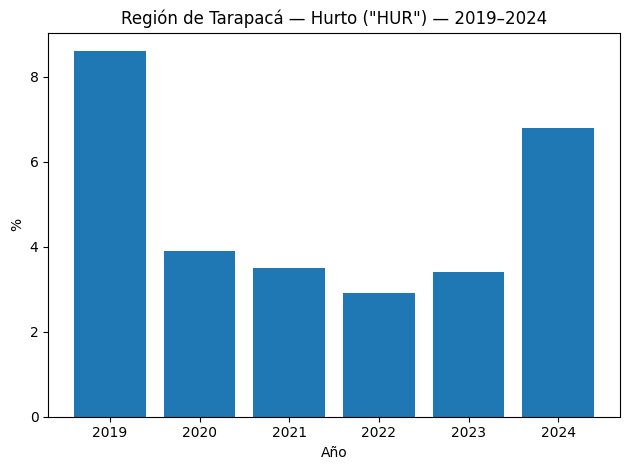

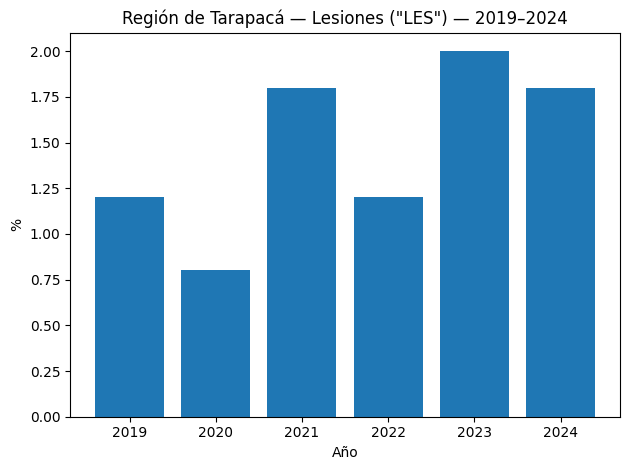

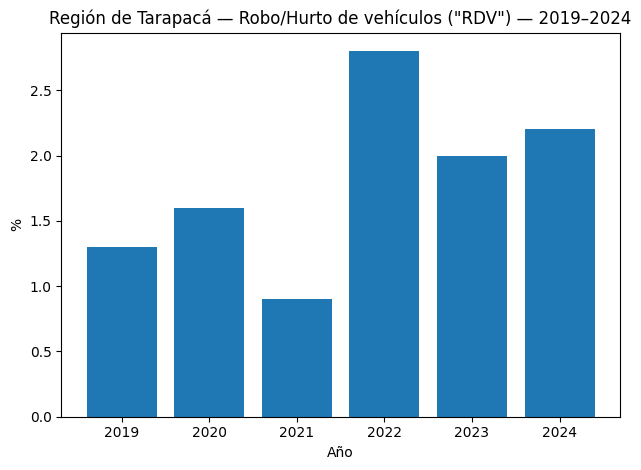

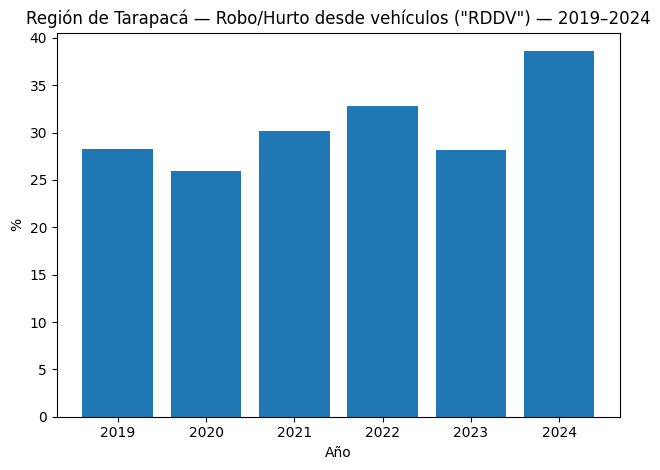

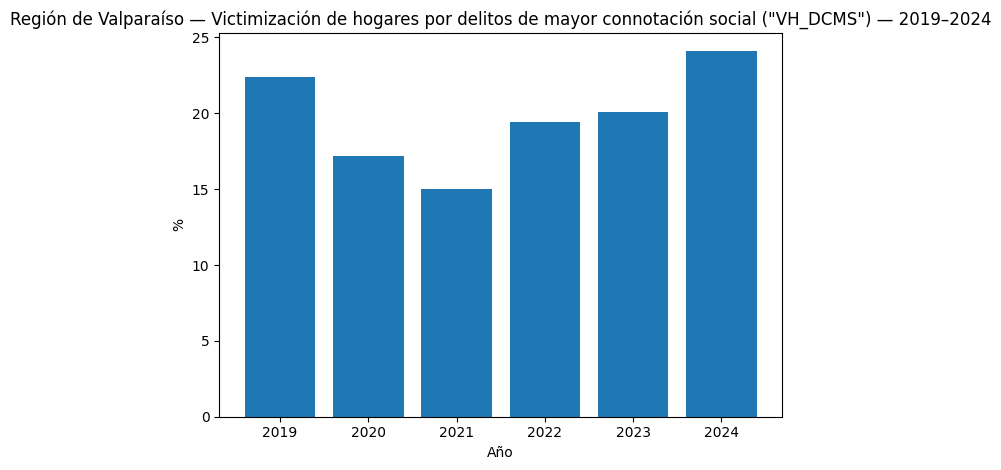

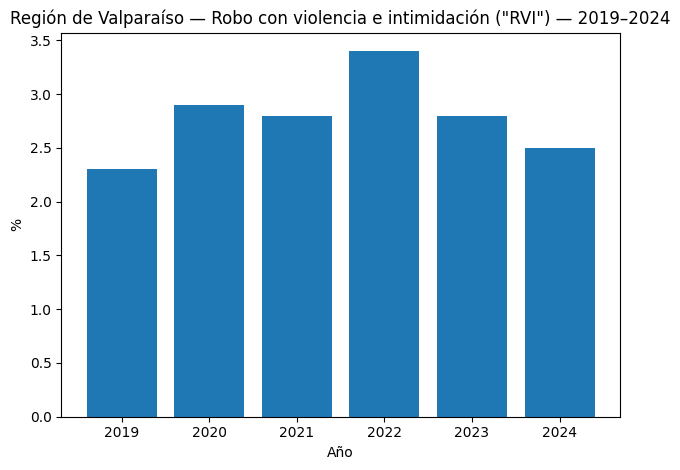

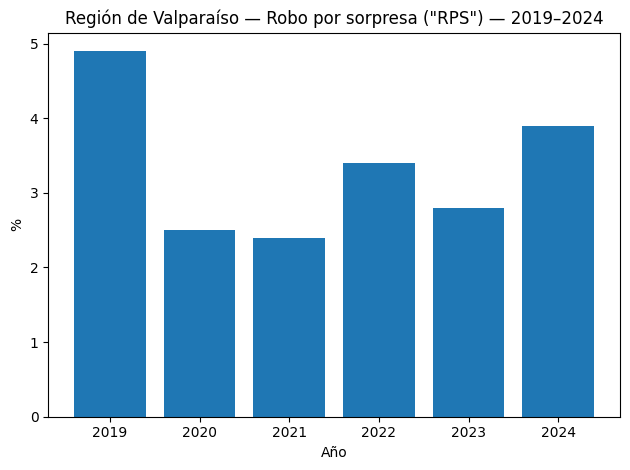

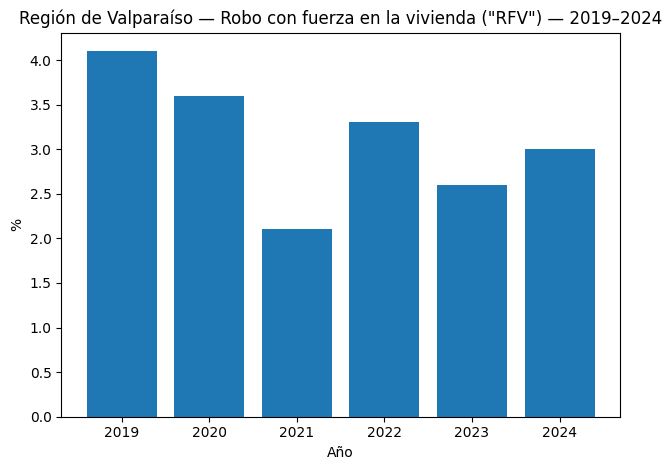

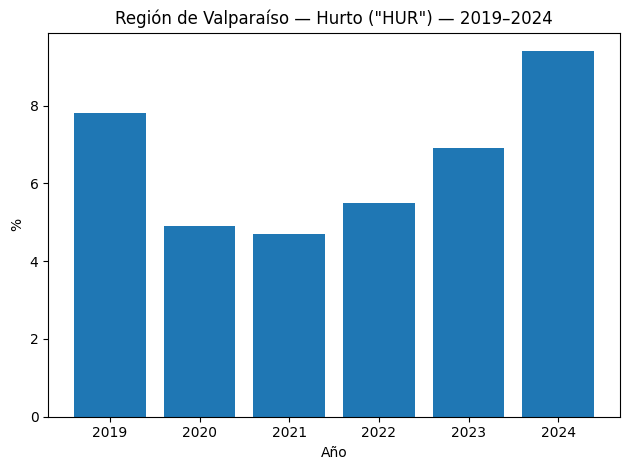

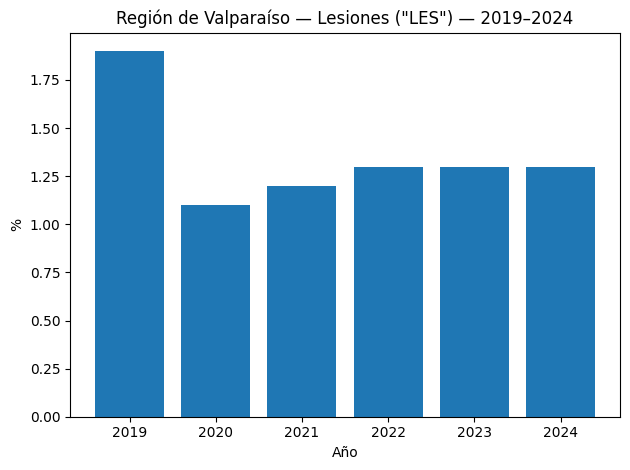

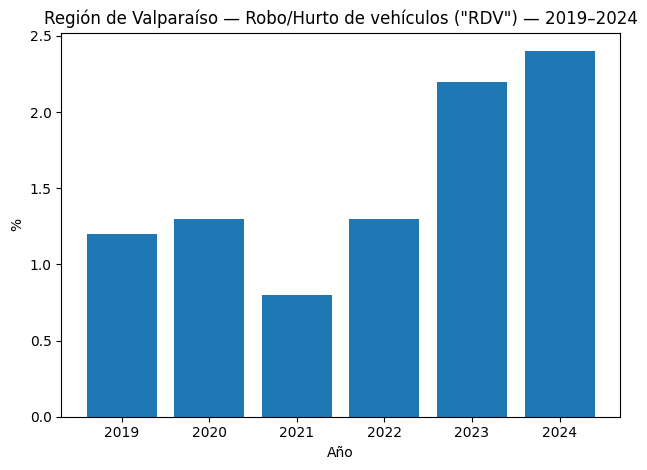

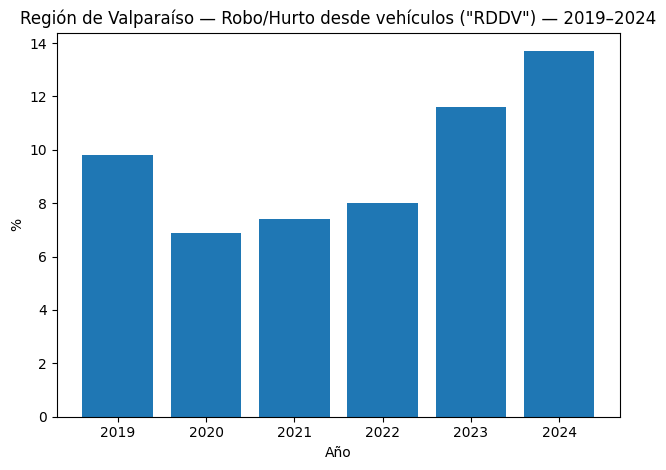

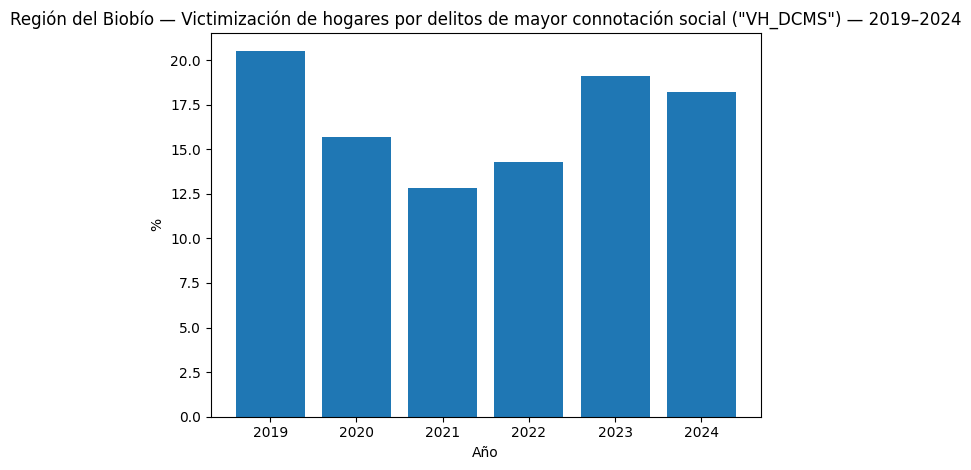

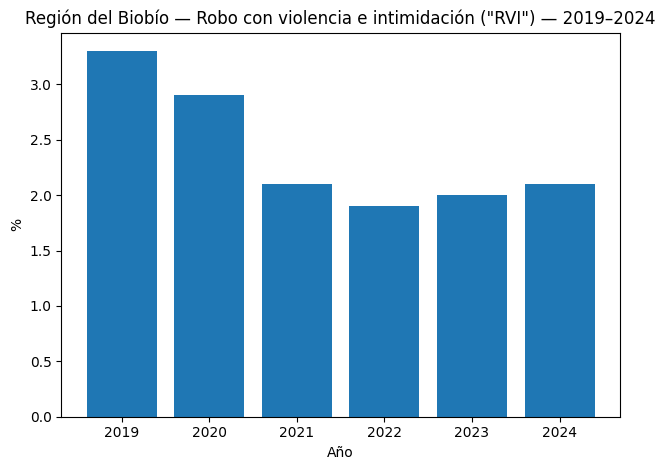

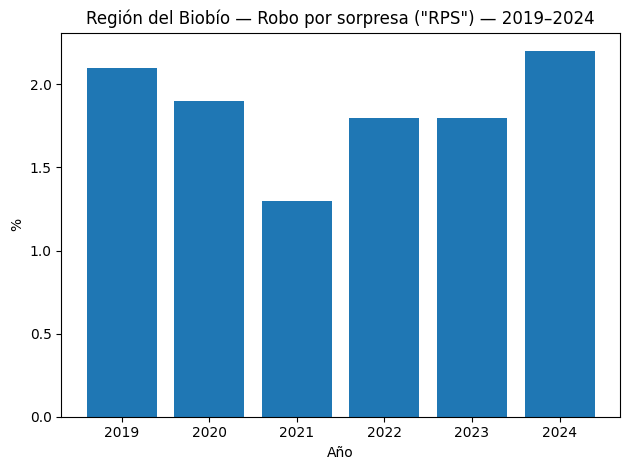

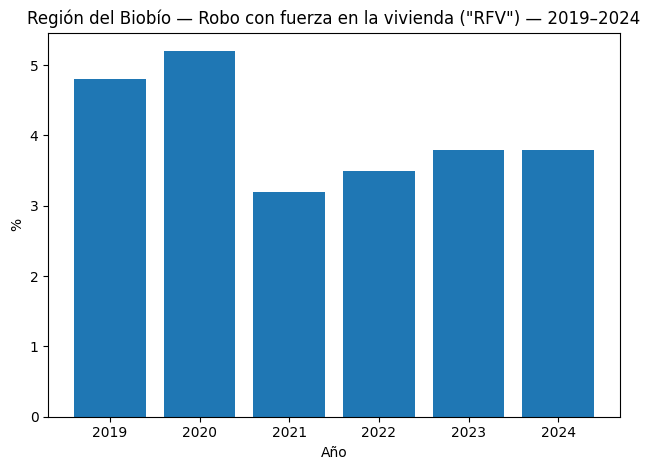

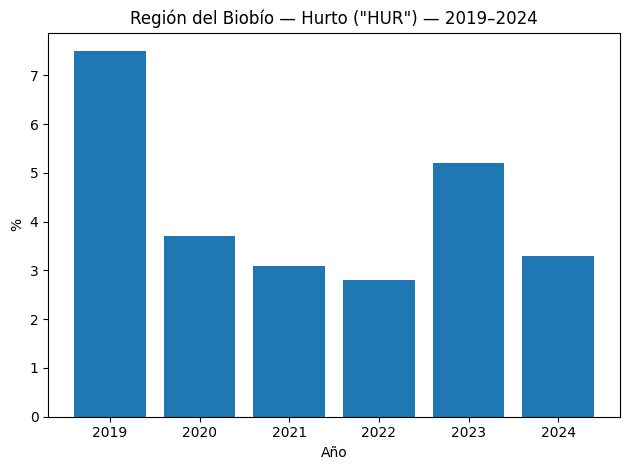

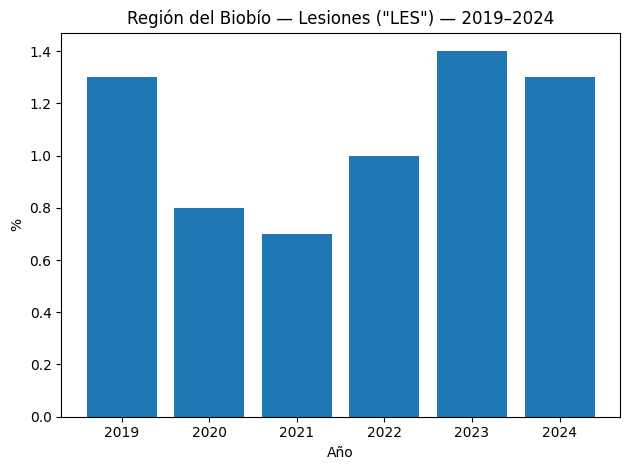

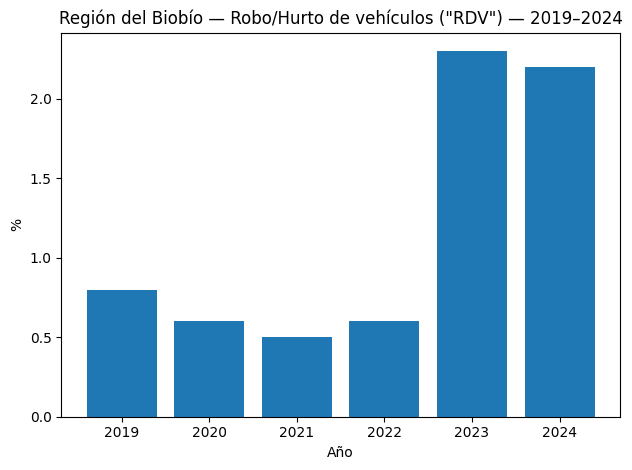

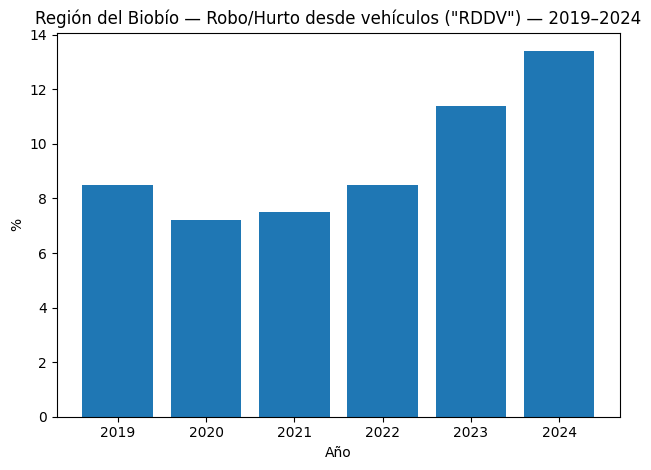

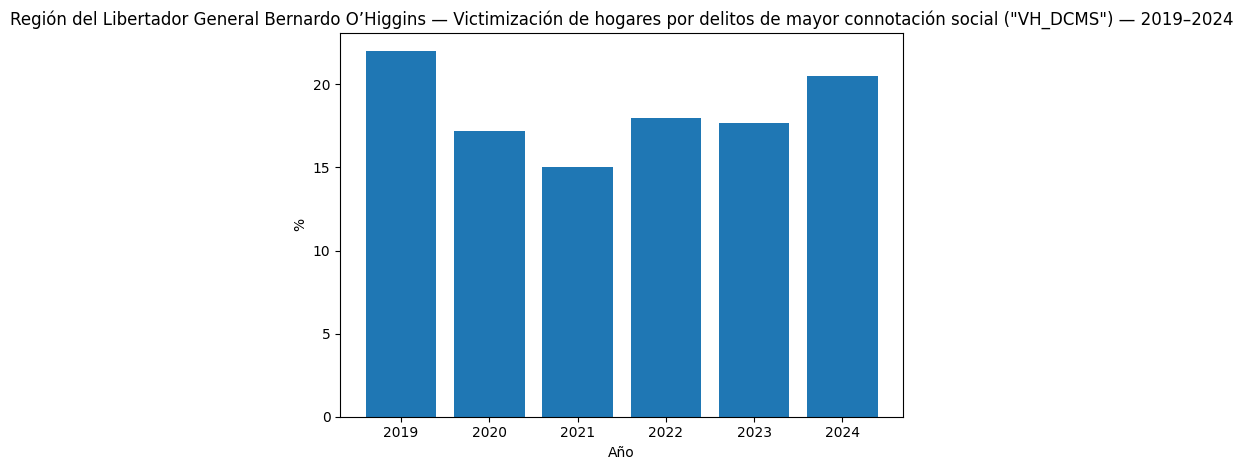

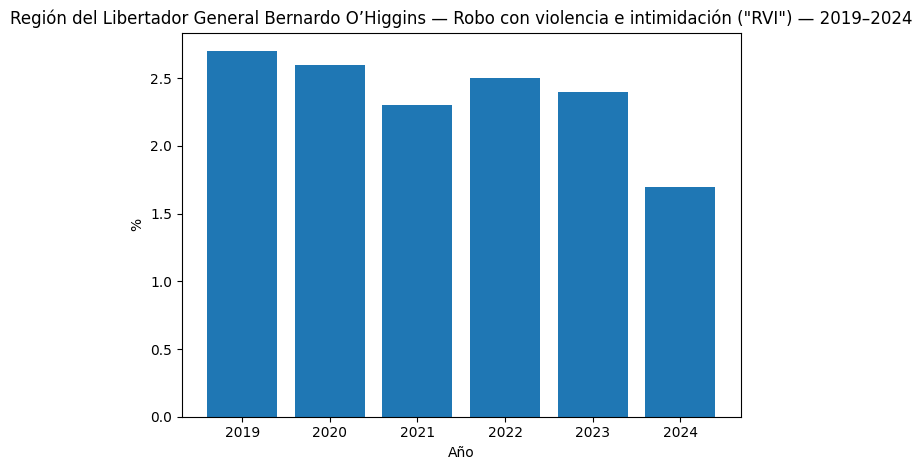

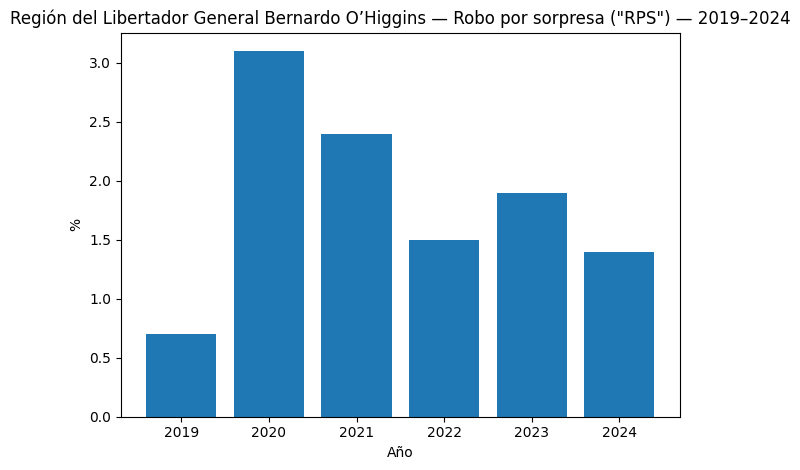

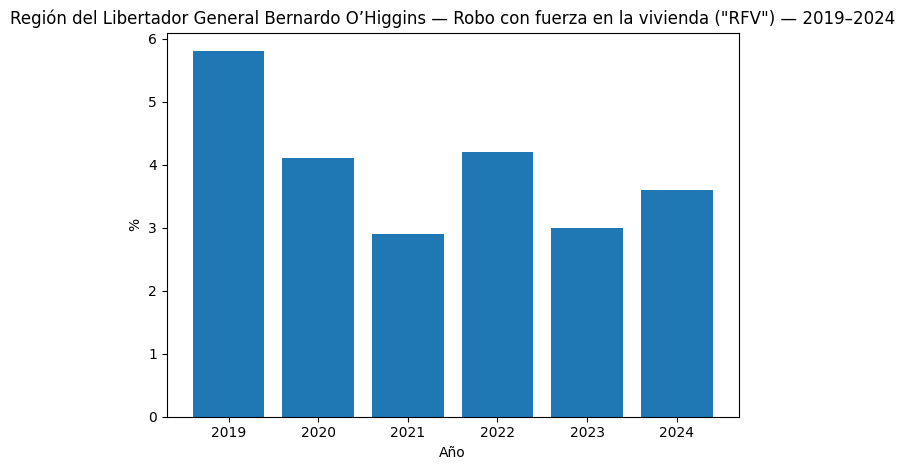

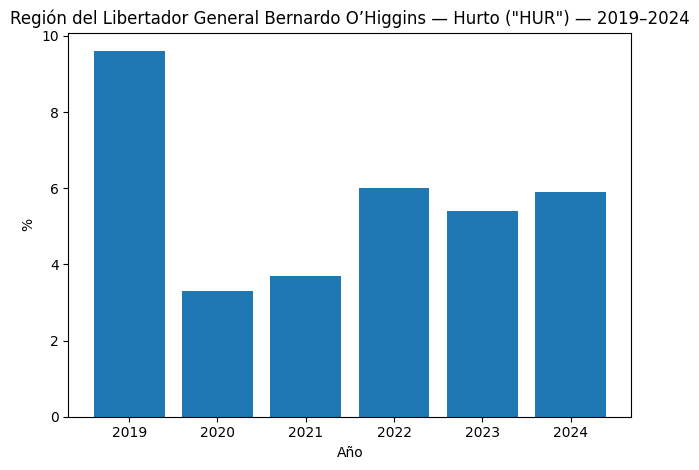

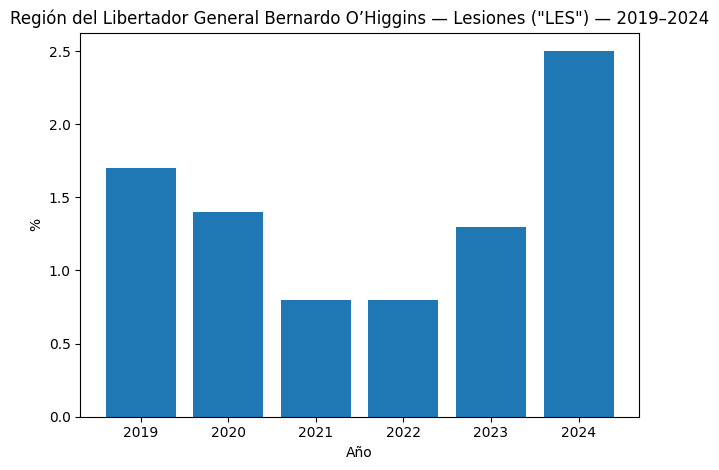

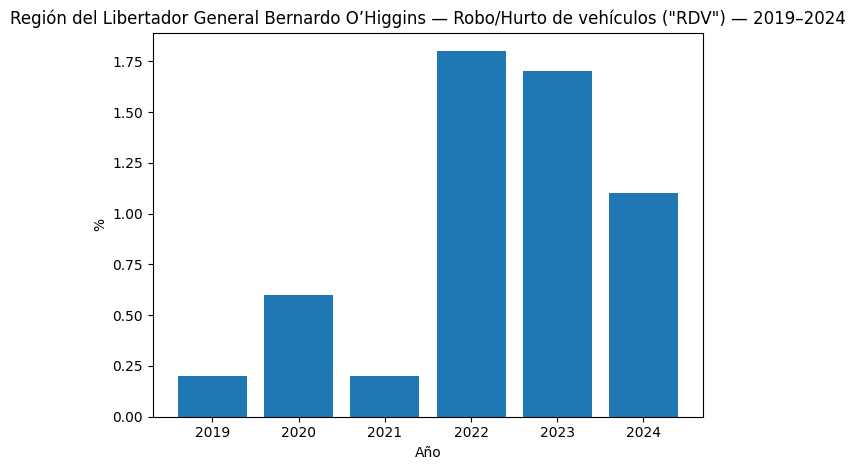

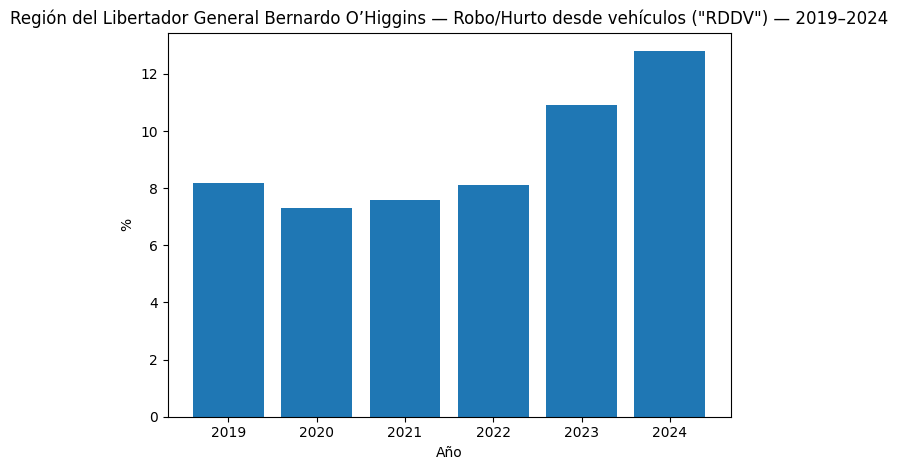

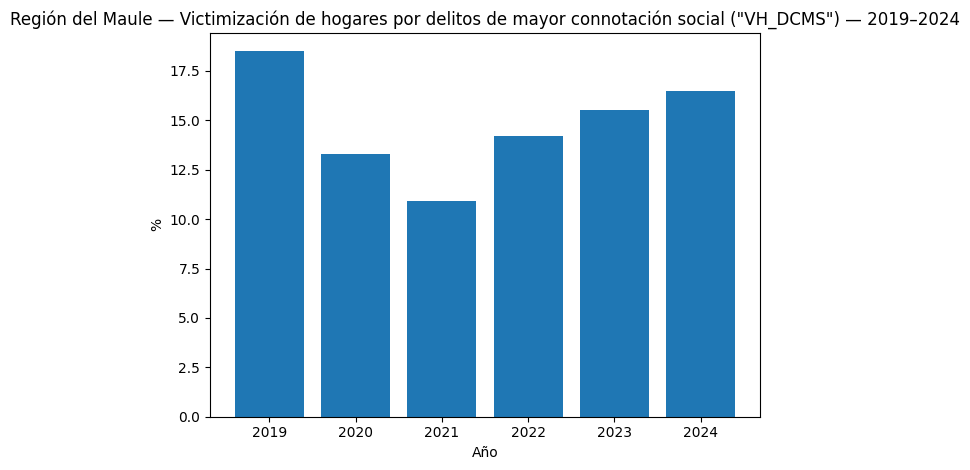

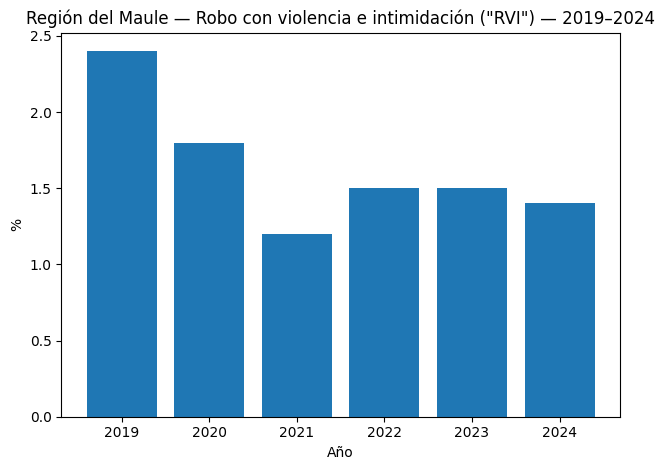

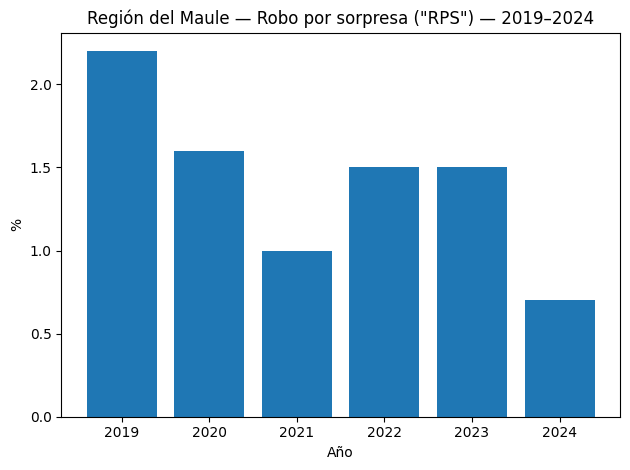

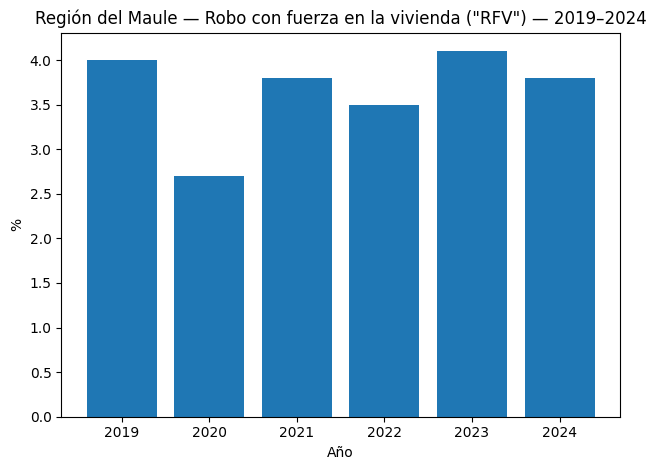

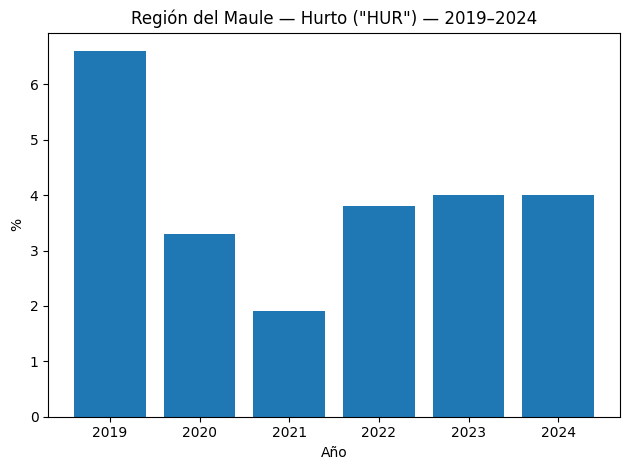

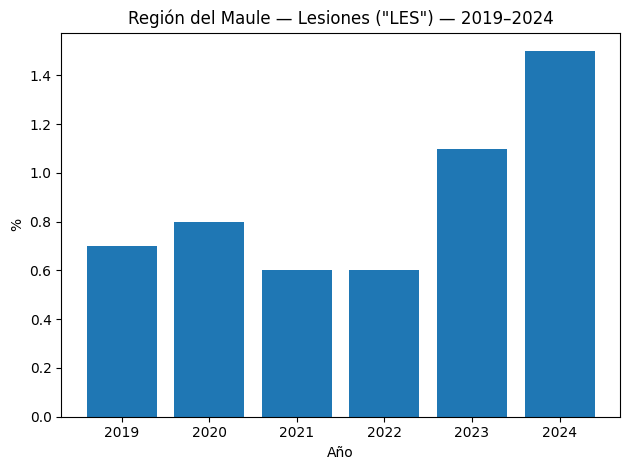

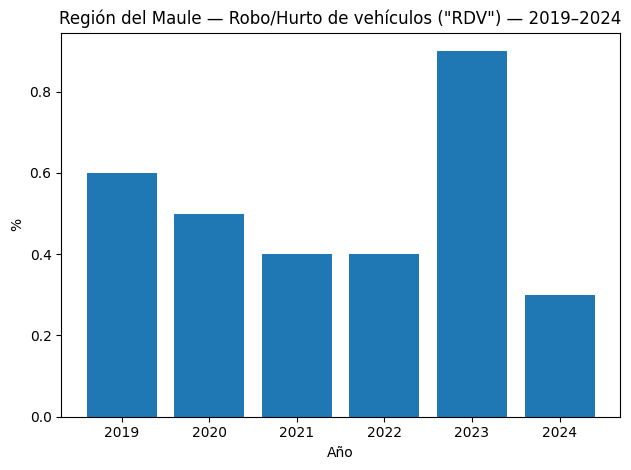

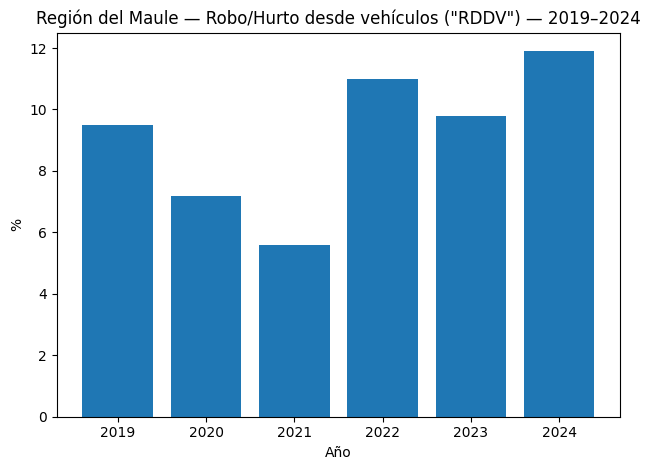

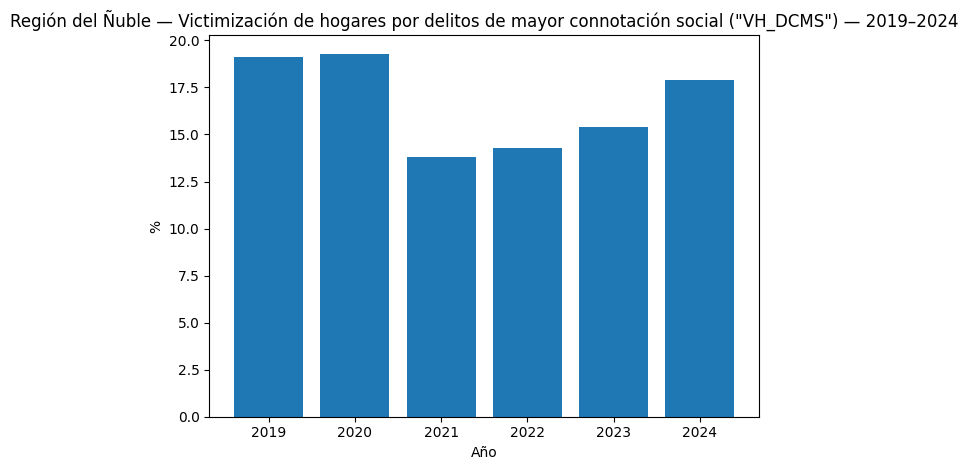

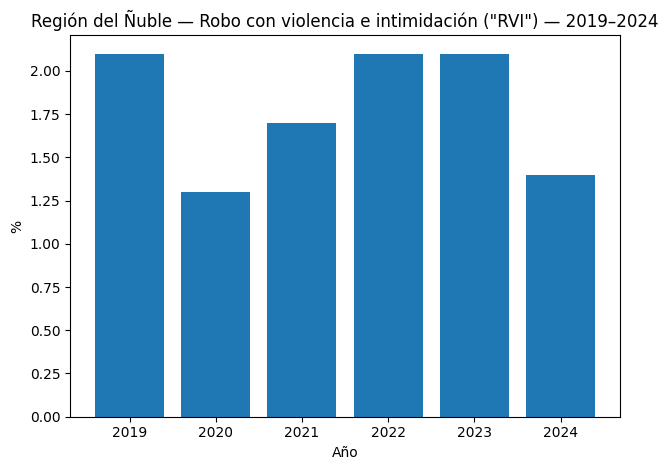

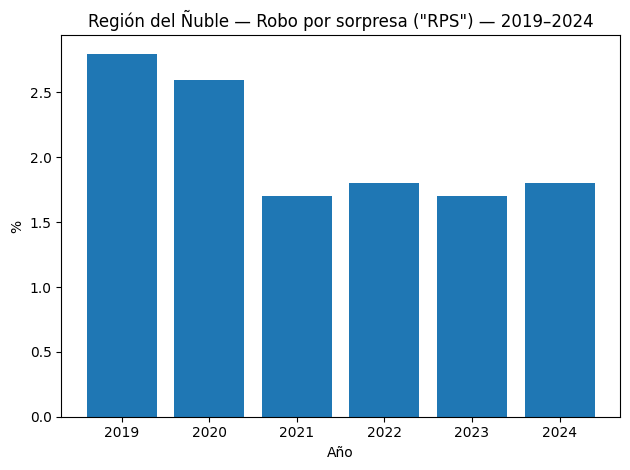

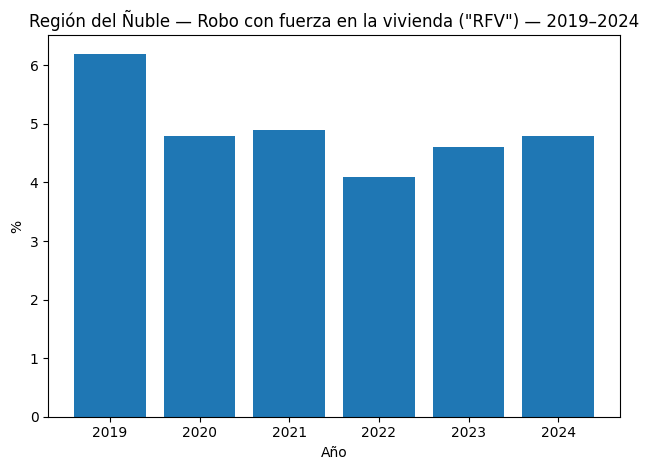

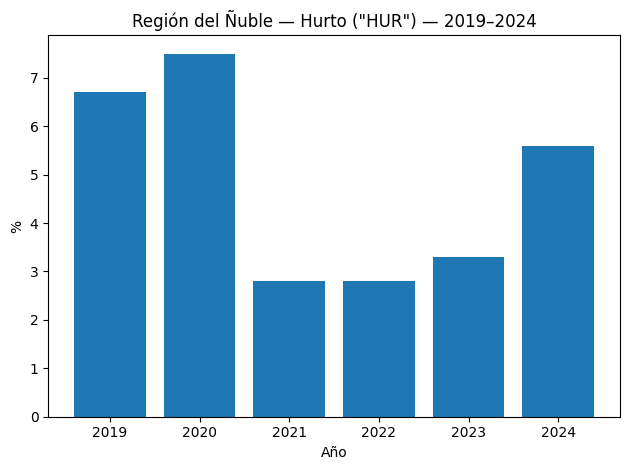

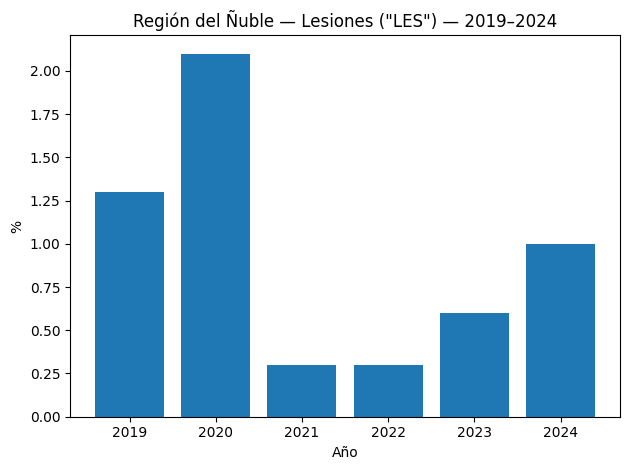

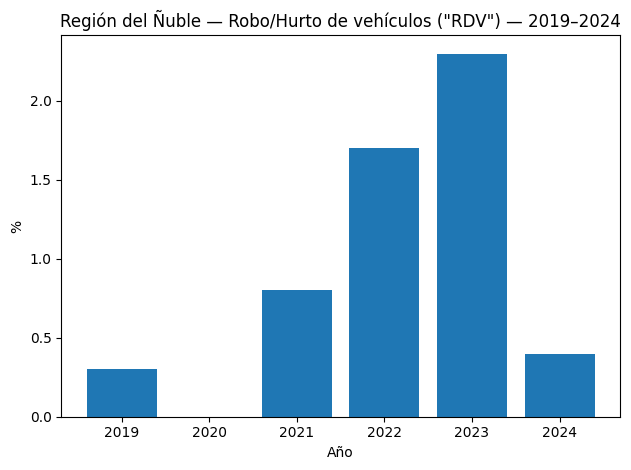

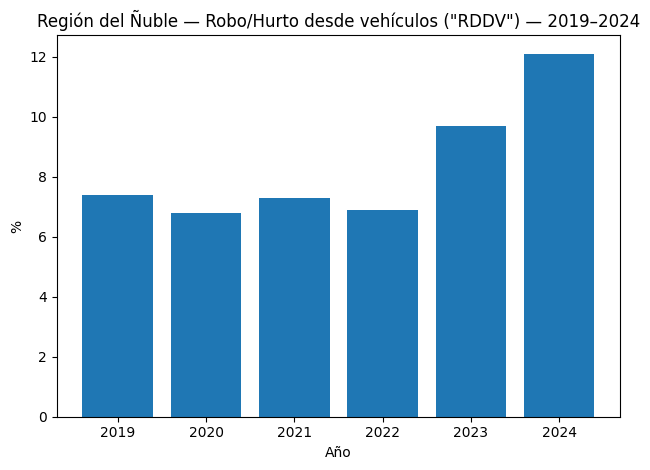

In [6]:
# ============================================================
# BLOQUE 3 — MISMAS VISUALIZACIONES QUE EL BLOQUE 2, PERO EN BARRAS
# Requiere que ya estén definidos en el BLOQUE 2:
#   - DataFrames: nat_percepcion, nat_victim, reg_percepcion, reg_victim
#   - Diccionarios/funciones: long_names, short_codes, _title
#   - Columnas con 'region_nombre' en reg_percepcion y reg_victim
# NO redefine nada: solo cambia las líneas por barras.
# ============================================================

def _bar(df, x, y, titulo, xlabel="Año", ylabel="%"):
    # Ordena y asegura ticks por año
    tmp = df[[x, y]].copy()
    tmp[x] = pd.to_numeric(tmp[x], errors='coerce')
    tmp[y] = pd.to_numeric(tmp[y], errors='coerce')
    tmp = tmp.dropna().sort_values(x)
    fig = plt.figure()
    plt.bar(tmp[x], tmp[y])
    plt.title(titulo)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(sorted(tmp[x].unique()))
    plt.tight_layout()
    plt.show()

# ------------------- NACIONAL (mismo set que en BLOQUE 2) -------------------

# 1) PAD (nacional) en barras
if 'PAD(%)' in nat_percepcion.columns:
    _bar(
        nat_percepcion.sort_values('año'),
        'año', 'PAD(%)',
        _title('PAD(%)', prefijo='Nacional', sufijo='2019–2024')
    )

# 2) Victimización (nacional) — mismas series del BLOQUE 2
nat_cols = [c for c in nat_victim.columns if c.endswith('(%)')]
for col in nat_cols:
    _bar(
        nat_victim.sort_values('año'),
        'año', col,
        _title(col, prefijo='Nacional', sufijo='2019–2024')
    )

# ------------------- REGIONAL (mismo set que en BLOQUE 2) -------------------

# 3) PAD por región
if {'PAD(%)','region_nombre','año'}.issubset(reg_percepcion.columns):
    for reg_name in sorted(reg_percepcion['region_nombre'].dropna().unique()):
        df_r = reg_percepcion[reg_percepcion['region_nombre'] == reg_name].sort_values('año')
        _bar(
            df_r, 'año', 'PAD(%)',
            _title('PAD(%)', prefijo=reg_name, sufijo='2019–2024')
        )

# 4) Victimización por región — mismas series del BLOQUE 2
vict_cols = ["VH_DCMS(%)","RVI(%)","RPS(%)","RFV(%)","HUR(%)","LES(%)","RDV(%)","RDDV(%)"]
if {'region_nombre','año'}.issubset(reg_victim.columns):
    for reg_name in sorted(reg_victim['region_nombre'].dropna().unique()):
        df_r = reg_victim[reg_victim['region_nombre'] == reg_name].sort_values('año')
        for col in vict_cols:
            if col in df_r.columns:
                _bar(
                    df_r, 'año', col,
                    _title(col, prefijo=reg_name, sufijo='2019–2024')
                )
